# Final Analysis: Deciphering the intrinsic latents of SSL ViTs

## 1. Setup and Configuration


In [18]:
import os
import json
import pickle
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional, Tuple, Union, Any
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

# Machine learning stuff
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from sklearn.metrics import silhouette_score

# Project imports
from src.probing.probes import create_probe, VoxelProbe, LinearProbe, MLPProbe
from src.datasets.shapenet_voxel_meshes import create_3dr2n2_reconstruction_dataloaders
from src.datasets.shapenet_3dr2n2 import create_3dr2n2_dataloaders
from src.models.model_loader import load_model_and_preprocessor
from src.analysis.layer_analysis import LayerWiseAnalyzer

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### 1.1 Visual Design


In [19]:
class VisualConfig:
    """Unified visual design config"""
    
    # Color palettes
    MODEL_COLORS = {
        'dinov2': '#2E86AB',      # Deep blue
        'ijepa': '#A23B72',       # Wine
        'supervised_vit': '#F18F01',  # Orange
        'mocov3': '#C73E1D'       # Red-orange
    }
    
    PROBE_COLORS = {
        'linear': '#4A90E2',      # Light blue
        'mlp': '#F5A623',         # Orange
        'voxel': '#7ED321'        # Green
    }
    
    METRIC_COLORS = {
        'iou': '#50C878',         # Emerald
        'precision': '#FFD700',   # Gold
        'recall': '#DC143C',      # Crimson
        'f1': '#9370DB',          # Medium purple
        'mae': '#FF6B6B',         # Light red
        'rmse': '#4ECDC4',        # Turquoise
        'r2': '#95E1D3'           # Mint
    }
    
    # Typography
    FONT_FAMILY = 'Raleway'
    FONT_FAMILY_ALT = 'Rubik'
    TITLE_SIZE = 18
    LABEL_SIZE = 14
    TICK_SIZE = 12
    LEGEND_SIZE = 12
    
    # Plot styling
    FIGURE_DPI = 300
    LINE_WIDTH = 2.5
    MARKER_SIZE = 8
    ALPHA = 0.8
    GRID_ALPHA = 0.3
    
    # Figure sizes
    SINGLE_FIG_SIZE = (8, 6)
    DOUBLE_FIG_SIZE = (15, 6)
    QUAD_FIG_SIZE = (16, 12)
    
    @classmethod
    def setup_matplotlib(cls):
        """Configure matplotlib with our design settings"""
        try:
            font_dirs = ['/usr/share/fonts/', '~/.fonts']
            font_files = fm.findSystemFonts(fontpaths=font_dirs)
            for font_file in font_files:
                fm.fontManager.addfont(font_file)
        except:
            pass
        fm.fontManager.addfont('./Raleway.ttf')
        
        plt.style.use('seaborn-v0_8-darkgrid')
        
        plt.rcParams.update({
            'font.family': 'sans-serif',
            'font.sans-serif': [cls.FONT_FAMILY, cls.FONT_FAMILY_ALT, 'DejaVu Sans'],
            'font.size': cls.LABEL_SIZE,
            'axes.titlesize': cls.TITLE_SIZE,
            'axes.labelsize': cls.LABEL_SIZE,
            'xtick.labelsize': cls.TICK_SIZE,
            'ytick.labelsize': cls.TICK_SIZE,
            'legend.fontsize': cls.LEGEND_SIZE,
            'figure.dpi': cls.FIGURE_DPI,
            'savefig.dpi': cls.FIGURE_DPI,
            'axes.linewidth': 1.5,
            'axes.grid': True,
            'grid.alpha': cls.GRID_ALPHA,
            'axes.spines.top': False,
            'axes.spines.right': False,
        })
        
        sns.set_palette([cls.MODEL_COLORS[m] for m in cls.MODEL_COLORS])
    
    @classmethod
    def get_plotly_layout(cls, title: str = "") -> dict:
        return dict(
            title=dict(text=title, font=dict(size=cls.TITLE_SIZE, family=cls.FONT_FAMILY)),
            font=dict(family=cls.FONT_FAMILY, size=cls.LABEL_SIZE),
            plot_bgcolor='white',
            paper_bgcolor='white',
            showlegend=True,
            hovermode='closest',
            margin=dict(l=80, r=80, t=100, b=80)
        )

VisualConfig.setup_matplotlib()

### 1.2 Output Management

In [20]:
class OutputManager:
    """Manages saving of figures and data"""
    
    def __init__(self, base_dir: str = "final_analysis"):
        self.base_dir = Path(base_dir)
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        self.dirs = {
            'root': self.base_dir,
            'figures': self.base_dir / 'figures',
            'subplots': self.base_dir / 'figures' / 'subplots',
            'data': self.base_dir / 'data',
            'comparisons': self.base_dir / 'comparisons'
        }
        
        for dir_path in self.dirs.values():
            dir_path.mkdir(parents=True, exist_ok=True)
    
    def save_figure(self, fig: plt.Figure, name: str, save_subplots: bool = False):
        filename = f"{name}_{self.timestamp}.png"
        filepath = self.dirs['figures'] / filename
        fig.savefig(filepath, bbox_inches='tight', dpi=VisualConfig.FIGURE_DPI)
        print(f"Saved figure: {filepath}")
        
        # we can also save each subplot separately (nice for the poster) 
        if save_subplots and hasattr(fig, 'axes'):
            for i, ax in enumerate(fig.axes):
                if hasattr(ax, 'get_title') and ax.get_title():
                    subplot_fig, subplot_ax = plt.subplots(figsize=VisualConfig.SINGLE_FIG_SIZE)
                    
                    for line in ax.get_lines():
                        subplot_ax.plot(line.get_xdata(), line.get_ydata(), 
                                      color=line.get_color(), 
                                      linewidth=line.get_linewidth(),
                                      marker=line.get_marker(),
                                      markersize=line.get_markersize(),
                                      label=line.get_label())
                    
                    subplot_ax.set_xlabel(ax.get_xlabel())
                    subplot_ax.set_ylabel(ax.get_ylabel())
                    subplot_ax.set_title(ax.get_title())
                    subplot_ax.grid(True, alpha=VisualConfig.GRID_ALPHA)
                    if ax.get_legend():
                        subplot_ax.legend()
                    
                    subplot_filename = f"{name}_subplot_{i}_{ax.get_title().replace(' ', '_').lower()}_{self.timestamp}.png"
                    subplot_filepath = self.dirs['subplots'] / subplot_filename
                    subplot_fig.savefig(subplot_filepath, bbox_inches='tight', dpi=VisualConfig.FIGURE_DPI)
                    plt.close(subplot_fig)
    
    def save_plotly_figure(self, fig: go.Figure, name: str):
        """Save the figure to the provided writepath"""
        filename = f"{name}_{self.timestamp}"
        filepath_html = self.dirs['figures'] / f"{filename}.html"
        filepath_png = self.dirs['figures'] / f"{filename}.png"
        
        fig.write_html(filepath_html)
        fig.write_image(filepath_png, width=1200, height=800)
        print(f"Saved plotly figure: {filepath_png}")
    
    def save_data(self, data: Any, name: str):
        """Save data thattwas used to generate the stuff"""
        filename = f"{name}_{self.timestamp}.json"
        filepath = self.dirs['data'] / filename
        
        def convert_to_serializable(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, (np.integer, np.floating)):
                return float(obj)
            elif isinstance(obj, Path):
                return str(obj)
            elif hasattr(obj, '__dict__'):
                return obj.__dict__
            return obj
        
        serializable_data = json.loads(
            json.dumps(data, default=convert_to_serializable)
        )
        
        with open(filepath, 'w') as f:
            json.dump(serializable_data, f, indent=2)
        print(f"Saved data: {filepath}")

output_manager = OutputManager()

## 2. Data Loading 

In [21]:
@dataclass
class ExperimentResult:
    """Contains the results for all the experiments in a standardized format"""
    name: str
    model: str
    task: str
    results: Dict[str, Any]
    cache_dir: Path
    results_dir: Path
    
    def get_best_layer(self, probe_type: str = None) -> Tuple[int, float]:
        """Get best performing layer and its metric value"""
        best_layer = None
        best_metric = float('inf') if self.task == 'viewpoint_estimation' else 0.0
        
        for layer_key, layer_data in self.results.get('results', {}).items():
            if not layer_key.startswith('layer_'):
                continue
                
            layer_num = int(layer_key.split('_')[1])
            
            if probe_type:
                if probe_type in layer_data:
                    metric = self._get_primary_metric(layer_data[probe_type])
                    if self._is_better_metric(metric, best_metric):
                        best_metric = metric
                        best_layer = layer_num
            else:
                for p_type, p_data in layer_data.items():
                    metric = self._get_primary_metric(p_data)
                    if self._is_better_metric(metric, best_metric):
                        best_metric = metric
                        best_layer = layer_num
        
        return best_layer, best_metric
    
    def _get_primary_metric(self, probe_data: Dict) -> float:
        """Get primary metric for the task"""
        test_metrics = probe_data.get('test_metrics', {})
        if self.task == 'viewpoint_estimation':
            return test_metrics.get('mae', float('inf'))
        else:  # voxel_reconstruction
            return test_metrics.get('voxel_iou', 0.0)
    
    def _is_better_metric(self, new_metric: float, best_metric: float) -> bool:
        """Check if new metric is better than current best"""
        if self.task == 'viewpoint_estimation':
            return new_metric < best_metric
        else:
            return new_metric > best_metric


class ExperimentLoader:
    """Loads all the data from the cache/results dir"""
    
    def __init__(self, base_path: str = "."):
        self.base_path = Path(base_path)
        self.cache_path = self.base_path / "cache"
        self.results_path = self.base_path / "results"
        
    def load_all_experiments(self) -> Dict[str, ExperimentResult]:
        """Load all experiments from results directory"""
        experiments = {}
        
        for results_dir in self.results_path.iterdir():
            if not results_dir.is_dir() or results_dir.name.startswith('.'):
                continue
                
            exp_name = results_dir.name
            model, task = self._parse_experiment_name(exp_name)
            
            results_file = results_dir / "results.json"
            if not results_file.exists():
                print(f"Warning: No results.json found for {exp_name}")
                continue
                
            with open(results_file, 'r') as f:
                results_data = json.load(f)
            
            cache_dir = self._find_cache_dir(exp_name)
            
            experiments[exp_name] = ExperimentResult(
                name=exp_name,
                model=model,
                task=task,
                results=results_data,
                cache_dir=cache_dir,
                results_dir=results_dir
            )
            
        return experiments
    
    def categorize_experiments(self, experiments: Dict[str, ExperimentResult]) -> Dict[str, List[ExperimentResult]]:
        """Categorize experiments by task and model"""
        categorized = {
            'voxel_reconstruction': [],
            'viewpoint_estimation': [],
            'by_model': {}
        }
        
        for exp in experiments.values():
            categorized[exp.task].append(exp)
            
            if exp.model not in categorized['by_model']:
                categorized['by_model'][exp.model] = []
            categorized['by_model'][exp.model].append(exp)
        
        return categorized
    
    def _parse_experiment_name(self, exp_name: str) -> Tuple[str, str]:
        """Extract model and task from experiment name"""
        exp_lower = exp_name.lower()
        
        if 'dinov2' in exp_lower:
            model = 'dinov2'
        elif 'ijepa' in exp_lower:
            model = 'ijepa'
        elif 'supervised' in exp_lower:
            model = 'supervised_vit'
        else:
            model = 'unknown'
        
        # which task was this?    
        if 'viewpoint' in exp_lower:
            task = 'viewpoint_estimation'
        elif 'voxel' in exp_lower or 'reconstruction' in exp_lower:
            task = 'voxel_reconstruction'
        else:
            task = 'unknown'
            
        return model, task
    
    def _find_cache_dir(self, exp_name: str) -> Path:
        """Find corresponding cache dir"""
        cache_dir = self.cache_path / exp_name
        if cache_dir.exists():
            return cache_dir
            
        alternatives = [
            exp_name.replace('phase1_', '').replace('phase2_', ''),
            exp_name.replace('_probing', ''),
            exp_name.replace('_reconstruction', '')
        ]
        
        for alt_name in alternatives:
            if alt_name and (self.cache_path / alt_name).exists():
                return self.cache_path / alt_name
                
        return self.cache_path / exp_name
    
    def get_probe_files(self, experiment: ExperimentResult) -> Dict[str, Dict[int, Path]]:
        """Organize the probes by experiment and wihch layer they were on"""
        probes = {}
        probes_dir = experiment.cache_dir / "probes"
        
        if not probes_dir.exists():
            return probes
            
        for probe_file in probes_dir.glob("*.pth"):
            filename = probe_file.stem
            
            if experiment.task == 'viewpoint_estimation':
                if '_layer_' in filename:
                    parts = filename.split('_layer_')
                    if len(parts) == 2 and parts[1].isdigit():
                        probe_type = parts[0]
                        layer_num = int(parts[1])
                        
                        if probe_type not in probes:
                            probes[probe_type] = {}
                        probes[probe_type][layer_num] = probe_file
                        
            elif experiment.task == 'voxel_reconstruction':
                if '_voxel_layer_' in filename:
                    layer_part = filename.split('_voxel_layer_')[-1]
                    if layer_part.isdigit():
                        probe_type = 'voxel'
                        layer_num = int(layer_part)
                        
                        if probe_type not in probes:
                            probes[probe_type] = {}
                        probes[probe_type][layer_num] = probe_file
        
        return probes
    
    def get_feature_files(self, experiment: ExperimentResult) -> Dict[int, Dict[str, Path]]:
        """Get feature files organized in the same manner as above"""
        features = {}
        features_dir = experiment.cache_dir / "features"
        
        if not features_dir.exists():
            return features
            
        for feature_file in features_dir.glob("*.pkl"):
            filename = feature_file.stem
            if filename.startswith('layer_'):
                parts = filename.split('_')
                if len(parts) >= 3 and parts[1].isdigit():
                    layer_num = int(parts[1])
                    split = parts[2]
                    
                    if layer_num not in features:
                        features[layer_num] = {}
                    features[layer_num][split] = feature_file
                    
        return features

In [22]:
# first we load and categorize all the experiments...
loader = ExperimentLoader()
all_experiments = loader.load_all_experiments()
categorized_experiments = loader.categorize_experiments(all_experiments)

print(f"Loaded {len(all_experiments)} experiments:")
print(f"  Voxel Reconstruction: {len(categorized_experiments['voxel_reconstruction'])}")
print(f"  Viewpoint Estimation: {len(categorized_experiments['viewpoint_estimation'])}")
print("\nBy model:")
for model, exps in categorized_experiments['by_model'].items():
    print(f"  {model}: {len(exps)} experiments")
    for exp in exps:
        print(f"    - {exp.name} ({exp.task})")

# save the summary we found above just in case
experiment_summary = {
    'total_experiments': len(all_experiments),
    'experiments_by_task': {
        task: [exp.name for exp in exps] 
        for task, exps in categorized_experiments.items() 
        if task != 'by_model'
    },
    'experiments_by_model': {
        model: [exp.name for exp in exps]
        for model, exps in categorized_experiments['by_model'].items()
    }
}
output_manager.save_data(experiment_summary, 'experiment_summary')

Loaded 3 experiments:
  Voxel Reconstruction: 1
  Viewpoint Estimation: 2

By model:
  dinov2: 2 experiments
    - phase2_dinov2_voxel_reconstruction (voxel_reconstruction)
    - phase1_dinov2_viewpoint_probing (viewpoint_estimation)
  ijepa: 1 experiments
    - ijepa_phase1_ijepa_viewpoint_probing (viewpoint_estimation)
Saved data: final_analysis/data/experiment_summary_20250607_232056.json


## 3. Voxel Reconstruction Analysis

### 3.1 Quantitive Analysis

Saved figure: final_analysis/figures/voxel_reconstruction_all_models_20250607_232056.png


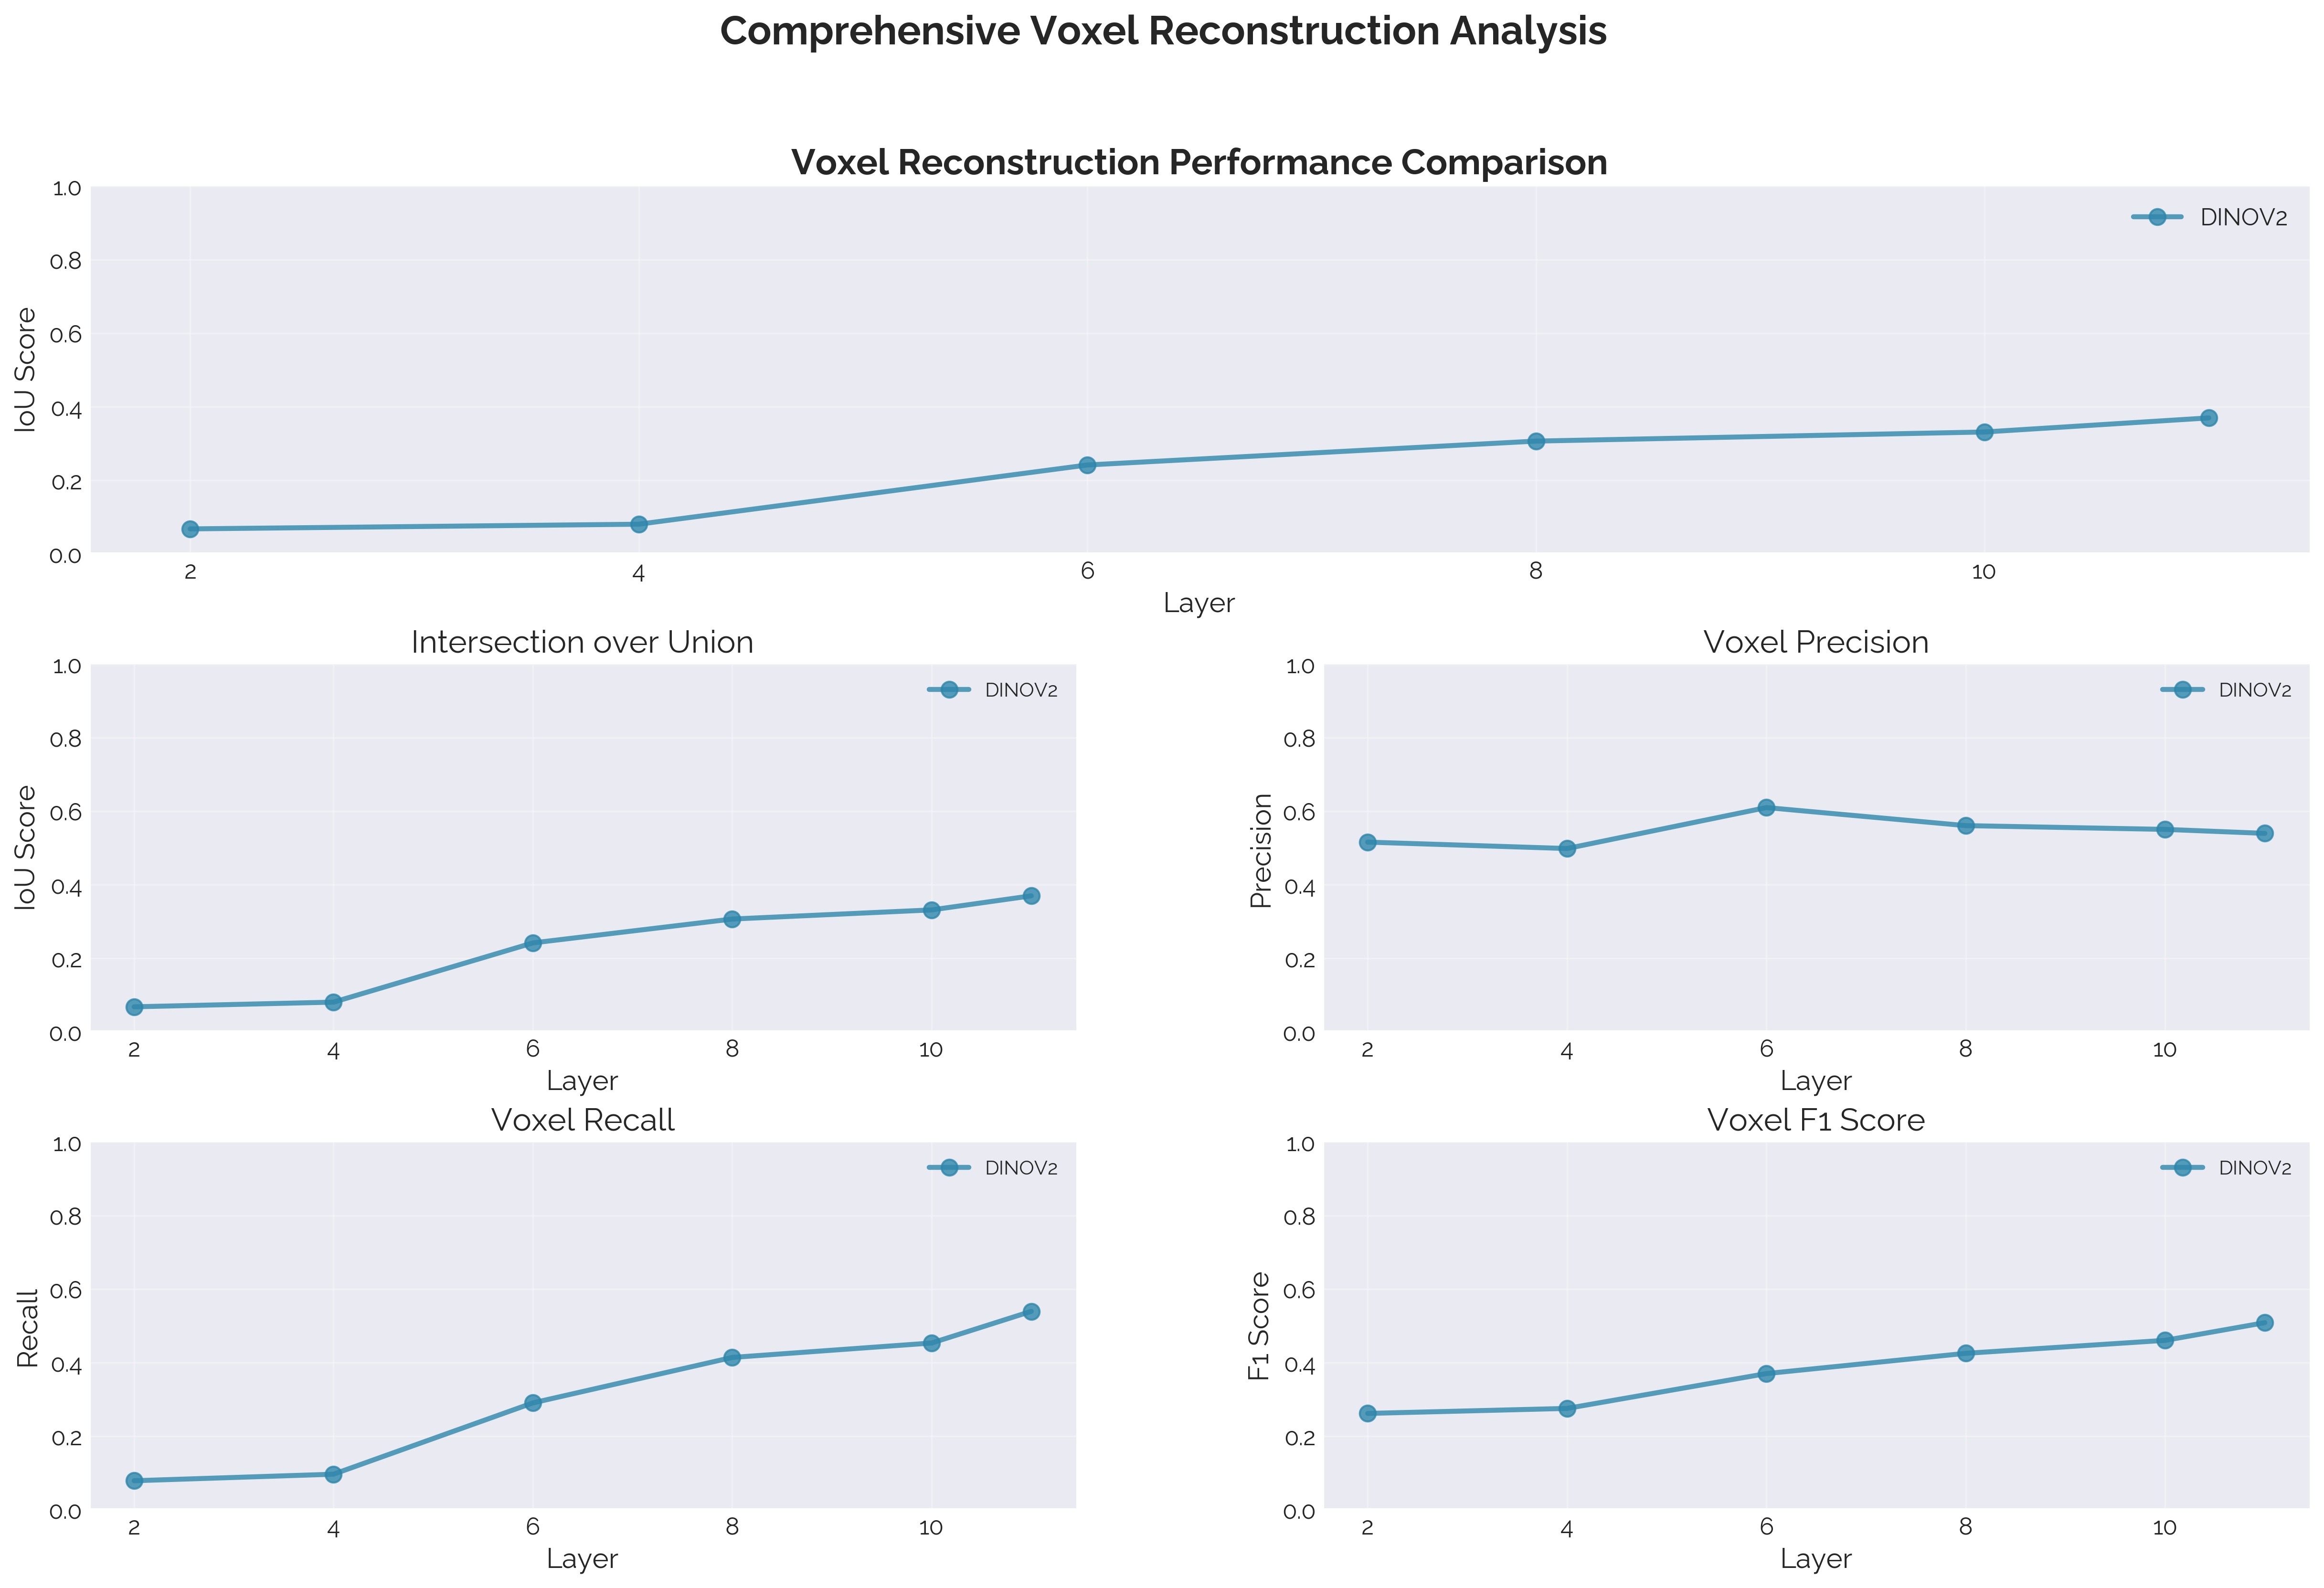

Saved data: final_analysis/data/voxel_reconstruction_metrics_20250607_232056.json

Voxel Reconstruction Summary:

DINOV2:
  Best Layer: 11
  Best IoU: 0.3694
  Precision: 0.5394
  Recall: 0.5392
  F1 Score: 0.5084


In [23]:
def analyze_voxel_reconstruction_all_models(experiments: List[ExperimentResult], 
                                          output_manager: OutputManager):
    """Analyze the voxel reconstruction performance for all associated models/experiments"""
    
    model_data = {}
    
    for exp in experiments:
        metrics_dict = exp.results.get('results', {})
        
        layers = []
        metrics = {
            'iou': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        for layer_key, layer_data in metrics_dict.items():
            if layer_key.startswith('layer_') and 'voxel' in layer_data:
                layer_num = int(layer_key.split('_')[1])
                test_metrics = layer_data['voxel'].get('test_metrics', {})
                
                layers.append(layer_num)
                metrics['iou'].append(test_metrics.get('voxel_iou', 0))
                metrics['precision'].append(test_metrics.get('voxel_precision', 0))
                metrics['recall'].append(test_metrics.get('voxel_recall', 0))
                metrics['f1'].append(test_metrics.get('voxel_f1', 0))
        
        if layers:
            sorted_idx = np.argsort(layers)
            model_data[exp.model] = {
                'layers': np.array(layers)[sorted_idx],
                'metrics': {k: np.array(v)[sorted_idx] for k, v in metrics.items()},
                'experiment': exp
            }
    
    #===================================================================================================
    # VISUALIZATION CODE BEGINS
    #=================================================================================================== 
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)
    
    ax_main = fig.add_subplot(gs[0, :])
    
    ax_iou = fig.add_subplot(gs[1, 0])
    ax_precision = fig.add_subplot(gs[1, 1])
    ax_recall = fig.add_subplot(gs[2, 0])
    ax_f1 = fig.add_subplot(gs[2, 1])
    
    metric_axes = {
        'iou': (ax_iou, 'IoU Score', 'Intersection over Union'),
        'precision': (ax_precision, 'Precision', 'Voxel Precision'),
        'recall': (ax_recall, 'Recall', 'Voxel Recall'),
        'f1': (ax_f1, 'F1 Score', 'Voxel F1 Score')
    }
    
    # plot IOU 
    for model_name, data in model_data.items():
        ax_main.plot(data['layers'], data['metrics']['iou'],
                    'o-', linewidth=VisualConfig.LINE_WIDTH,
                    markersize=VisualConfig.MARKER_SIZE,
                    color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                    label=model_name.upper(),
                    alpha=VisualConfig.ALPHA)
    
    ax_main.set_xlabel('Layer', fontsize=VisualConfig.LABEL_SIZE)
    ax_main.set_ylabel('IoU Score', fontsize=VisualConfig.LABEL_SIZE)
    ax_main.set_title('Voxel Reconstruction Performance Comparison',
                     fontsize=VisualConfig.TITLE_SIZE, fontweight='bold')
    ax_main.legend(fontsize=VisualConfig.LEGEND_SIZE)
    ax_main.grid(True, alpha=VisualConfig.GRID_ALPHA)
    ax_main.set_ylim([0, 1])
    
    # plot all the other metrics
    for metric_name, (ax, ylabel, title) in metric_axes.items():
        for model_name, data in model_data.items():
            ax.plot(data['layers'], data['metrics'][metric_name],
                   'o-', linewidth=VisualConfig.LINE_WIDTH,
                   markersize=VisualConfig.MARKER_SIZE,
                   color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                   label=model_name.upper(),
                   alpha=VisualConfig.ALPHA)
        
        ax.set_xlabel('Layer', fontsize=VisualConfig.LABEL_SIZE)
        ax.set_ylabel(ylabel, fontsize=VisualConfig.LABEL_SIZE)
        ax.set_title(title, fontsize=VisualConfig.LABEL_SIZE + 2)
        ax.legend(fontsize=VisualConfig.LEGEND_SIZE - 2)
        ax.grid(True, alpha=VisualConfig.GRID_ALPHA)
        ax.set_ylim([0, 1])
    
    plt.suptitle('Comprehensive Voxel Reconstruction Analysis',
                fontsize=VisualConfig.TITLE_SIZE + 2, fontweight='bold')
    
    output_manager.save_figure(fig, 'voxel_reconstruction_all_models', save_subplots=True)
    plt.show()
    
    raw_data = {
        model: {
            'layers': data['layers'].tolist(),
            'metrics': {k: v.tolist() for k, v in data['metrics'].items()},
            'best_layer': int(data['layers'][np.argmax(data['metrics']['iou'])]),
            'best_iou': float(np.max(data['metrics']['iou']))
        }
        for model, data in model_data.items()
    }
    output_manager.save_data(raw_data, 'voxel_reconstruction_metrics')
   
    # summary of the test 
    print("\nVoxel Reconstruction Summary:")
    for model, data in model_data.items():
        best_idx = np.argmax(data['metrics']['iou'])
        print(f"\n{model.upper()}:")
        print(f"  Best Layer: {data['layers'][best_idx]}")
        print(f"  Best IoU: {data['metrics']['iou'][best_idx]:.4f}")
        print(f"  Precision: {data['metrics']['precision'][best_idx]:.4f}")
        print(f"  Recall: {data['metrics']['recall'][best_idx]:.4f}")
        print(f"  F1 Score: {data['metrics']['f1'][best_idx]:.4f}")
    
    return model_data


#===================================================================================================
# RUNNING THE ANALYSIS
#===================================================================================================
    
voxel_model_data = analyze_voxel_reconstruction_all_models(
    categorized_experiments['voxel_reconstruction'],
    output_manager
)

### 3.2 Comparative Visualizations

In [ ]:
def create_comparative_voxel_visualizations(model_data: Dict, loader: ExperimentLoader,
                                           output_manager: OutputManager):
    """Create side-by-side 3D voxel reconstructions for all the best layers"""
    
    from omegaconf import OmegaConf
    from hydra import compose, initialize_config_dir
    from hydra.core.global_hydra import GlobalHydra
    
    GlobalHydra.instance().clear()
    
    try:
        config_dir = str(Path("../configs").resolve())
        with initialize_config_dir(config_dir=config_dir, version_base=None):
            cfg = compose(config_name="datasets/shapenet_voxel_meshes").datasets
            cfg.categories = ["chair"]
            cfg.dataloader = {'batch_size': 1, 'num_workers': 0}
            
            _, _, test_loader = create_3dr2n2_reconstruction_dataloaders(
                cfg, batch_size=1, num_workers=0
            )
            
            sample = next(iter(test_loader))
            gt_voxels = sample['voxel_gt'][0].squeeze().numpy()
        
        fig = make_subplots(
            rows=1, cols=len(model_data) + 1,
            subplot_titles=['Ground Truth'] + [m.upper() for m in model_data.keys()],
            specs=[[{'type': 'scatter3d'} for _ in range(len(model_data) + 1)]],
            horizontal_spacing=0.02
        )
        
        # add GT data
        gt_points = np.argwhere(gt_voxels)
        if len(gt_points) > 0:
            fig.add_trace(
                go.Scatter3d(
                    x=gt_points[:, 0],
                    y=gt_points[:, 1],
                    z=gt_points[:, 2],
                    mode='markers',
                    marker=dict(size=3, color='gray', opacity=0.8),
                    name='Ground Truth',
                    showlegend=False
                ),
                row=1, col=1
            )
        
        # add the preds for each model 
        for idx, (model_name, data) in enumerate(model_data.items()):
            exp = data['experiment']
            best_layer = data['layers'][np.argmax(data['metrics']['iou'])]
            
            # load all the probes & features
            probe_files = loader.get_probe_files(exp)
            feature_files = loader.get_feature_files(exp)
            
            if 'voxel' in probe_files and best_layer in probe_files['voxel']:
                probe_path = probe_files['voxel'][best_layer]
                features_path = feature_files[best_layer]['test']
                
                probe_state = torch.load(probe_path, map_location=device)
                probe_config = probe_state.get('probe_config', {
                    'type': 'voxel',
                    'input_dim': 18624,
                    'voxel_resolution': 32
                })
                
                probe = create_probe(probe_config)
                probe.load_state_dict(probe_state['model_state_dict'])
                probe.to(device).eval()
                
                with open(features_path, 'rb') as f:
                    features_data = pickle.load(f)
                
                if 'view_data' in features_data:
                    features = features_data['view_data'][0:1]
                else:
                    features = features_data['features'][0:1]
                
                features = torch.tensor(features).to(device).view(1, -1)
                
                # get prediction 
                with torch.no_grad():
                    pred_logits = probe(features)
                    pred_voxels = (torch.sigmoid(pred_logits) > 0.5).squeeze().cpu().numpy()
                
                # add 2 plot
                pred_points = np.argwhere(pred_voxels)
                if len(pred_points) > 0:
                    fig.add_trace(
                        go.Scatter3d(
                            x=pred_points[:, 0],
                            y=pred_points[:, 1],
                            z=pred_points[:, 2],
                            mode='markers',
                            marker=dict(
                                size=3,
                                color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                                opacity=0.8
                            ),
                            name=model_name.upper(),
                            showlegend=False
                        ),
                        row=1, col=idx + 2
                    )
        
        fig.update_layout(
            title=dict(
                text='Comparative Voxel Reconstructions (Best Layers)',
                font=dict(size=VisualConfig.TITLE_SIZE, family=VisualConfig.FONT_FAMILY)
            ),
            scene=dict(
                aspectmode='cube',
                xaxis=dict(range=[0, 32], showticklabels=False),
                yaxis=dict(range=[0, 32], showticklabels=False),
                zaxis=dict(range=[0, 32], showticklabels=False)
            ),
            width=300 * (len(model_data) + 1),
            height=400
        )
        
        for i in range(len(model_data) + 1):
            fig.update_scenes(
                dict(
                    aspectmode='cube',
                    xaxis=dict(range=[0, 32], showticklabels=False),
                    yaxis=dict(range=[0, 32], showticklabels=False),
                    zaxis=dict(range=[0, 32], showticklabels=False)
                ),
                row=1, col=i + 1
            )
        
        output_manager.save_plotly_figure(fig, 'voxel_reconstruction_comparison_3d')
        fig.show()
        
    except Exception as e:
        print(f"Could not create 3D visualizations: {e}")
    finally:
        GlobalHydra.instance().clear()

#===================================================================================================
# RUNNING THE ANALYSIS
#===================================================================================================
print(voxel_model_data)
if voxel_model_data:
    voxel_model_data_no_ijepa = {key: value for key, value in voxel_model_data.items() if key != "ijepa"}
    create_comparative_voxel_visualizations(voxel_model_data, loader, output_manager)

{'dinov2': {'layers': array([ 2,  4,  6,  8, 10, 11]), 'metrics': {'iou': array([0.06756099, 0.08029944, 0.24138193, 0.30633047, 0.33113927,
       0.36944133]), 'precision': array([0.51553851, 0.49811774, 0.60952091, 0.56041777, 0.55016923,
       0.53936315]), 'recall': array([0.07845592, 0.09623108, 0.29018933, 0.41384059, 0.45306066,
       0.53921551]), 'f1': array([0.26155367, 0.27515927, 0.3699207 , 0.42502952, 0.46032545,
       0.5083974 ])}, 'experiment': ExperimentResult(name='phase2_dinov2_voxel_reconstruction', model='dinov2', task='voxel_reconstruction', results={'config': {'models': {'_target_': 'src.models.feature_extractor.FeatureExtractor', 'model_name': 'dinov2', 'checkpoint_path': None, 'device': 'cuda', 'cache_dir': None, 'feature_extraction': {'layers': [2, 4, 6, 8, 10, 11], 'feature_type': 'cls_token', 'return_all_layers': True}, 'model_config': {'output_hidden_states': True}}, 'datasets': {'_target_': 'src.datasets.shapenet_voxel_meshes.ShapeNetVoxelMeshes', 'na

### 3.3 Analysis of Layer Evolution

Saved figure: final_analysis/figures/voxel_layer_evolution_20250607_232056.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


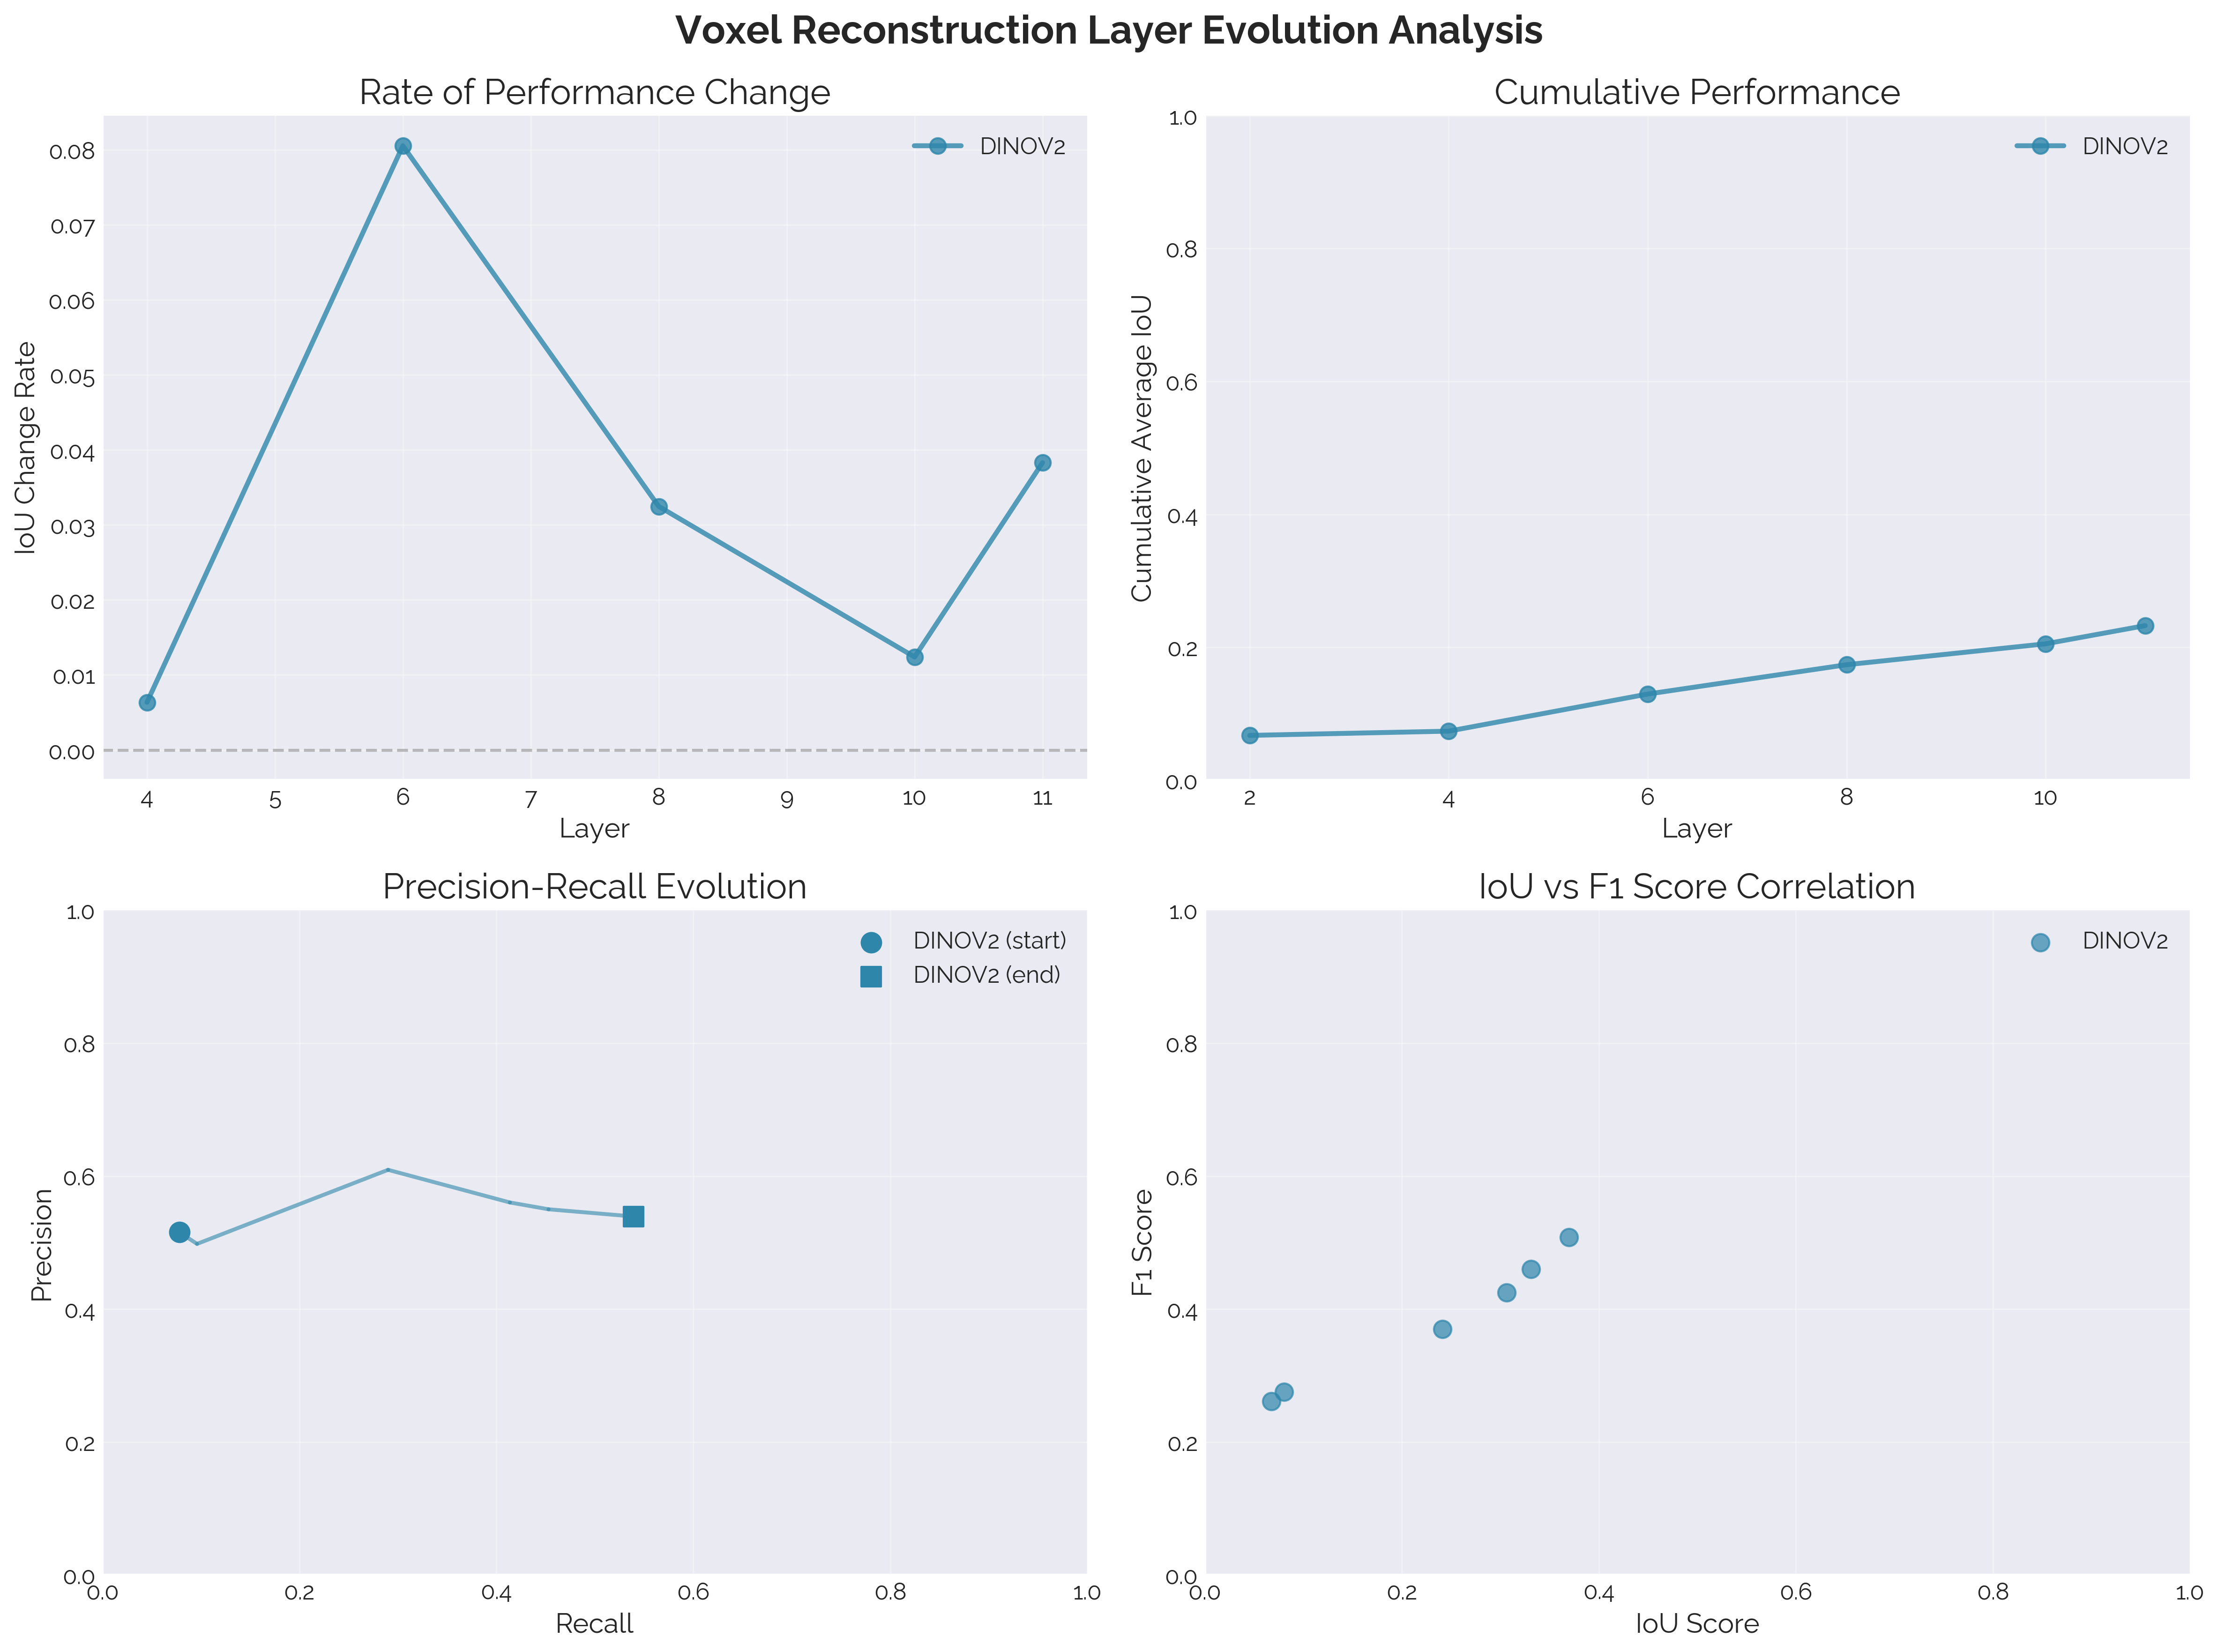

In [25]:
def analyze_voxel_layer_evolution(model_data: Dict, output_manager: OutputManager):
    """Analyze how voxel reconstruction quality evolves through layers"""
    
    fig, axes = plt.subplots(2, 2, figsize=VisualConfig.QUAD_FIG_SIZE)
    
    # evolution rate of the particular metric 
    ax_evolution = axes[0, 0]
    for model_name, data in model_data.items():
        iou_values = data['metrics']['iou']
        if len(iou_values) > 1:
            # rate of change?
            evolution_rate = np.diff(iou_values) / np.diff(data['layers'])
            ax_evolution.plot(data['layers'][1:], evolution_rate,
                            'o-', linewidth=VisualConfig.LINE_WIDTH,
                            markersize=VisualConfig.MARKER_SIZE,
                            color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                            label=model_name.upper(),
                            alpha=VisualConfig.ALPHA)
    
    ax_evolution.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax_evolution.set_xlabel('Layer')
    ax_evolution.set_ylabel('IoU Change Rate')
    ax_evolution.set_title('Rate of Performance Change')
    ax_evolution.legend()
    ax_evolution.grid(True, alpha=VisualConfig.GRID_ALPHA)
    
    ax_cumulative = axes[0, 1]
    for model_name, data in model_data.items():
        cumulative_iou = np.cumsum(data['metrics']['iou']) / np.arange(1, len(data['metrics']['iou']) + 1)
        ax_cumulative.plot(data['layers'], cumulative_iou,
                          'o-', linewidth=VisualConfig.LINE_WIDTH,
                          markersize=VisualConfig.MARKER_SIZE,
                          color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                          label=model_name.upper(),
                          alpha=VisualConfig.ALPHA)
    
    ax_cumulative.set_xlabel('Layer')
    ax_cumulative.set_ylabel('Cumulative Average IoU')
    ax_cumulative.set_title('Cumulative Performance')
    ax_cumulative.legend()
    ax_cumulative.grid(True, alpha=VisualConfig.GRID_ALPHA)
    ax_cumulative.set_ylim([0, 1])
    
    # precision / recall tradeoff 
    ax_pr = axes[1, 0]
    for model_name, data in model_data.items():
        precision = data['metrics']['precision']
        recall = data['metrics']['recall']
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(data['layers'])))
        
        for i in range(len(data['layers']) - 1):
            ax_pr.plot([recall[i], recall[i+1]], [precision[i], precision[i+1]],
                      color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                      alpha=0.6, linewidth=2)
        
        ax_pr.scatter(recall[0], precision[0], s=100, 
                     color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                     marker='o', label=f'{model_name.upper()} (start)')
        ax_pr.scatter(recall[-1], precision[-1], s=100,
                     color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                     marker='s', label=f'{model_name.upper()} (end)')
    
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title('Precision-Recall Evolution')
    ax_pr.legend()
    ax_pr.grid(True, alpha=VisualConfig.GRID_ALPHA)
    ax_pr.set_xlim([0, 1])
    ax_pr.set_ylim([0, 1])
    
    ax_corr = axes[1, 1]
    for model_name, data in model_data.items():
        metrics_array = np.array([
            data['metrics']['iou'],
            data['metrics']['precision'],
            data['metrics']['recall'],
            data['metrics']['f1']
        ])
        
        # iou vs f1 correlation 
        ax_corr.scatter(data['metrics']['iou'], data['metrics']['f1'],
                       s=80, alpha=0.7,
                       color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                       label=model_name.upper())
    
    ax_corr.set_xlabel('IoU Score')
    ax_corr.set_ylabel('F1 Score')
    ax_corr.set_title('IoU vs F1 Score Correlation')
    ax_corr.legend()
    ax_corr.grid(True, alpha=VisualConfig.GRID_ALPHA)
    ax_corr.set_xlim([0, 1])
    ax_corr.set_ylim([0, 1])
    
    plt.suptitle('Voxel Reconstruction Layer Evolution Analysis',
                fontsize=VisualConfig.TITLE_SIZE + 2, fontweight='bold')
    plt.tight_layout()
    
    output_manager.save_figure(fig, 'voxel_layer_evolution', save_subplots=True)
    plt.show()

# Analyze layer evolution
if voxel_model_data:
    analyze_voxel_layer_evolution(voxel_model_data, output_manager)

## 4. Viewpoint Estimation Analysis

### 4.1 Performance Analysis

Saved figure: final_analysis/figures/viewpoint_estimation_all_models_20250607_232056.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


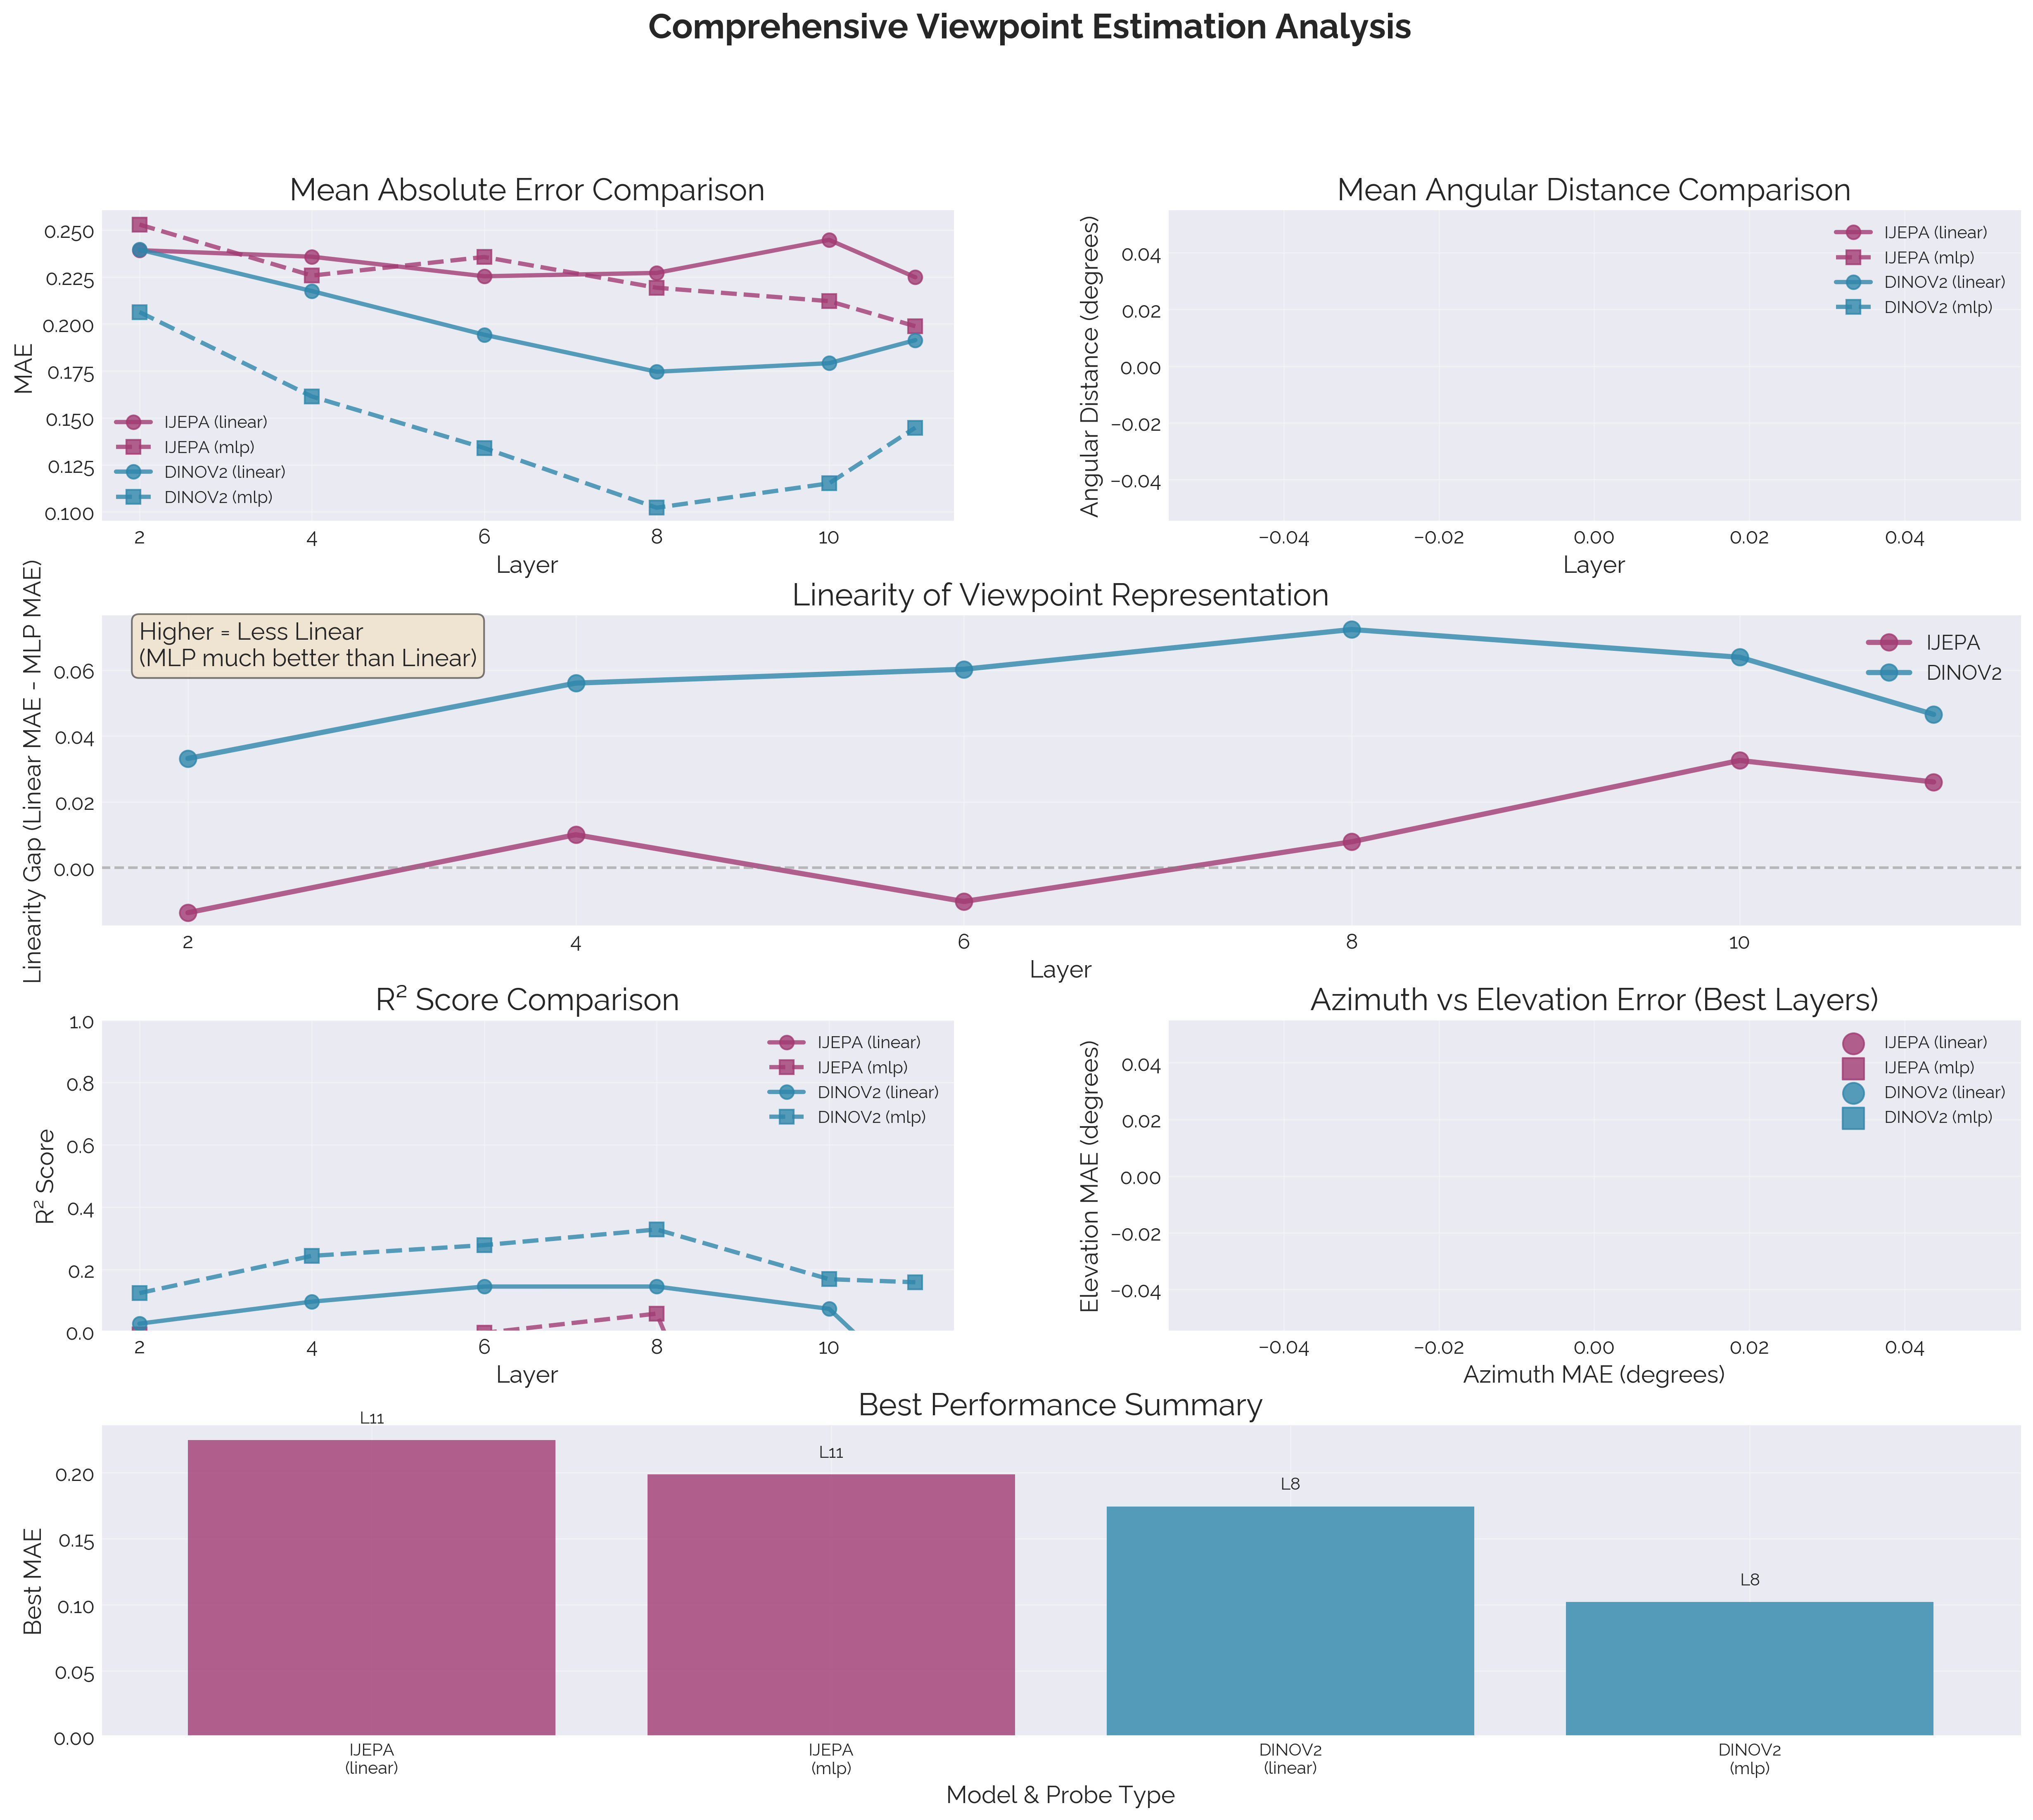

Saved data: final_analysis/data/viewpoint_estimation_metrics_20250607_232056.json
{'ijepa': {'linear': {'layers': array([ 2,  4,  6,  8, 10, 11]), 'metrics': {'mae': array([0.23925714, 0.23579021, 0.2253872 , 0.22716534, 0.24474929,
       0.22485104]), 'rmse': array([0.38685989, 0.37962449, 0.37116078, 0.36286426, 0.35609016,
       0.3615799 ]), 'r2': array([ -1.32487845,  -1.80505359,  -0.69588912,  -2.5594666 ,
       -12.77161789,  -2.69541192]), 'angular_distance': array([inf, inf, inf, inf, inf, inf]), 'azimuth_mae': array([inf, inf, inf, inf, inf, inf]), 'elevation_mae': array([inf, inf, inf, inf, inf, inf])}, 'experiment': ExperimentResult(name='ijepa_phase1_ijepa_viewpoint_probing', model='ijepa', task='viewpoint_estimation', results={'config': {'models': {'_target_': 'src.models.feature_extractor.FeatureExtractor', 'model_name': 'ijepa', 'checkpoint_path': None, 'device': 'cuda', 'cache_dir': 'cache\\models', 'feature_extraction': {'layers': [2, 4, 6, 8, 10, 11], 'feature_ty

In [35]:
def analyze_viewpoint_estimation_all_models(experiments: List[ExperimentResult],
                                           output_manager: OutputManager):
    """Comprehensive viewpoint estimation analysis for all models"""
    
    model_probe_data = {}
    
    for exp in experiments:
        if exp.model not in model_probe_data:
            model_probe_data[exp.model] = {}
        
        metrics_dict = exp.results.get('results', {})
        
        for probe_type in ['linear', 'mlp']:
            layers = []
            metrics = {
                'mae': [],
                'rmse': [],
                'r2': [],
                'angular_distance': [],
                'azimuth_mae': [],
                'elevation_mae': []
            }
            
            for layer_key, layer_data in metrics_dict.items():
                if layer_key.startswith('layer_') and probe_type in layer_data:
                    layer_num = int(layer_key.split('_')[1])
                    test_metrics = layer_data[probe_type].get('test_metrics', {})
                    
                    layers.append(layer_num)
                    metrics['mae'].append(test_metrics.get('mae', float('inf')))
                    metrics['rmse'].append(test_metrics.get('rmse', float('inf')))
                    metrics['r2'].append(test_metrics.get('r2', 0))
                    metrics['angular_distance'].append(test_metrics.get('angular_distance_mean', float('inf')))
                    metrics['azimuth_mae'].append(test_metrics.get('azimuth_mae', float('inf')))
                    metrics['elevation_mae'].append(test_metrics.get('elevation_mae', float('inf')))
            
            if layers:
                sorted_idx = np.argsort(layers)
                model_probe_data[exp.model][probe_type] = {
                    'layers': np.array(layers)[sorted_idx],
                    'metrics': {k: np.array(v)[sorted_idx] for k, v in metrics.items()},
                    'experiment': exp
                }
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.25)
    
    # MAE comparison
    ax_mae = fig.add_subplot(gs[0, 0])
    for model_name, probe_data in model_probe_data.items():
        for probe_type, data in probe_data.items():
            linestyle = '-' if probe_type == 'linear' else '--'
            ax_mae.plot(data['layers'], data['metrics']['mae'],
                       linestyle=linestyle, linewidth=VisualConfig.LINE_WIDTH,
                       marker='o' if probe_type == 'linear' else 's',
                       markersize=VisualConfig.MARKER_SIZE,
                       color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                       label=f'{model_name.upper()} ({probe_type})',
                       alpha=VisualConfig.ALPHA)
    
    ax_mae.set_xlabel('Layer')
    ax_mae.set_ylabel('MAE')
    ax_mae.set_title('Mean Absolute Error Comparison')
    ax_mae.legend(fontsize=VisualConfig.LEGEND_SIZE - 2)
    ax_mae.grid(True, alpha=VisualConfig.GRID_ALPHA)
    
    # Angular distance comparison
    ax_angular = fig.add_subplot(gs[0, 1])
    for model_name, probe_data in model_probe_data.items():
        for probe_type, data in probe_data.items():
            if 'angular_distance' in data['metrics']:
                linestyle = '-' if probe_type == 'linear' else '--'
                ax_angular.plot(data['layers'], data['metrics']['angular_distance'],
                               linestyle=linestyle, linewidth=VisualConfig.LINE_WIDTH,
                               marker='o' if probe_type == 'linear' else 's',
                               markersize=VisualConfig.MARKER_SIZE,
                               color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                               label=f'{model_name.upper()} ({probe_type})',
                               alpha=VisualConfig.ALPHA)
    
    ax_angular.set_xlabel('Layer')
    ax_angular.set_ylabel('Angular Distance (degrees)')
    ax_angular.set_title('Mean Angular Distance Comparison')
    ax_angular.legend(fontsize=VisualConfig.LEGEND_SIZE - 2)
    ax_angular.grid(True, alpha=VisualConfig.GRID_ALPHA)
    
    # Linearity gap analysis
    ax_linearity = fig.add_subplot(gs[1, :])
    for model_name, probe_data in model_probe_data.items():
        if 'linear' in probe_data and 'mlp' in probe_data:
            linear_data = probe_data['linear']
            mlp_data = probe_data['mlp']
            
            common_layers = np.intersect1d(linear_data['layers'], mlp_data['layers'])
            if len(common_layers) > 0:
                linear_mae = [linear_data['metrics']['mae'][np.where(linear_data['layers'] == l)[0][0]] 
                             for l in common_layers]
                mlp_mae = [mlp_data['metrics']['mae'][np.where(mlp_data['layers'] == l)[0][0]] 
                          for l in common_layers]
                
                linearity_gap = np.array(linear_mae) - np.array(mlp_mae)
                
                ax_linearity.plot(common_layers, linearity_gap,
                                 'o-', linewidth=VisualConfig.LINE_WIDTH * 1.2,
                                 markersize=VisualConfig.MARKER_SIZE * 1.2,
                                 color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                                 label=model_name.upper(),
                                 alpha=VisualConfig.ALPHA)
    
    ax_linearity.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax_linearity.set_xlabel('Layer', fontsize=VisualConfig.LABEL_SIZE)
    ax_linearity.set_ylabel('Linearity Gap (Linear MAE - MLP MAE)', fontsize=VisualConfig.LABEL_SIZE)
    ax_linearity.set_title('Linearity of Viewpoint Representation', fontsize=VisualConfig.TITLE_SIZE)
    ax_linearity.legend(fontsize=VisualConfig.LEGEND_SIZE)
    ax_linearity.grid(True, alpha=VisualConfig.GRID_ALPHA)
    
    ax_linearity.text(0.02, 0.98, 'Higher = Less Linear\n(MLP much better than Linear)',
                     transform=ax_linearity.transAxes,
                     verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # R^2 score comparison
    ax_r2 = fig.add_subplot(gs[2, 0])
    for model_name, probe_data in model_probe_data.items():
        for probe_type, data in probe_data.items():
            if 'r2' in data['metrics']:
                linestyle = '-' if probe_type == 'linear' else '--'
                ax_r2.plot(data['layers'], data['metrics']['r2'],
                          linestyle=linestyle, linewidth=VisualConfig.LINE_WIDTH,
                          marker='o' if probe_type == 'linear' else 's',
                          markersize=VisualConfig.MARKER_SIZE,
                          color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                          label=f'{model_name.upper()} ({probe_type})',
                          alpha=VisualConfig.ALPHA)
    
    ax_r2.set_xlabel('Layer')
    ax_r2.set_ylabel('R² Score')
    ax_r2.set_title('R² Score Comparison')
    ax_r2.legend(fontsize=VisualConfig.LEGEND_SIZE - 2)
    ax_r2.grid(True, alpha=VisualConfig.GRID_ALPHA)
    ax_r2.set_ylim([0, 1])
    
    # Azimuth vs Elevation error
    ax_az_el = fig.add_subplot(gs[2, 1])
    for model_name, probe_data in model_probe_data.items():
        for probe_type, data in probe_data.items():
            if 'azimuth_mae' in data['metrics'] and 'elevation_mae' in data['metrics']:
                best_idx = np.argmin(data['metrics']['mae'])
                marker = 'o' if probe_type == 'linear' else 's'
                ax_az_el.scatter(data['metrics']['azimuth_mae'][best_idx],
                               data['metrics']['elevation_mae'][best_idx],
                               s=150, marker=marker,
                               color=VisualConfig.MODEL_COLORS.get(model_name, '#333'),
                               alpha=VisualConfig.ALPHA,
                               label=f'{model_name.upper()} ({probe_type})')
    
    ax_az_el.set_xlabel('Azimuth MAE (degrees)')
    ax_az_el.set_ylabel('Elevation MAE (degrees)')
    ax_az_el.set_title('Azimuth vs Elevation Error (Best Layers)')
    ax_az_el.legend(fontsize=VisualConfig.LEGEND_SIZE - 2)
    ax_az_el.grid(True, alpha=VisualConfig.GRID_ALPHA)
    
    ax_summary = fig.add_subplot(gs[3, :])
    summary_data = []
    models = []
    
    for model_name, probe_data in model_probe_data.items():
        for probe_type, data in probe_data.items():
            best_idx = np.argmin(data['metrics']['mae'])
            best_layer = data['layers'][best_idx]
            best_mae = data['metrics']['mae'][best_idx]
            
            summary_data.append({
                'model': model_name.upper(),
                'probe': probe_type,
                'layer': best_layer,
                'mae': best_mae
            })
            models.append(f'{model_name.upper()}\n({probe_type})')
    
    x_pos = np.arange(len(models))
    mae_values = [d['mae'] for d in summary_data]
    colors = [VisualConfig.MODEL_COLORS.get(d['model'].lower(), '#333') for d in summary_data]
    
    bars = ax_summary.bar(x_pos, mae_values, color=colors, alpha=VisualConfig.ALPHA)
    
    for i, (bar, data) in enumerate(zip(bars, summary_data)):
        height = bar.get_height()
        ax_summary.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'L{data["layer"]}',
                       ha='center', va='bottom', fontsize=10)
    
    ax_summary.set_xlabel('Model & Probe Type')
    ax_summary.set_ylabel('Best MAE')
    ax_summary.set_title('Best Performance Summary')
    ax_summary.set_xticks(x_pos)
    ax_summary.set_xticklabels(models, fontsize=10)
    ax_summary.grid(True, alpha=VisualConfig.GRID_ALPHA, axis='y')
    
    plt.suptitle('Comprehensive Viewpoint Estimation Analysis',
                fontsize=VisualConfig.TITLE_SIZE + 2, fontweight='bold')
    plt.tight_layout()
    
    output_manager.save_figure(fig, 'viewpoint_estimation_all_models', save_subplots=True)
    plt.show()
    
    raw_data = {}
    for model_name, probe_data in model_probe_data.items():
        raw_data[model_name] = {}
        for probe_type, data in probe_data.items():
            best_idx = np.argmin(data['metrics']['mae'])
            raw_data[model_name][probe_type] = {
                'layers': data['layers'].tolist(),
                'metrics': {k: v.tolist() for k, v in data['metrics'].items()},
                'best_layer': int(data['layers'][best_idx]),
                'best_mae': float(data['metrics']['mae'][best_idx])
            }
    
    output_manager.save_data(raw_data, 'viewpoint_estimation_metrics')
    
    return model_probe_data

viewpoint_model_data = analyze_viewpoint_estimation_all_models(
    categorized_experiments['viewpoint_estimation'],
    output_manager
)
print(viewpoint_model_data)

### 4.2 Viewpoint Predictions Visualization

In [ ]:
def create_viewpoint_error_analysis(model_probe_data: Dict, loader: ExperimentLoader,
                                   output_manager: OutputManager):
    """Create visualizations of the error with advanced stuff"""
    
    best_configs = {}
    for model_name, probe_data in model_probe_data.items():
        best_mae = float('inf')
        best_config = None
        
        for probe_type, data in probe_data.items():
            min_idx = np.argmin(data['metrics']['mae'])
            if data['metrics']['mae'][min_idx] < best_mae:
                best_mae = data['metrics']['mae'][min_idx]
                best_config = {
                    'model': model_name,
                    'probe_type': probe_type,
                    'layer': data['layers'][min_idx],
                    'experiment': data['experiment'],
                    'mae': best_mae
                }
        
        if best_config:
            best_configs[model_name] = best_config
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, len(best_configs), hspace=0.3, wspace=0.3)
    
    for idx, (model_name, config) in enumerate(best_configs.items()):
        try:
            exp = config['experiment']
            probe_files = loader.get_probe_files(exp)
            feature_files = loader.get_feature_files(exp)
            
            if config['probe_type'] not in probe_files:
                continue
            if config['layer'] not in probe_files[config['probe_type']]:
                continue
                
            probe_path = probe_files[config['probe_type']][config['layer']]
            features_path = feature_files[config['layer']]['test']
            
            probe_state = torch.load(probe_path, map_location=device)
            original_config = probe_state.get('probe_config', {
                'type': config['probe_type'],
                'input_dim': 768,
                'output_dim': 2,
                'task_type': 'regression'
            })
            
            if config['probe_type'] == 'mlp' and 'hidden_dims' not in original_config:
                original_config['hidden_dims'] = [256]
            
            probe = create_probe(original_config)
            probe.load_state_dict(probe_state['model_state_dict'])
            probe.to(device).eval()
            
            with open(features_path, 'rb') as f:
                test_data = pickle.load(f)
            
            n_samples = min(1000, len(test_data['features']))
            features = torch.tensor(test_data['features'][:n_samples])
            targets = torch.tensor(test_data['targets'][:n_samples])
            
            with torch.no_grad():
                predictions = probe(features.to(device)).cpu().numpy()
            
            targets = targets.numpy()
            
            pred_azimuth = (predictions[:, 0] + 1) * 180
            true_azimuth = (targets[:, 0] + 1) * 180
            pred_elevation = predictions[:, 1] * 90
            true_elevation = targets[:, 1] * 90
            
            az_error = np.abs(pred_azimuth - true_azimuth)
            az_error = np.minimum(az_error, 360 - az_error)
            el_error = np.abs(pred_elevation - true_elevation)
            
            ax_az = fig.add_subplot(gs[0, idx])
            scatter = ax_az.scatter(true_azimuth, pred_azimuth, c=az_error,
                                   cmap='viridis', alpha=0.5, s=10)
            ax_az.plot([0, 360], [0, 360], 'r--', alpha=0.5, linewidth=1)
            ax_az.set_xlabel('True Azimuth (°)')
            ax_az.set_ylabel('Predicted Azimuth (°)')
            ax_az.set_title(f'{model_name.upper()}\n{config["probe_type"]} L{config["layer"]}')
            ax_az.grid(True, alpha=VisualConfig.GRID_ALPHA)
            
            ax_el = fig.add_subplot(gs[1, idx])
            scatter = ax_el.scatter(true_elevation, pred_elevation, c=el_error,
                                   cmap='viridis', alpha=0.5, s=10)
            ax_el.plot([-90, 90], [-90, 90], 'r--', alpha=0.5, linewidth=1)
            ax_el.set_xlabel('True Elevation (°)')
            ax_el.set_ylabel('Predicted Elevation (°)')
            ax_el.set_title(f'MAE: {config["mae"]:.2f}°')
            ax_el.grid(True, alpha=VisualConfig.GRID_ALPHA)
            
        except Exception as e:
            print(f"Could not create visualization for {model_name}: {e}")
            continue
    
    plt.suptitle('Viewpoint Prediction Error Analysis (Best Configurations)',
                fontsize=VisualConfig.TITLE_SIZE + 2, fontweight='bold')
    
    output_manager.save_figure(fig, 'viewpoint_error_analysis', save_subplots=True)
    plt.show()
    
    create_3d_viewpoint_sphere(best_configs, loader, output_manager)

def create_3d_viewpoint_sphere(best_configs: Dict, loader: ExperimentLoader,
                               output_manager: OutputManager, n: Optional=10):
    """Create 3D sphere visualization of viewpoint errors"""
    
    best_model = min(best_configs.items(), key=lambda x: x[1]['mae'])
    model_name, config = best_model
    
    try:
        exp = config['experiment']
        probe_files = loader.get_probe_files(exp)
        feature_files = loader.get_feature_files(exp)
        
        probe_path = probe_files[config['probe_type']][config['layer']]
        features_path = feature_files[config['layer']]['test']
        
        probe_state = torch.load(probe_path, map_location=device)
        original_config = probe_state.get('probe_config', {
            'type': config['probe_type'],
            'input_dim': 768,
            'output_dim': 2,
            'task_type': 'regression'
        })
        
        if config['probe_type'] == 'mlp' and 'hidden_dims' not in original_config:
            original_config['hidden_dims'] = [256]
        
        probe = create_probe(original_config)
        probe.load_state_dict(probe_state['model_state_dict'])
        probe.to(device).eval()
        
        with open(features_path, 'rb') as f:
            test_data = pickle.load(f)
        
        n_samples = min(500, len(test_data['features']))
        features = torch.tensor(test_data['features'][:n_samples])
        targets = torch.tensor(test_data['targets'][:n_samples])
        
        with torch.no_grad():
            predictions = probe(features.to(device)).cpu().numpy()
        
        targets = targets.numpy()
        
        def viewpoint_to_xyz(azimuth, elevation, radius=1):
            az_rad = np.deg2rad(azimuth)
            el_rad = np.deg2rad(elevation)
            x = radius * np.cos(el_rad) * np.cos(az_rad)
            y = radius * np.cos(el_rad) * np.sin(az_rad)
            z = radius * np.sin(el_rad)
            return x, y, z
        
        true_az = (targets[:, 0] + 1) * 180
        true_el = targets[:, 1] * 90
        pred_az = (predictions[:, 0] + 1) * 180
        pred_el = predictions[:, 1] * 90
        
        true_x, true_y, true_z = viewpoint_to_xyz(true_az, true_el)
        pred_x, pred_y, pred_z = viewpoint_to_xyz(pred_az, pred_el)
        
        errors = np.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2 + (pred_z - true_z)**2)
        
        fig = go.Figure()
        
        u = np.linspace(0, 2 * np.pi, 50)
        v = np.linspace(0, np.pi, 50)
        sphere_x = np.outer(np.cos(u), np.sin(v))
        sphere_y = np.outer(np.sin(u), np.sin(v))
        sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
        
        fig.add_trace(go.Surface(
            x=sphere_x, y=sphere_y, z=sphere_z,
            opacity=0.1, colorscale='gray',
            showscale=False, name='Unit Sphere'
        ))
        
        for i in range(n):
            color = plt.cm.viridis(errors[i] / errors.max())
            color_rgb = f'rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)})'
            
            fig.add_trace(go.Scatter3d(
                x=[true_x[i], pred_x[i]],
                y=[true_y[i], pred_y[i]],
                z=[true_z[i], pred_z[i]],
                mode='lines+markers',
                line=dict(color=color_rgb, width=2),
                marker=dict(size=[3, 5], color=['blue', 'red']),
                showlegend=False,
                hovertemplate=f'Error: {errors[i]:.3f}<br>True: ({true_az[i]:.1f}°, {true_el[i]:.1f}°)<br>Pred: ({pred_az[i]:.1f}°, {pred_el[i]:.1f}°)'
            ))
        
        fig.update_layout(
            title=dict(
                text=f'Viewpoint Prediction on Unit Sphere (n={n}) - {model_name.upper()} ({config["probe_type"]} L{config["layer"]})',
                font=dict(size=VisualConfig.TITLE_SIZE, family=VisualConfig.FONT_FAMILY)
            ),
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='cube',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
            ),
            width=1000,
            height=800,
            showlegend=True
        )
        
        fig.add_trace(go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode='markers',
            marker=dict(size=8, color='blue'),
            name='True Viewpoint'
        ))
        fig.add_trace(go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode='markers',
            marker=dict(size=8, color='red'),
            name='Predicted Viewpoint'
        ))
        
        output_manager.save_plotly_figure(fig, 'viewpoint_sphere_best_model')
        fig.show()
        
    except Exception as e:
        print(f"Could not create sphere visualization: {e}")

if viewpoint_model_data:
    viewpoint_model_data_no_ijepa = {key: value for key, value in voxel_model_data.items() if key != "ijepa"}
    create_viewpoint_error_analysis(viewpoint_model_data_no_ijepa, loader, output_manager)

{'layers': array([ 2,  4,  6,  8, 10, 11]), 'metrics': {'iou': array([0.06756099, 0.08029944, 0.24138193, 0.30633047, 0.33113927,
       0.36944133]), 'precision': array([0.51553851, 0.49811774, 0.60952091, 0.56041777, 0.55016923,
       0.53936315]), 'recall': array([0.07845592, 0.09623108, 0.29018933, 0.41384059, 0.45306066,
       0.53921551]), 'f1': array([0.26155367, 0.27515927, 0.3699207 , 0.42502952, 0.46032545,
       0.5083974 ])}, 'experiment': ExperimentResult(name='phase2_dinov2_voxel_reconstruction', model='dinov2', task='voxel_reconstruction', results={'config': {'models': {'_target_': 'src.models.feature_extractor.FeatureExtractor', 'model_name': 'dinov2', 'checkpoint_path': None, 'device': 'cuda', 'cache_dir': None, 'feature_extraction': {'layers': [2, 4, 6, 8, 10, 11], 'feature_type': 'cls_token', 'return_all_layers': True}, 'model_config': {'output_hidden_states': True}}, 'datasets': {'_target_': 'src.datasets.shapenet_voxel_meshes.ShapeNetVoxelMeshes', 'name': 'shape

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## 5. Comparative Analysis of Models


### 5.1 Cross-Task Comparison

Saved figure: final_analysis/figures/cross_task_comparison_20250607_232056.png


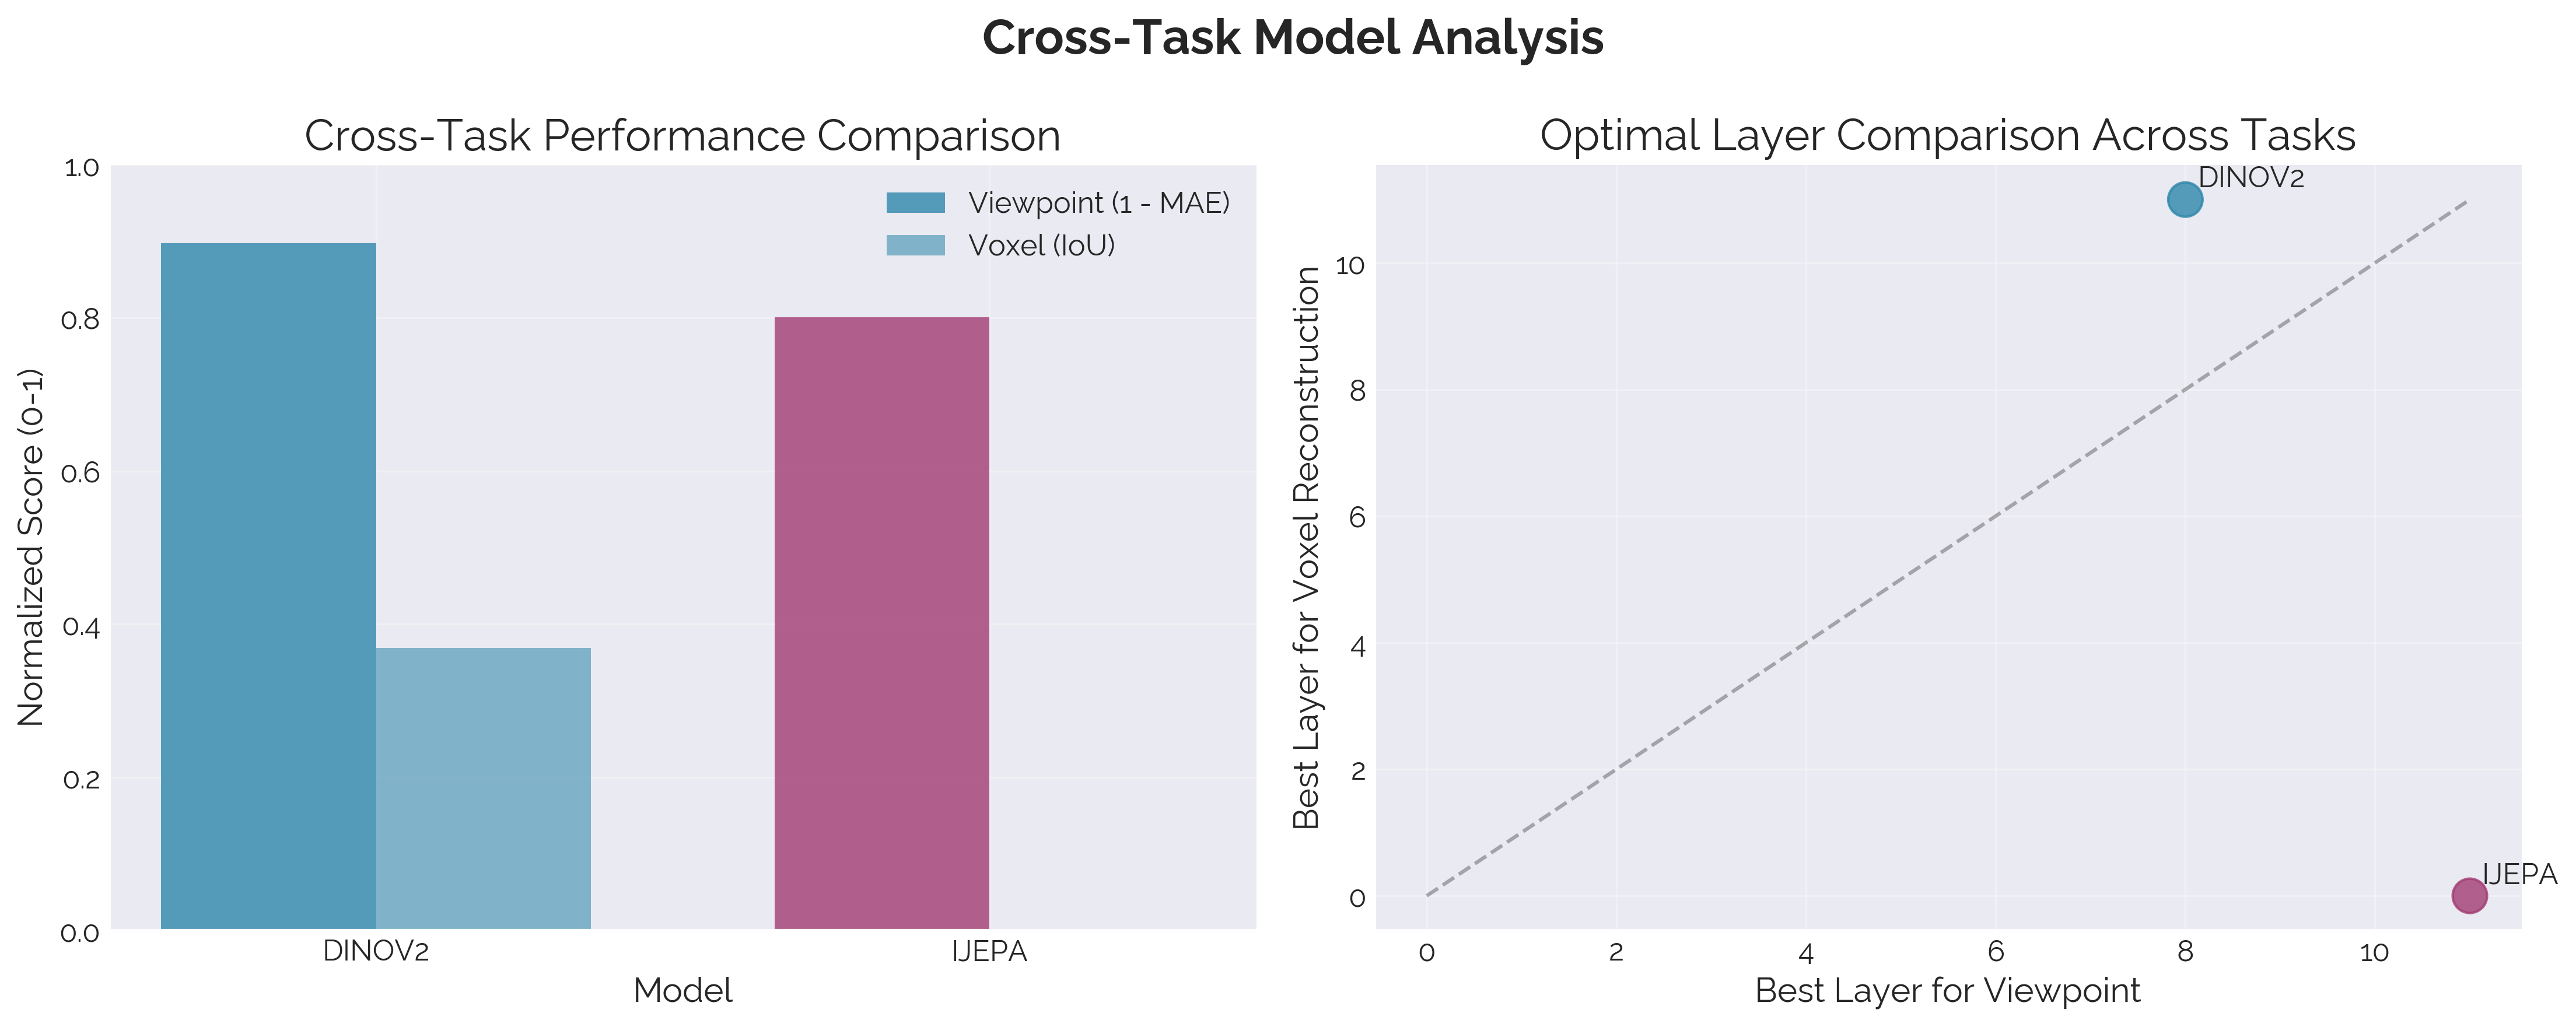

Saved data: final_analysis/data/cross_task_performance_20250607_232056.json


In [28]:
def create_cross_task_comparison(all_experiments: Dict[str, ExperimentResult],
                                output_manager: OutputManager):
    """Compare model performance across both tasks"""
    
    performance_data = {}
    
    for exp in all_experiments.values():
        if exp.model not in performance_data:
            performance_data[exp.model] = {}
        
        best_layer, best_metric = exp.get_best_layer()
        
        if exp.task == 'viewpoint_estimation':
            performance_data[exp.model]['viewpoint'] = {
                'best_mae': best_metric,
                'best_layer': best_layer
            }
        else:  # voxel_reconstruction
            performance_data[exp.model]['voxel'] = {
                'best_iou': best_metric,
                'best_layer': best_layer
            }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=VisualConfig.DOUBLE_FIG_SIZE)
    
    models = list(performance_data.keys())
    viewpoint_scores = []
    voxel_scores = []
    
    for model in models:
        viewpoint_mae = performance_data[model].get('viewpoint', {}).get('best_mae', 1.0)
        voxel_iou = performance_data[model].get('voxel', {}).get('best_iou', 0.0)
        
        viewpoint_score = 1.0 - min(viewpoint_mae, 1.0)
        viewpoint_scores.append(viewpoint_score)
        voxel_scores.append(voxel_iou)
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, viewpoint_scores, width, label='Viewpoint (1 - MAE)',
                    color=[VisualConfig.MODEL_COLORS.get(m, '#333') for m in models],
                    alpha=VisualConfig.ALPHA)
    bars2 = ax1.bar(x + width/2, voxel_scores, width, label='Voxel (IoU)',
                    color=[VisualConfig.MODEL_COLORS.get(m, '#333') for m in models],
                    alpha=VisualConfig.ALPHA * 0.7)
    
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Normalized Score (0-1)')
    ax1.set_title('Cross-Task Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.upper() for m in models])
    ax1.legend()
    ax1.grid(True, alpha=VisualConfig.GRID_ALPHA, axis='y')
    ax1.set_ylim([0, 1])
    
    viewpoint_layers = [performance_data[m].get('viewpoint', {}).get('best_layer', 0) for m in models]
    voxel_layers = [performance_data[m].get('voxel', {}).get('best_layer', 0) for m in models]
    
    ax2.scatter(viewpoint_layers, voxel_layers,
               s=200, alpha=VisualConfig.ALPHA,
               c=[VisualConfig.MODEL_COLORS.get(m, '#333') for m in models])
    
    for i, model in enumerate(models):
        ax2.annotate(model.upper(), (viewpoint_layers[i], voxel_layers[i]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=VisualConfig.LABEL_SIZE - 2)
    
    max_layer = max(max(viewpoint_layers), max(voxel_layers))
    ax2.plot([0, max_layer], [0, max_layer], 'k--', alpha=0.3)
    
    ax2.set_xlabel('Best Layer for Viewpoint')
    ax2.set_ylabel('Best Layer for Voxel Reconstruction')
    ax2.set_title('Optimal Layer Comparison Across Tasks')
    ax2.grid(True, alpha=VisualConfig.GRID_ALPHA)
    
    plt.suptitle('Cross-Task Model Analysis', fontsize=VisualConfig.TITLE_SIZE + 2, fontweight='bold')
    plt.tight_layout()
    
    output_manager.save_figure(fig, 'cross_task_comparison')
    plt.show()
    
    output_manager.save_data(performance_data, 'cross_task_performance')

create_cross_task_comparison(all_experiments, output_manager)

### 5.2 Model Architecture Impact Analysis

Saved figure: final_analysis/figures/architecture_impact_analysis_20250607_232056.png


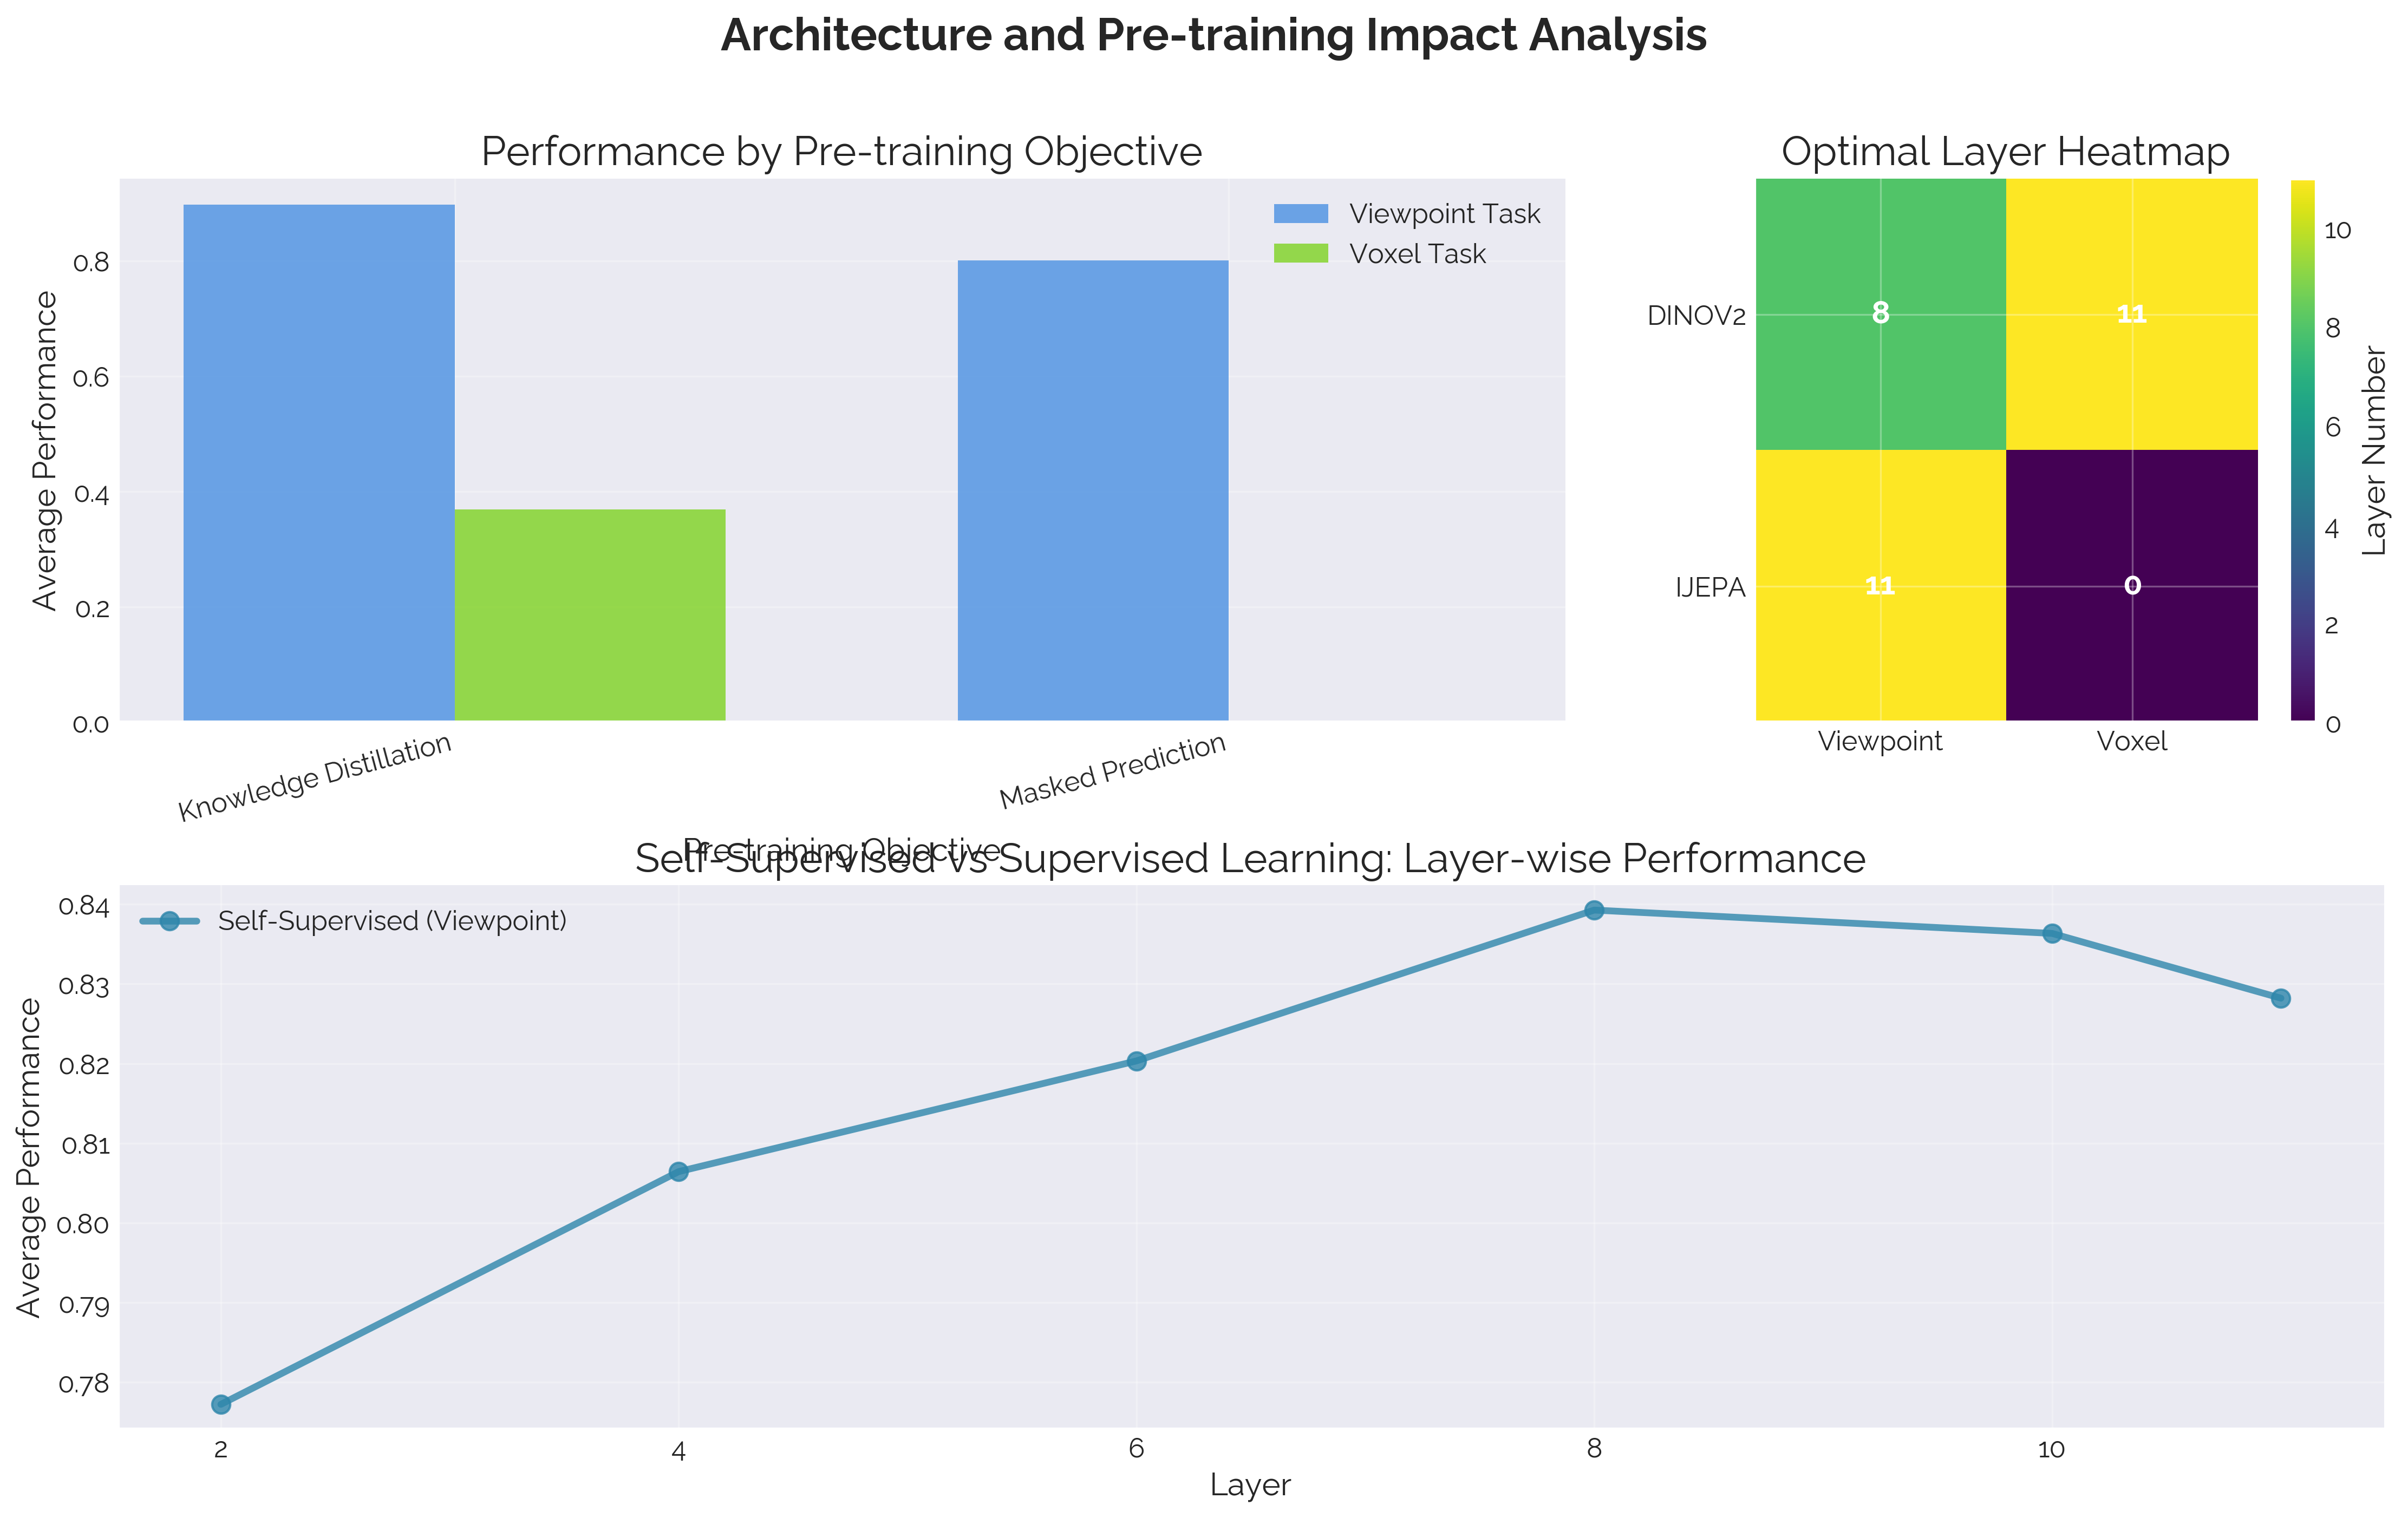

In [29]:
def analyze_architecture_impact(categorized_experiments: Dict, output_manager: OutputManager):
    """Analyze how different pre-training objectives affect 3D understanding"""
    
    model_categories = {
        'Self-Supervised': ['dinov2', 'ijepa', 'mocov3'],
        'Supervised': ['supervised_vit']
    }
    
    architecture_features = {
        'dinov2': {'type': 'Self-Distillation', 'objective': 'Knowledge Distillation'},
        'ijepa': {'type': 'Predictive', 'objective': 'Masked Prediction'},
        'supervised_vit': {'type': 'Supervised', 'objective': 'Classification'}
    }
    
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    ax_objective = fig.add_subplot(gs[0, :2])
    
    objective_performance = {}
    for model, exps in categorized_experiments['by_model'].items():
        obj = architecture_features.get(model, {}).get('objective', 'Unknown')
        if obj not in objective_performance:
            objective_performance[obj] = {'viewpoint': [], 'voxel': []}
        
        for exp in exps:
            best_layer, best_metric = exp.get_best_layer()
            if exp.task == 'viewpoint_estimation':
                objective_performance[obj]['viewpoint'].append(1 - min(best_metric, 1.0))
            else:
                objective_performance[obj]['voxel'].append(best_metric)
    
    objectives = list(objective_performance.keys())
    x = np.arange(len(objectives))
    width = 0.35
    
    viewpoint_means = [np.mean(objective_performance[obj]['viewpoint']) if objective_performance[obj]['viewpoint'] else 0 
                      for obj in objectives]
    voxel_means = [np.mean(objective_performance[obj]['voxel']) if objective_performance[obj]['voxel'] else 0 
                  for obj in objectives]
    
    bars1 = ax_objective.bar(x - width/2, viewpoint_means, width, label='Viewpoint Task',
                            color=VisualConfig.PROBE_COLORS['linear'], alpha=VisualConfig.ALPHA)
    bars2 = ax_objective.bar(x + width/2, voxel_means, width, label='Voxel Task',
                            color=VisualConfig.PROBE_COLORS['voxel'], alpha=VisualConfig.ALPHA)
    
    ax_objective.set_xlabel('Pre-training Objective')
    ax_objective.set_ylabel('Average Performance')
    ax_objective.set_title('Performance by Pre-training Objective')
    ax_objective.set_xticks(x)
    ax_objective.set_xticklabels(objectives, rotation=15, ha='right')
    ax_objective.legend()
    ax_objective.grid(True, alpha=VisualConfig.GRID_ALPHA, axis='y')
    
    ax_heatmap = fig.add_subplot(gs[0, 2])
    
    models = list(categorized_experiments['by_model'].keys())
    tasks = ['viewpoint', 'voxel']
    layer_matrix = np.zeros((len(models), len(tasks)))
    
    for i, model in enumerate(models):
        for exp in categorized_experiments['by_model'][model]:
            best_layer, _ = exp.get_best_layer()
            j = 0 if exp.task == 'viewpoint_estimation' else 1
            layer_matrix[i, j] = best_layer
    
    im = ax_heatmap.imshow(layer_matrix, cmap='viridis', aspect='auto')
    ax_heatmap.set_xticks(np.arange(len(tasks)))
    ax_heatmap.set_yticks(np.arange(len(models)))
    ax_heatmap.set_xticklabels(['Viewpoint', 'Voxel'])
    ax_heatmap.set_yticklabels([m.upper() for m in models])
    ax_heatmap.set_title('Optimal Layer Heatmap')
    
    for i in range(len(models)):
        for j in range(len(tasks)):
            text = ax_heatmap.text(j, i, f'{int(layer_matrix[i, j])}',
                                  ha='center', va='center', color='white', fontweight='bold')
    
    plt.colorbar(im, ax=ax_heatmap, label='Layer Number')
    
    ax_comparison = fig.add_subplot(gs[1, :])
    
    category_data = {'Self-Supervised': {'layers': [], 'viewpoint': [], 'voxel': []},
                    'Supervised': {'layers': [], 'viewpoint': [], 'voxel': []}}
    
    for model, exps in categorized_experiments['by_model'].items():
        category = 'Supervised' if model == 'supervised_vit' else 'Self-Supervised'
        
        for exp in exps:
            results = exp.results.get('results', {})
            for layer_key, layer_data in results.items():
                if layer_key.startswith('layer_'):
                    layer_num = int(layer_key.split('_')[1])
                    
                    if exp.task == 'viewpoint_estimation':
                        mae_values = []
                        for probe_type in ['linear', 'mlp']:
                            if probe_type in layer_data:
                                mae = layer_data[probe_type].get('test_metrics', {}).get('mae', 1.0)
                                mae_values.append(mae)
                        if mae_values:
                            category_data[category]['layers'].append(layer_num)
                            category_data[category]['viewpoint'].append(1 - min(mae_values))
                    else:
                        if 'voxel' in layer_data:
                            iou = layer_data['voxel'].get('test_metrics', {}).get('voxel_iou', 0)
                            category_data[category]['layers'].append(layer_num)
                            category_data[category]['voxel'].append(iou)
    
    for category, data in category_data.items():
        if data['viewpoint']:
            unique_layers = sorted(set(data['layers']))
            avg_viewpoint = []
            for layer in unique_layers:
                layer_indices = [i for i, l in enumerate(data['layers']) if l == layer]
                if 'viewpoint' in data and any(i < len(data['viewpoint']) for i in layer_indices):
                    avg = np.mean([data['viewpoint'][i] for i in layer_indices if i < len(data['viewpoint'])])
                    avg_viewpoint.append(avg)
                else:
                    avg_viewpoint.append(0)
            
            linestyle = '-' if category == 'Self-Supervised' else '--'
            ax_comparison.plot(unique_layers, avg_viewpoint,
                             linestyle=linestyle, linewidth=VisualConfig.LINE_WIDTH * 1.2,
                             marker='o', markersize=VisualConfig.MARKER_SIZE,
                             label=f'{category} (Viewpoint)',
                             alpha=VisualConfig.ALPHA)
    
    ax_comparison.set_xlabel('Layer')
    ax_comparison.set_ylabel('Average Performance')
    ax_comparison.set_title('Self-Supervised vs Supervised Learning: Layer-wise Performance')
    ax_comparison.legend()
    ax_comparison.grid(True, alpha=VisualConfig.GRID_ALPHA)
    
    plt.suptitle('Architecture and Pre-training Impact Analysis',
                fontsize=VisualConfig.TITLE_SIZE + 2, fontweight='bold')
    plt.tight_layout()
    
    output_manager.save_figure(fig, 'architecture_impact_analysis')
    plt.show()

analyze_architecture_impact(categorized_experiments, output_manager)

### 5.3 Layer-Wise Evolution Analysis

Saved figure: final_analysis/figures/performance_heatmap_dinov2_voxel_reconstruction_20250607_232056.png


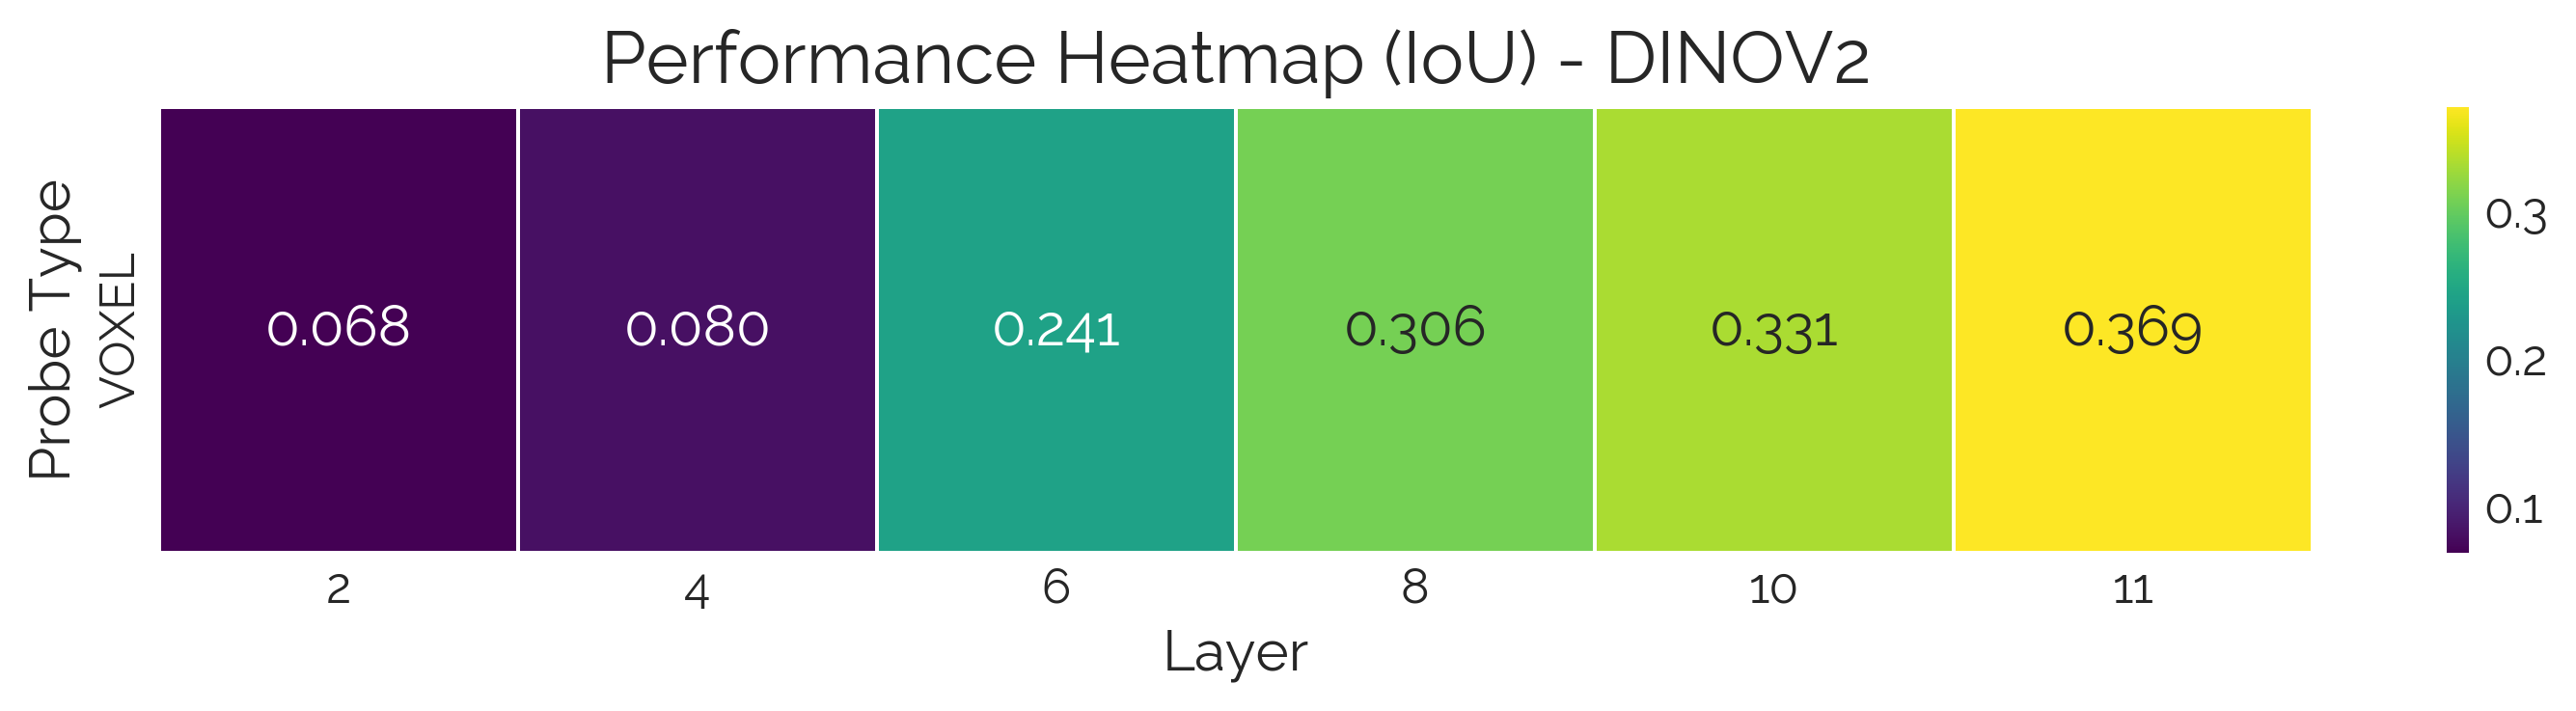

Saved figure: final_analysis/figures/layer_group_trends_dinov2_voxel_reconstruction_20250607_232056.png


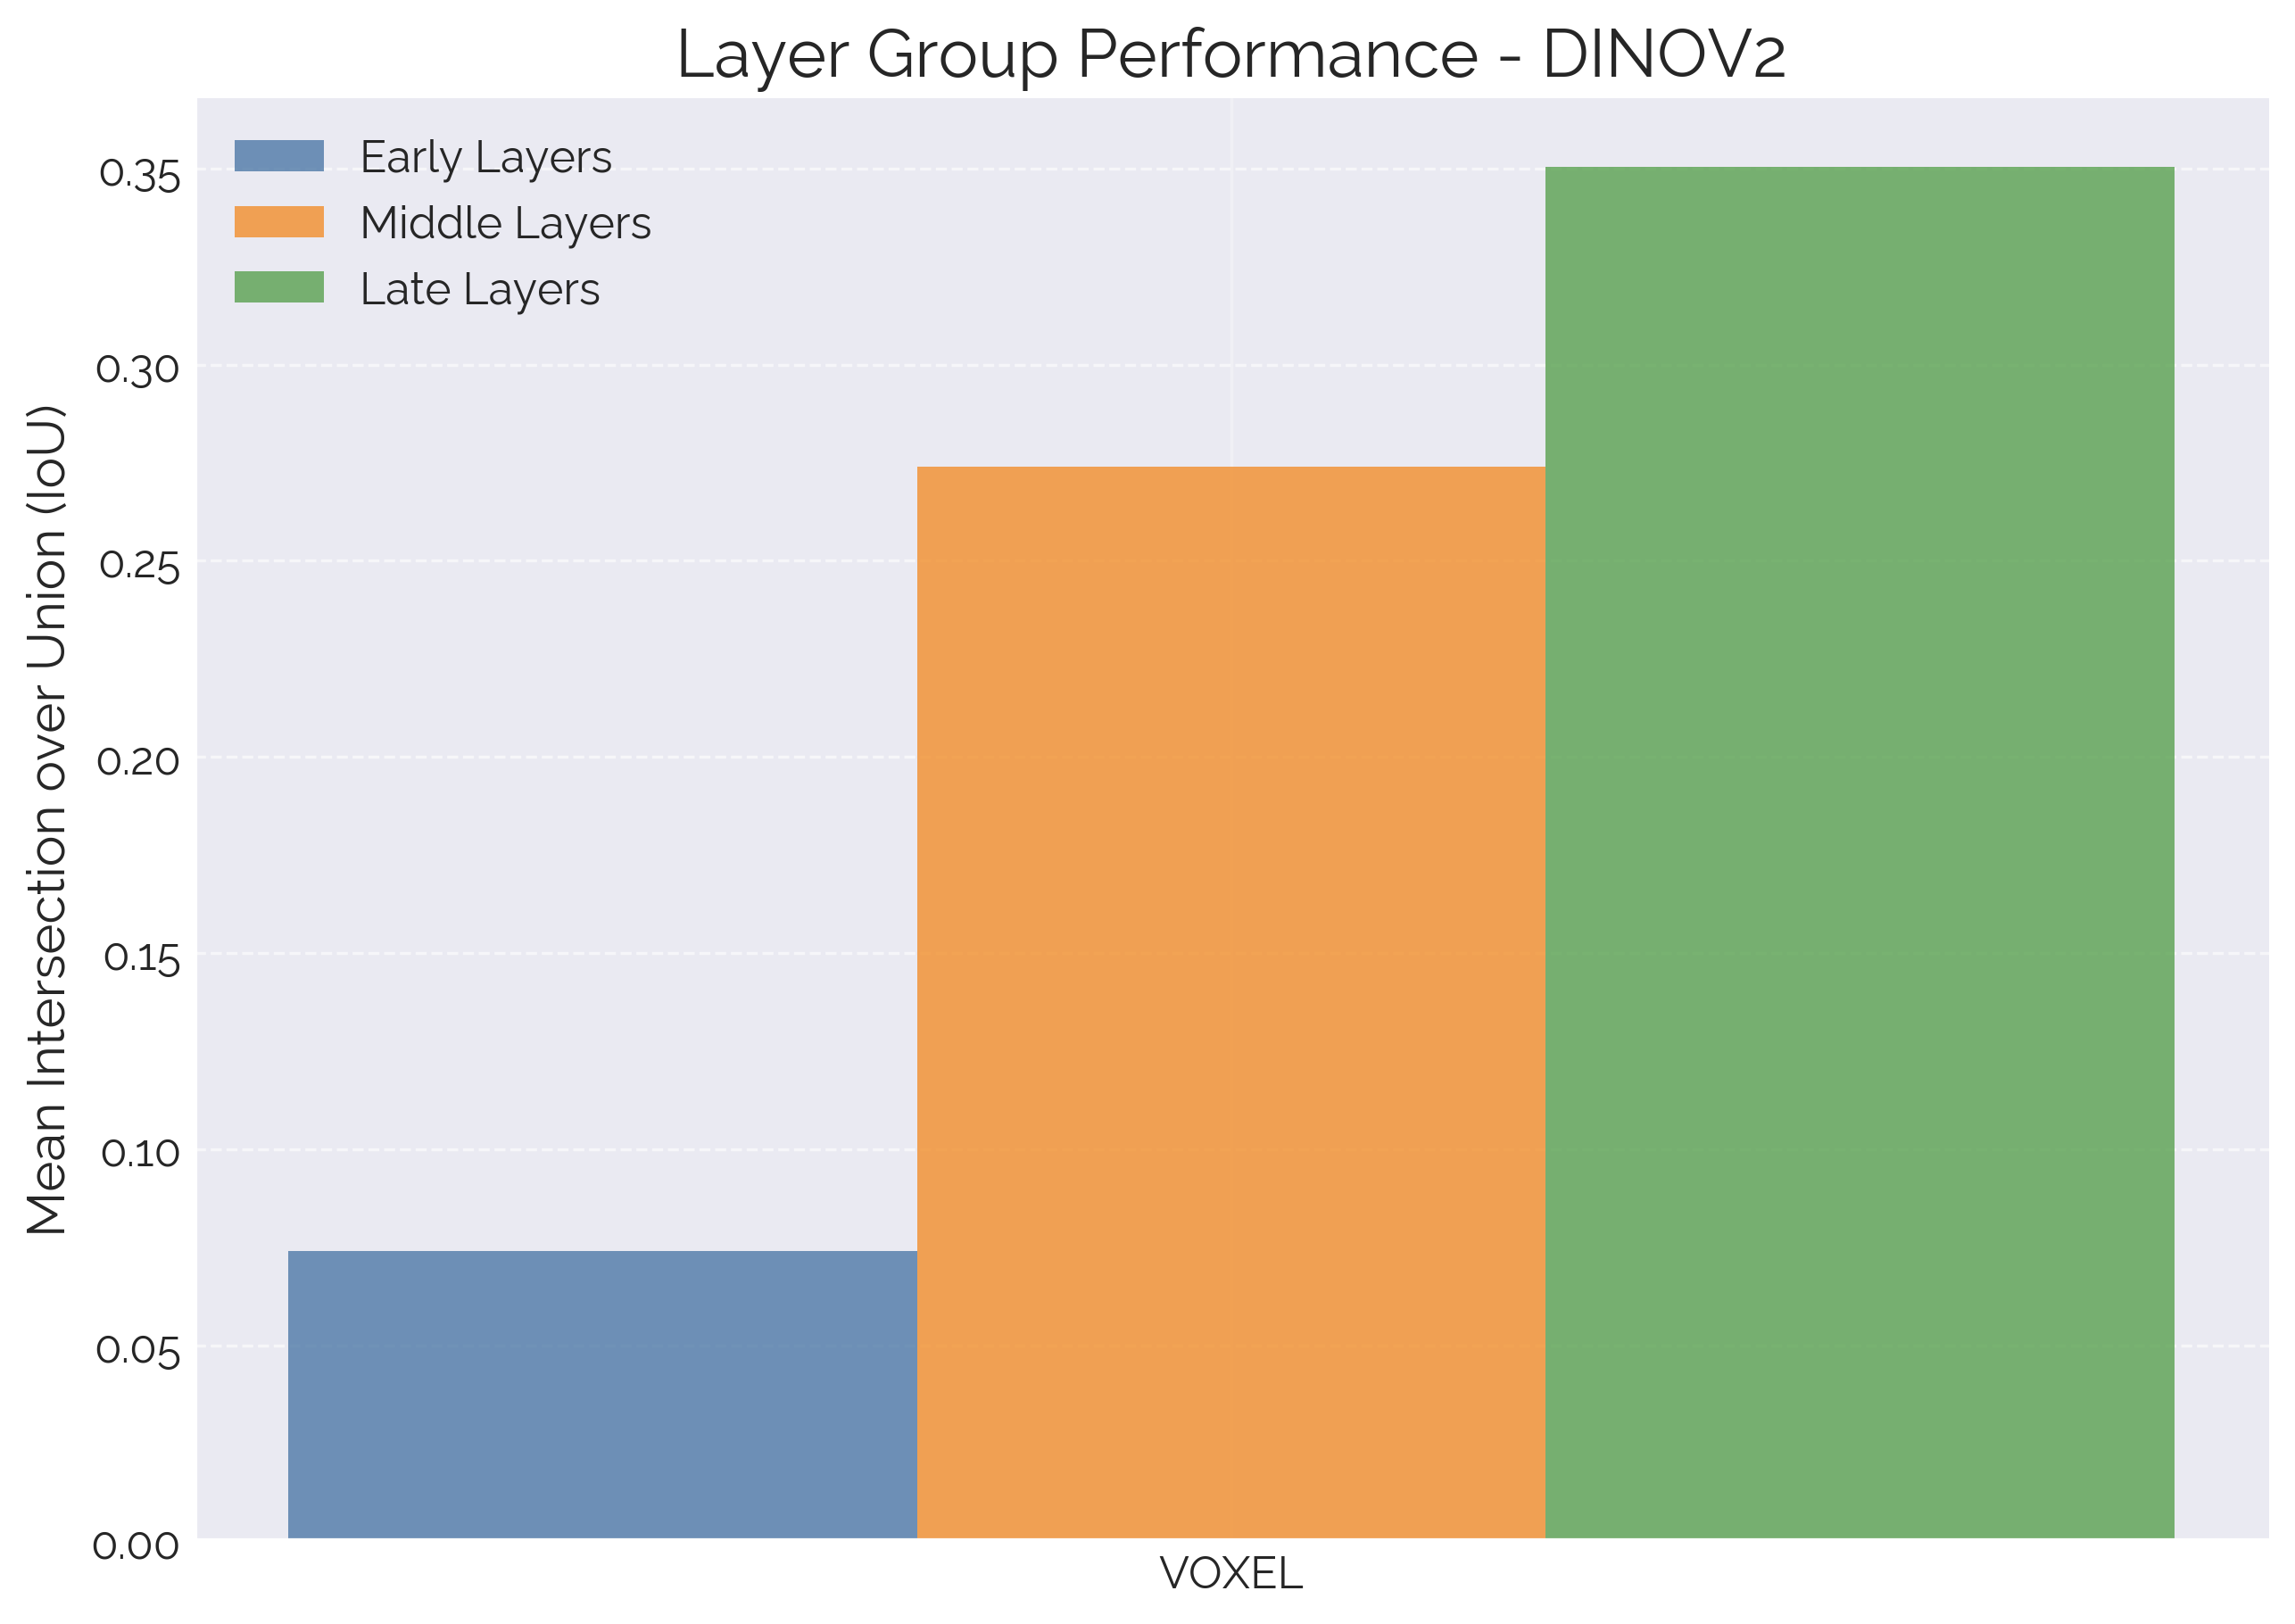

Saved figure: final_analysis/figures/performance_heatmap_ijepa_viewpoint_estimation_20250607_232056.png


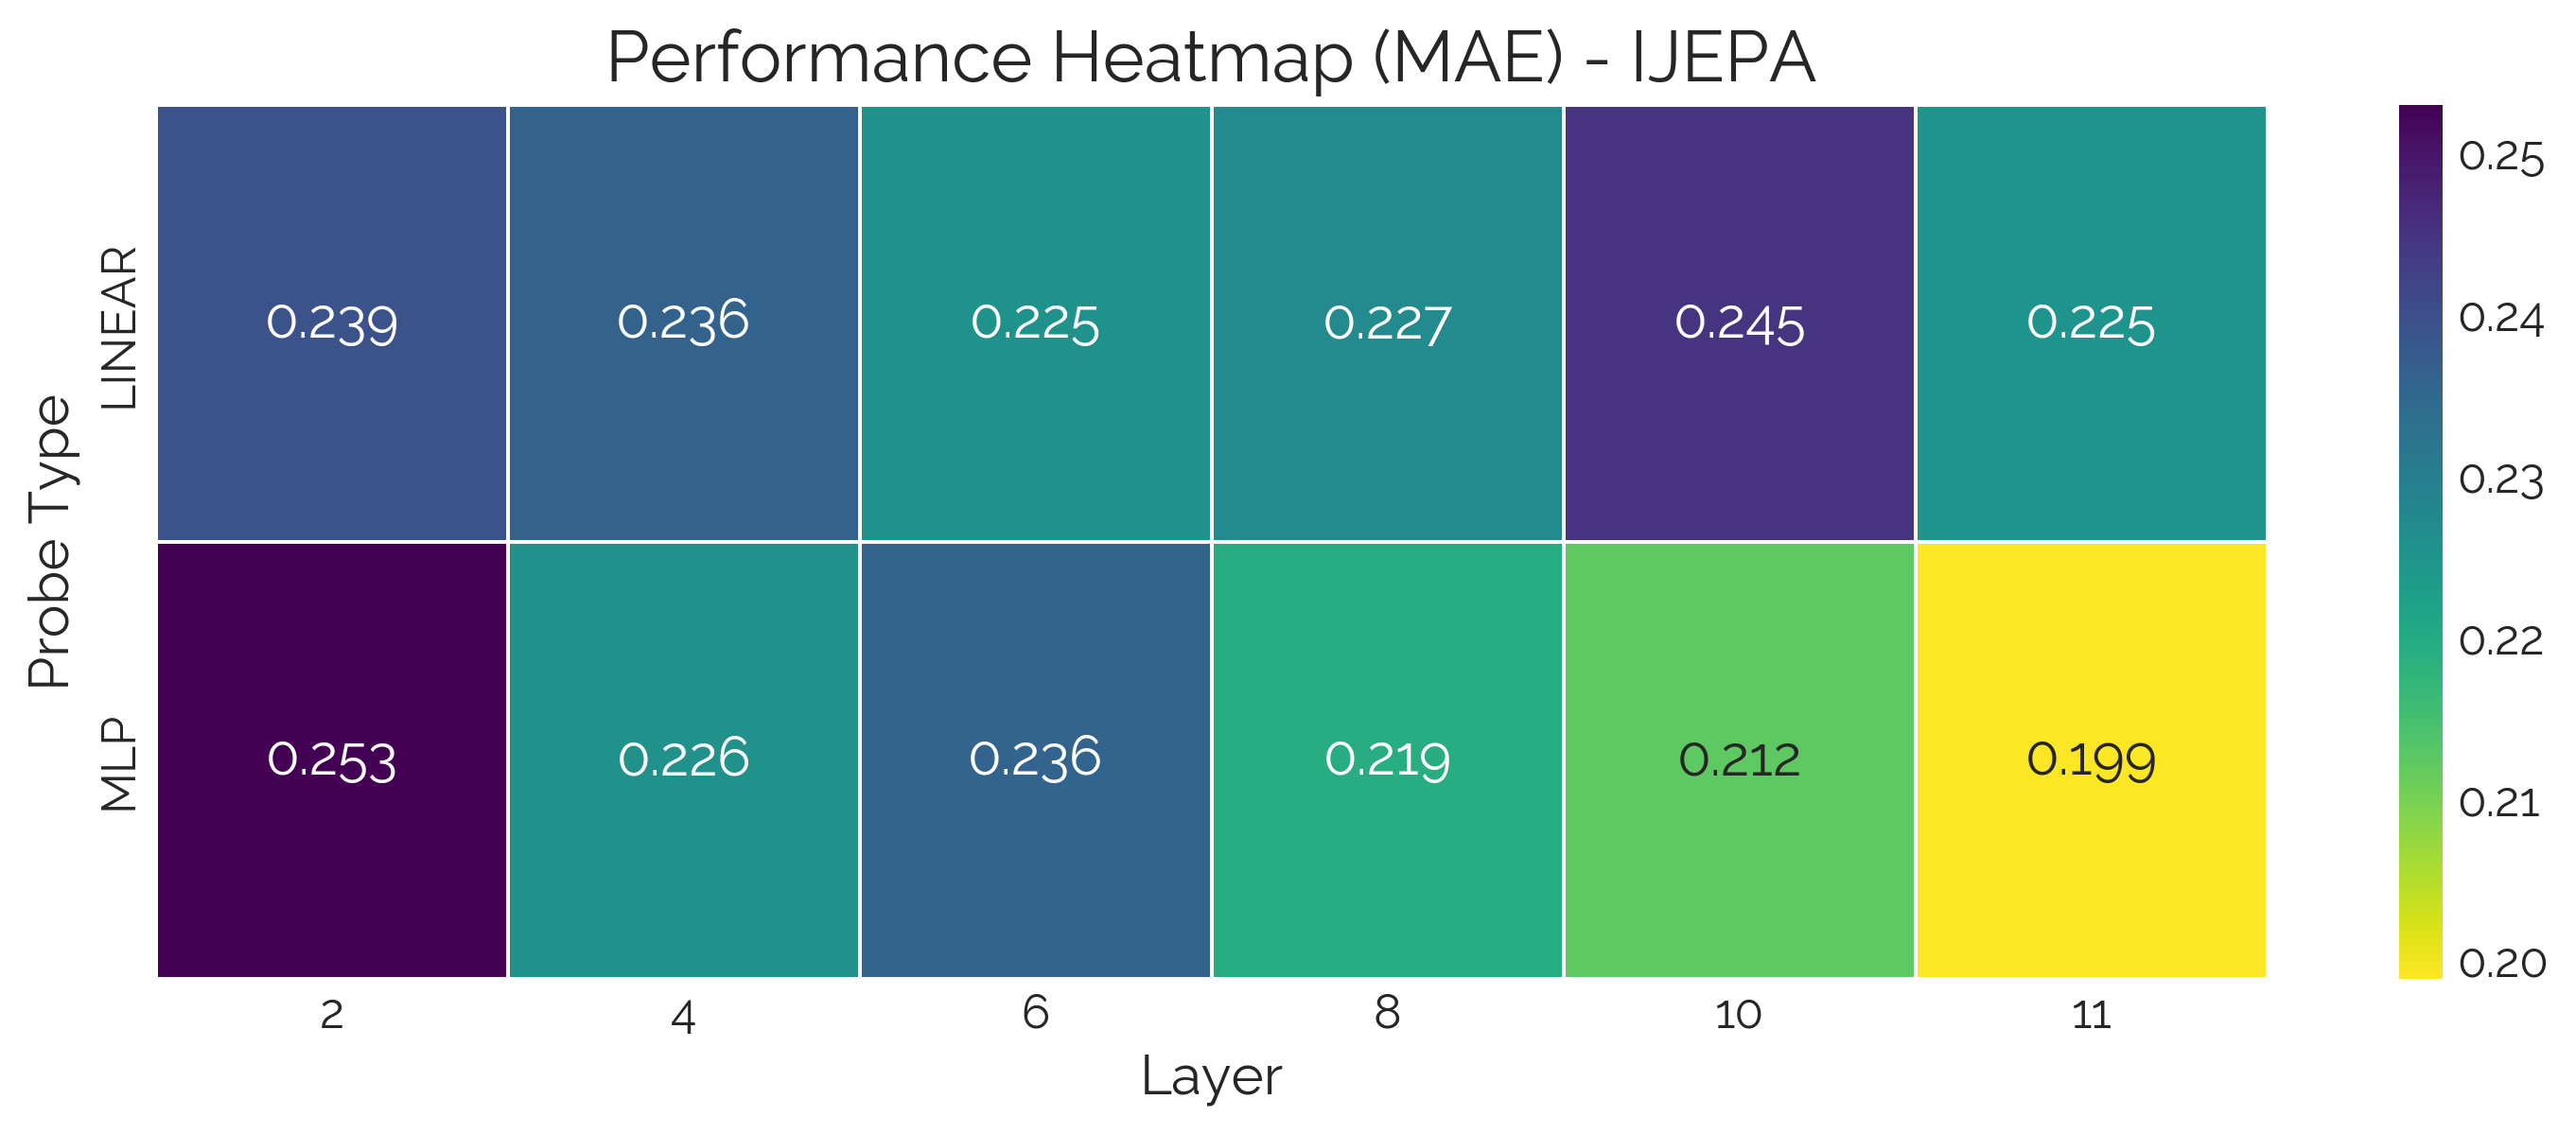

Saved figure: final_analysis/figures/layer_group_trends_ijepa_viewpoint_estimation_20250607_232056.png


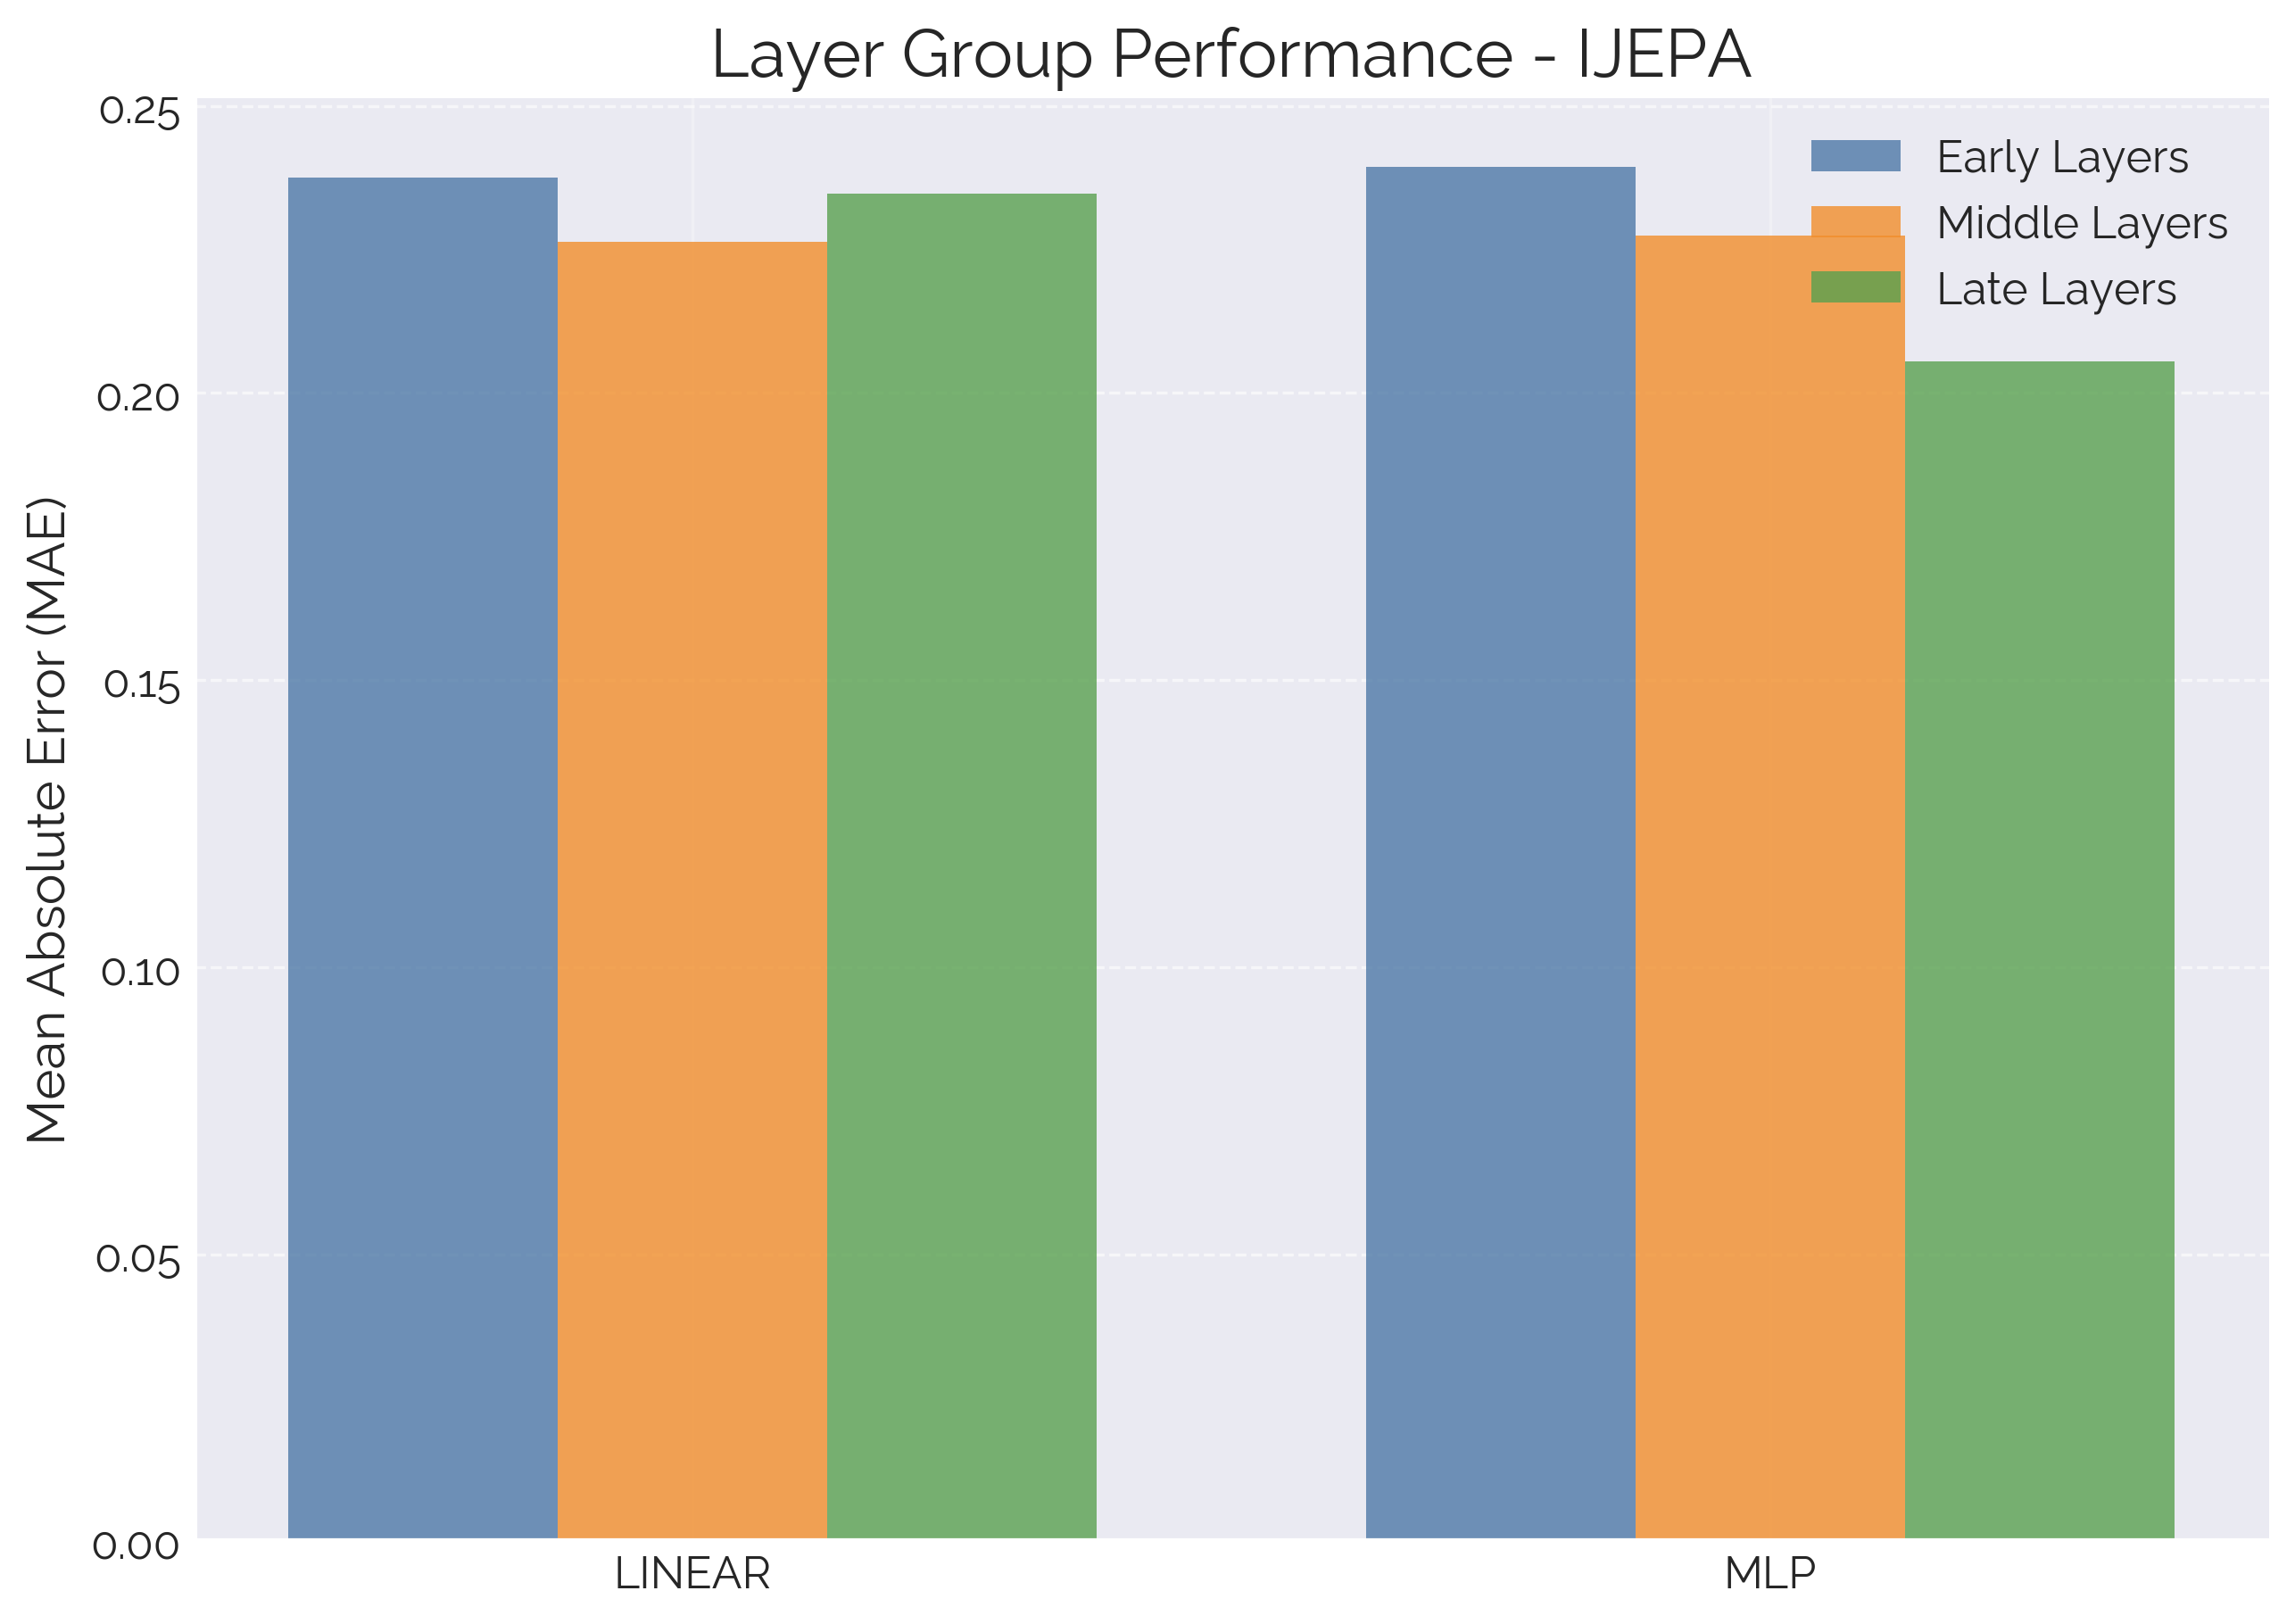

Saved figure: final_analysis/figures/performance_heatmap_dinov2_viewpoint_estimation_20250607_232056.png


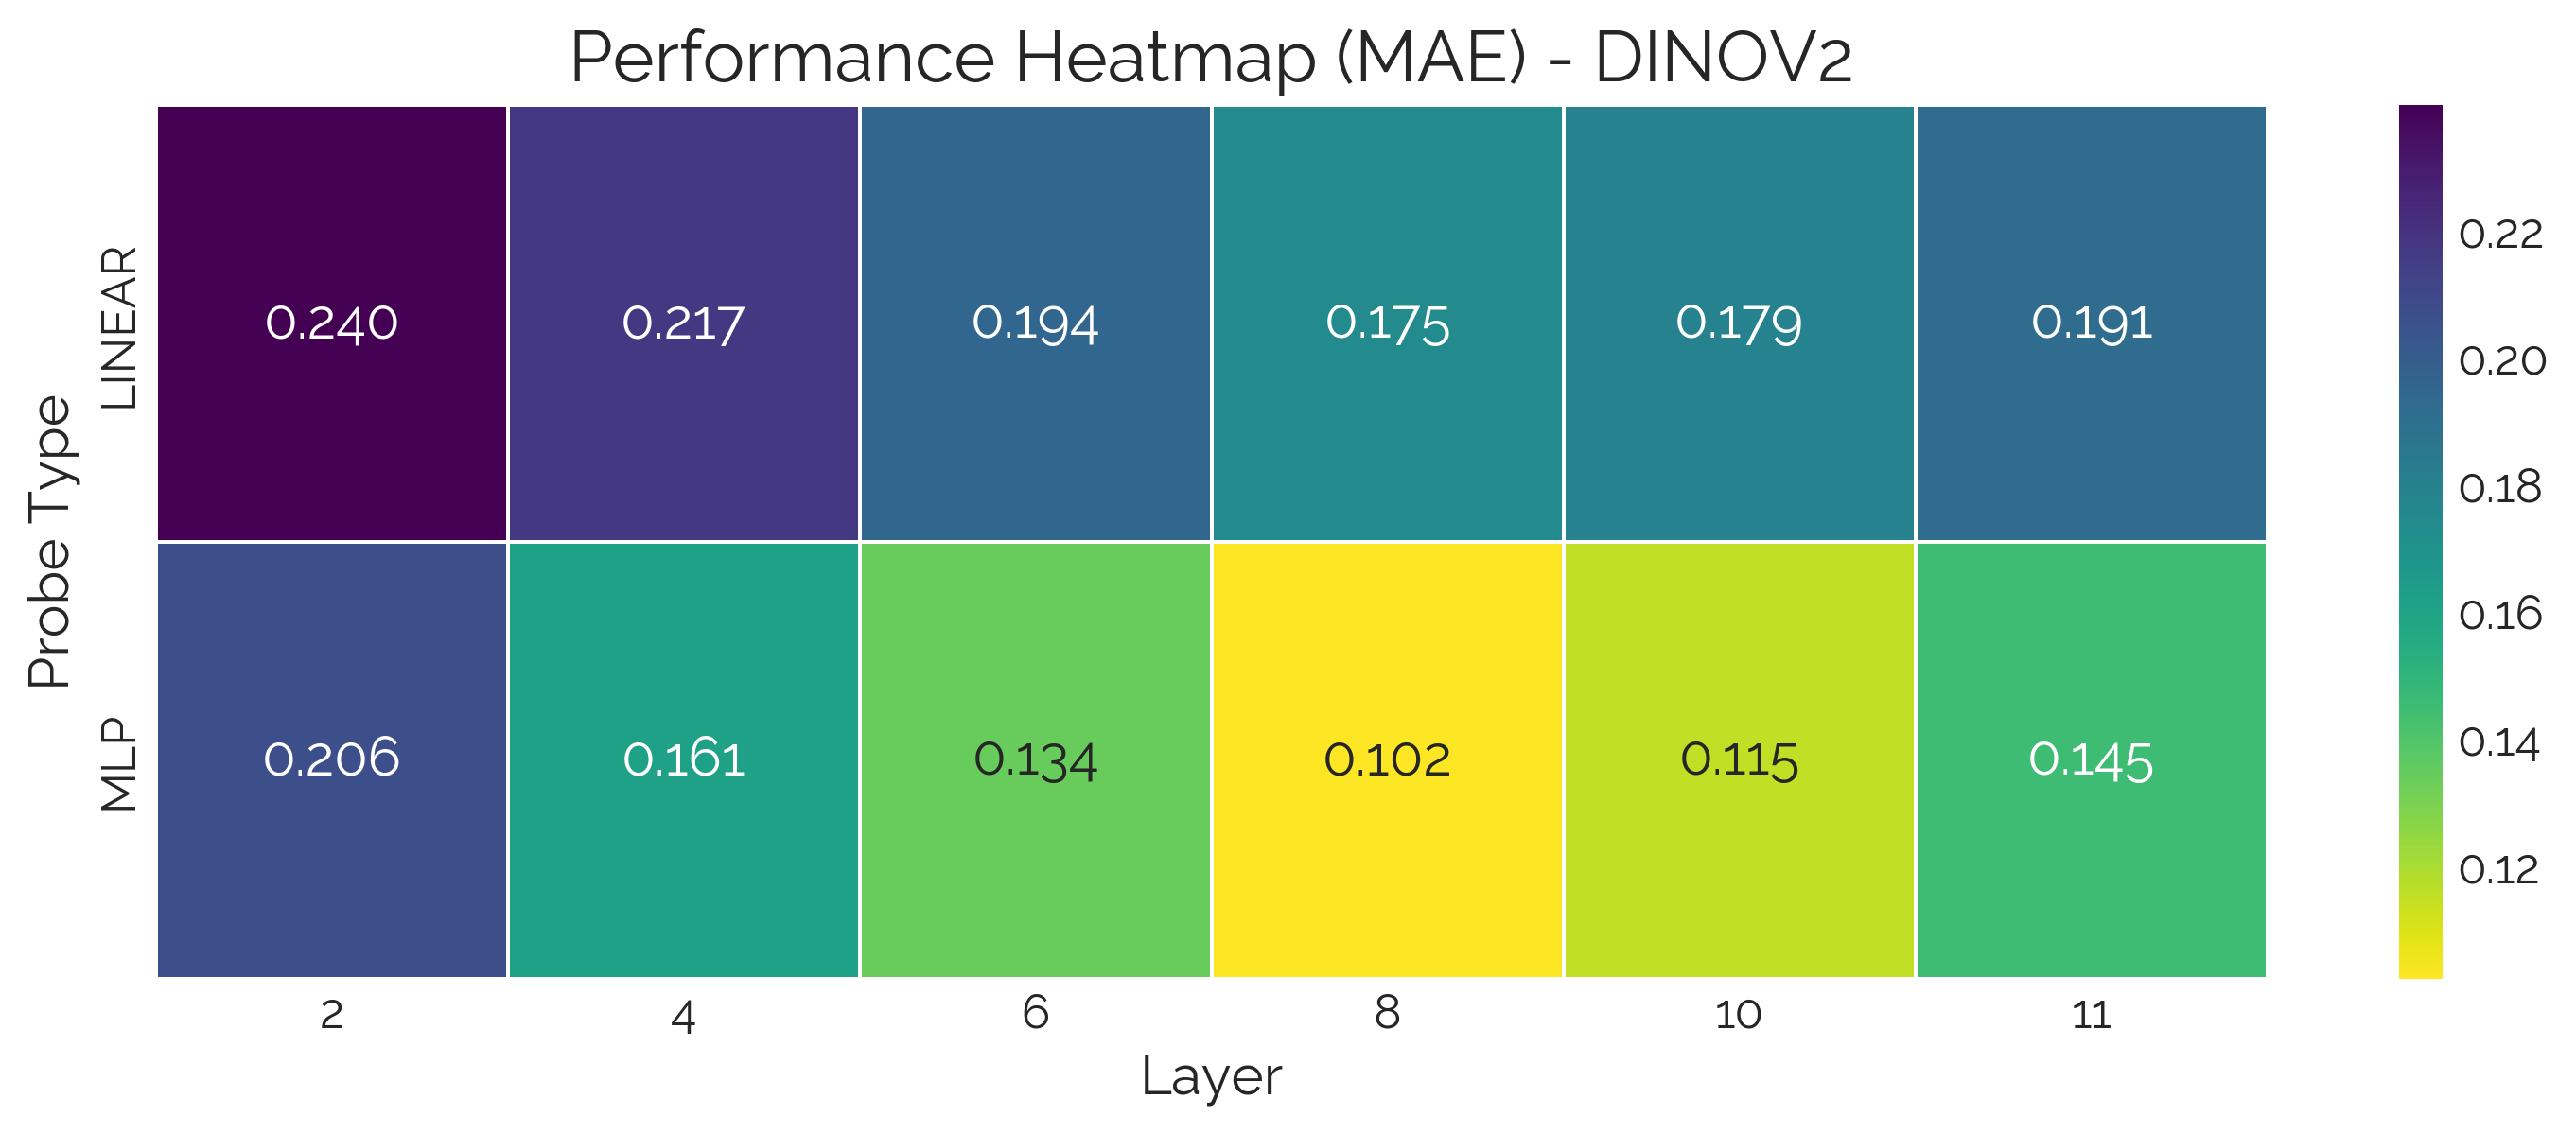

Saved figure: final_analysis/figures/layer_group_trends_dinov2_viewpoint_estimation_20250607_232056.png


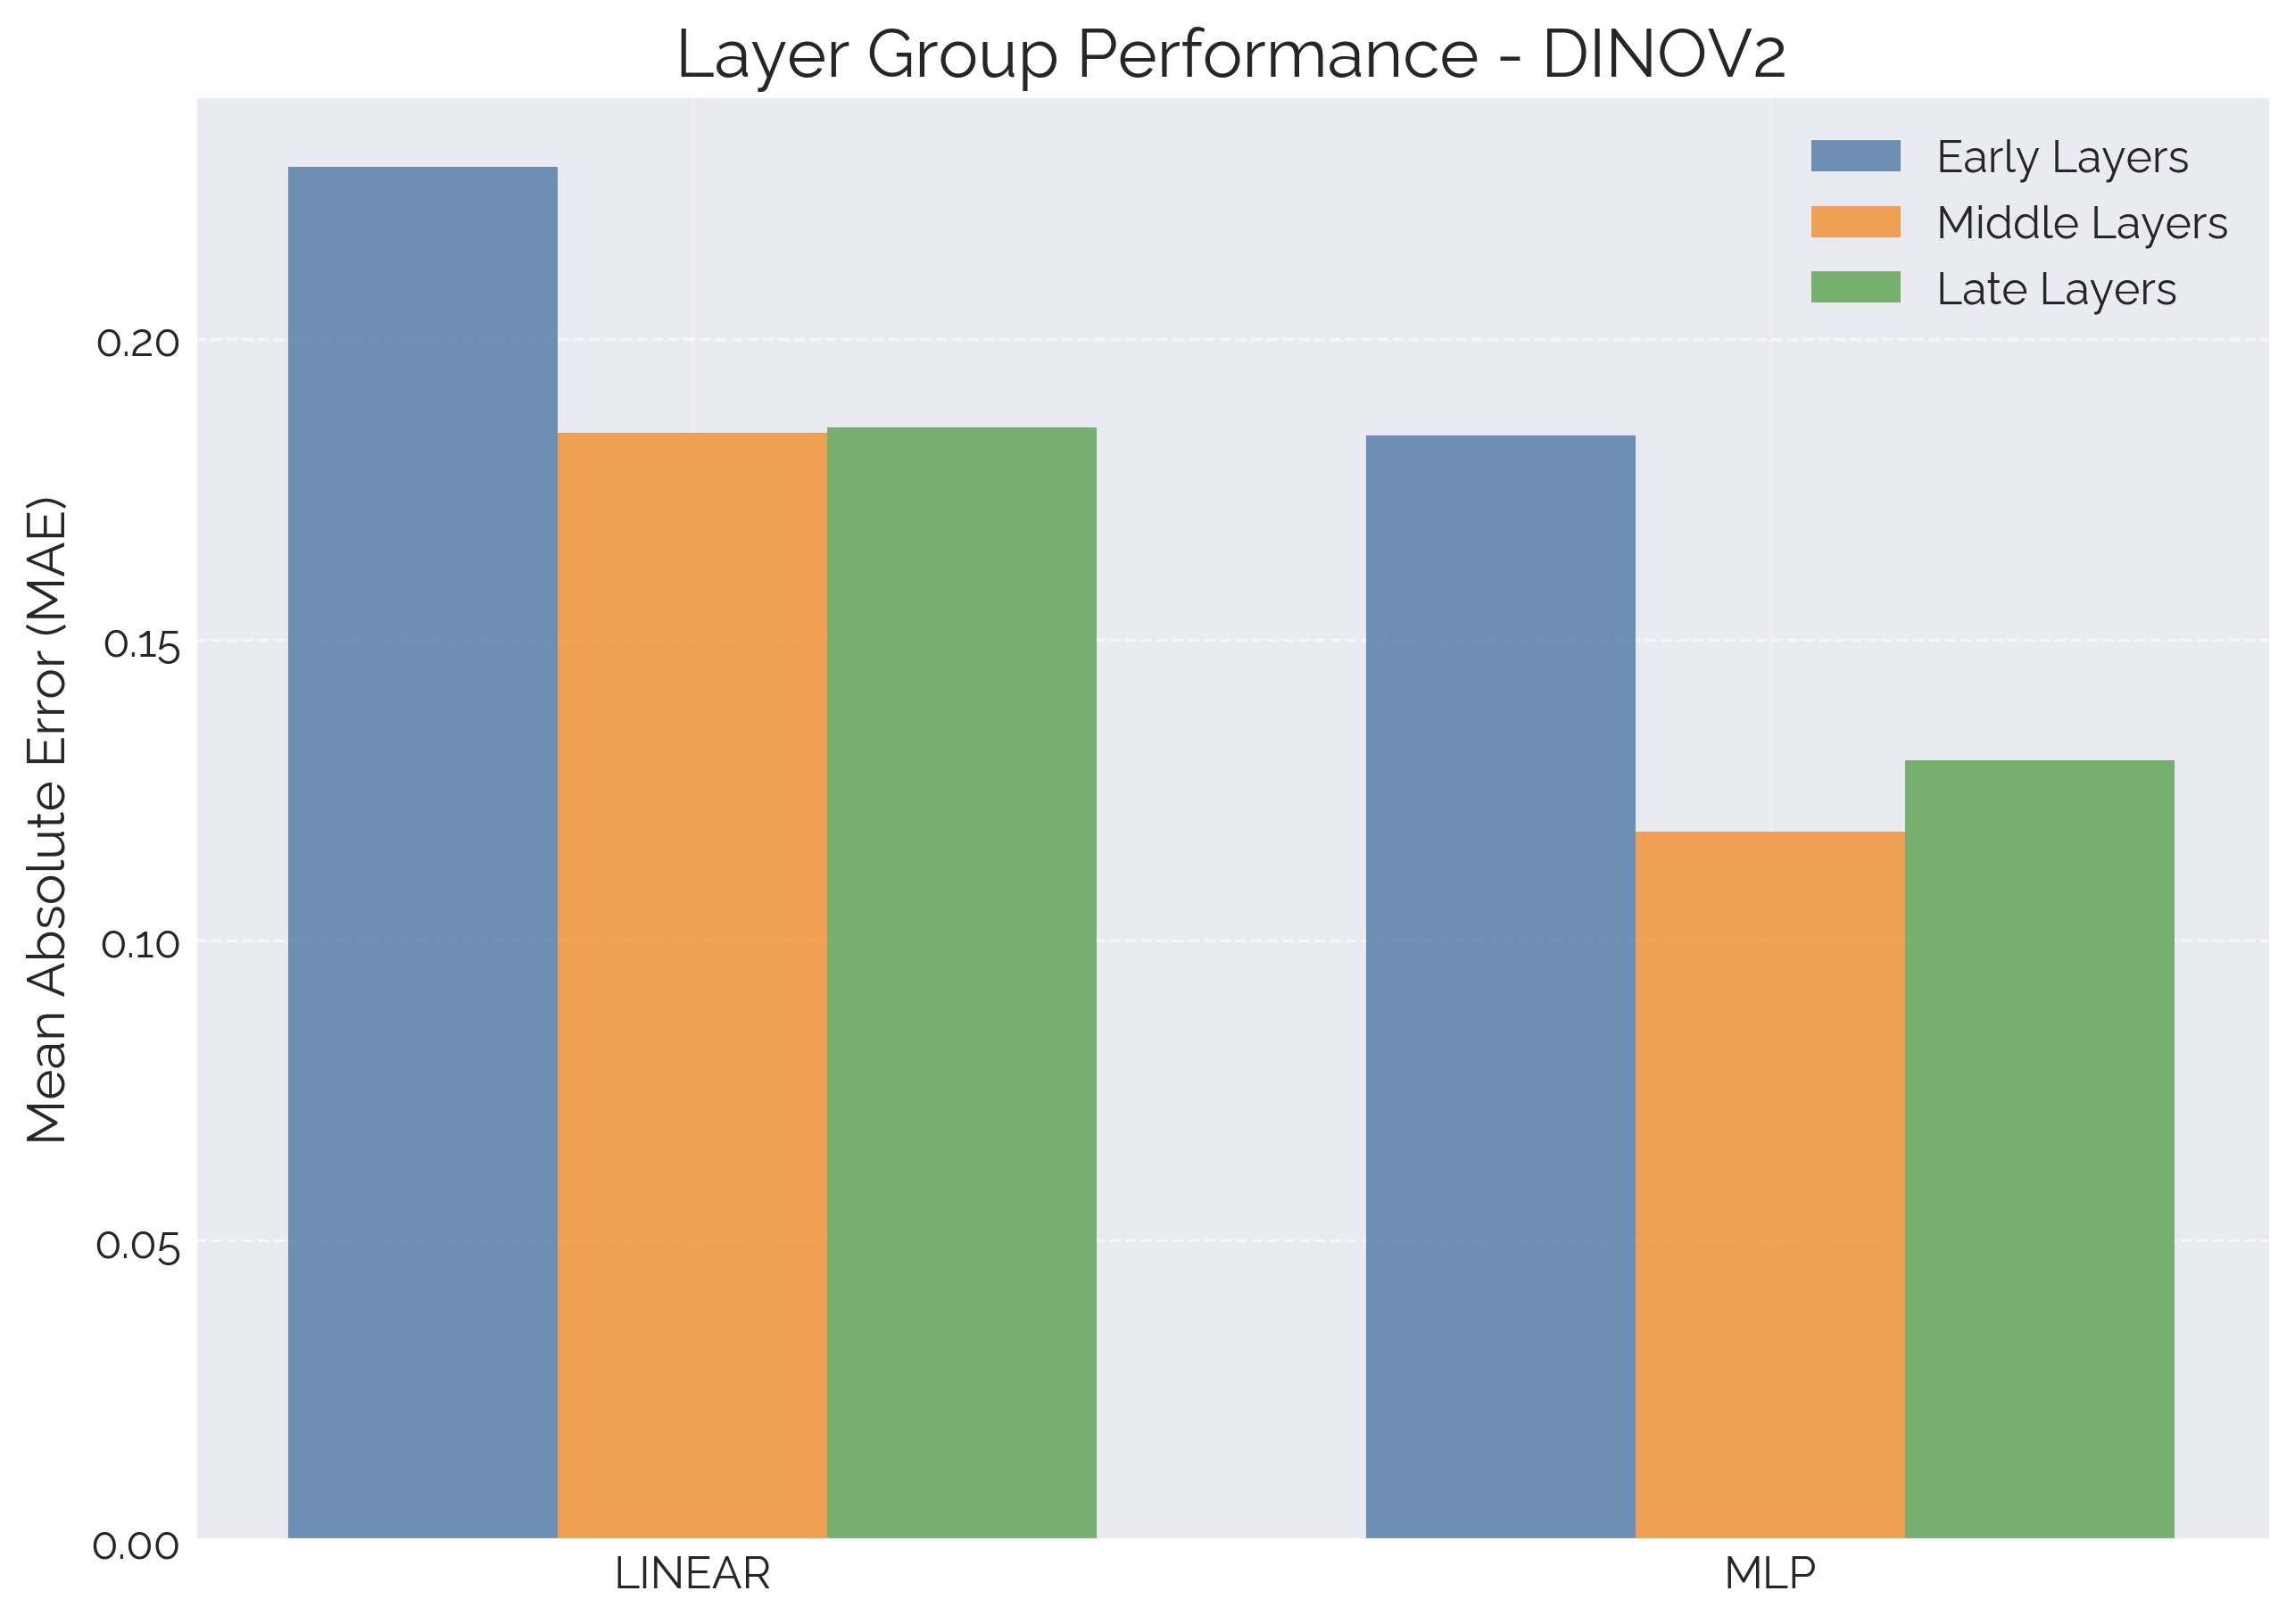

In [30]:
def create_task_performance_heatmap(experiment: ExperimentResult, output_manager: OutputManager):
    """
    Creates a performance heatmap that adapts to the experiment's task (viewpoint or voxel).
    """
    task = experiment.task
    model_name = experiment.model
    results = experiment.results.get('results', {})
    
    if 'viewpoint' in task:
        metric_key = 'mae'
        probe_keys = ['linear', 'mlp']
        cmap = 'viridis_r'  
        title = f'Performance Heatmap (MAE) - {model_name.upper()}'
    elif 'voxel' in task:
        metric_key = 'voxel_iou'
        probe_keys = ['voxel']
        cmap = 'viridis'  
        title = f'Performance Heatmap (IoU) - {model_name.upper()}'
    else:
        return 

    layers = sorted([int(lk.split('_')[1]) for lk in results.keys() if lk.startswith('layer_')])
    data_matrix = np.full((len(probe_keys), len(layers)), np.nan)

    for i, p_type in enumerate(probe_keys):
        for j, layer in enumerate(layers):
            metric_val = results.get(f'layer_{layer}', {}).get(p_type, {}).get('test_metrics', {}).get(metric_key)
            if metric_val is not None:
                data_matrix[i, j] = metric_val

    fig, ax = plt.subplots(figsize=(12, 2 * len(probe_keys)))
    sns.heatmap(data_matrix, annot=True, fmt=".3f", cmap=cmap, ax=ax,
                xticklabels=layers, yticklabels=[pt.upper() for pt in probe_keys],
                linewidths=.5)

    ax.set_title(title, fontsize=VisualConfig.TITLE_SIZE)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Probe Type')
    
    output_manager.save_figure(fig, f'performance_heatmap_{model_name}_{task}')
    plt.show()

def create_task_layer_group_plot(experiment: ExperimentResult, output_manager: OutputManager):
    """
    Analyzes and plots performance across early, middle, and late layer groups for any task.
    """
    task = experiment.task
    model_name = experiment.model
    results_data = experiment.results.get('results', {})

    if 'viewpoint' in task:
        metric_key, y_label = 'mae', 'Mean Absolute Error (MAE)'
        probe_keys = ['linear', 'mlp']
    elif 'voxel' in task:
        metric_key, y_label = 'voxel_iou', 'Mean Intersection over Union (IoU)'
        probe_keys = ['voxel']
    else:
        return

    layer_results = []
    for lk, ld in results_data.items():
        if not lk.startswith('layer_'): continue
        layer = int(lk.split('_')[1])
        for pt, pd in ld.items():
            if pt in probe_keys:
                metric_val = pd.get('test_metrics', {}).get(metric_key)
                if metric_val is not None:
                    layer_results.append({'layer': layer, 'probe': pt, 'metric': metric_val})
    
    if not layer_results: return

    layers = sorted(set(r['layer'] for r in layer_results))
    n = len(layers)
    if n < 3: return 
    early, middle, late = layers[:n//3], layers[n//3 : 2*n//3], layers[2*n//3:]
    groups = {'Early': early, 'Middle': middle, 'Late': late}

    group_stats = {g: {pt: [] for pt in probe_keys} for g in groups}
    for r in layer_results:
        for group_name, group_layers in groups.items():
            if r['layer'] in group_layers:
                group_stats[group_name][r['probe']].append(r['metric'])

    fig, ax = plt.subplots(figsize=(10, 7))
    x_pos = np.arange(len(probe_keys))
    width = 0.25
    group_means = {g: [np.mean(stats[pt]) if stats[pt] else 0 for pt in probe_keys] for g, stats in group_stats.items()}

    ax.bar(x_pos - width, group_means['Early'], width, label='Early Layers', color='#4E79A7', alpha=0.8)
    ax.bar(x_pos, group_means['Middle'], width, label='Middle Layers', color='#F28E2B', alpha=0.8)
    ax.bar(x_pos + width, group_means['Late'], width, label='Late Layers', color='#59A14F', alpha=0.8)

    ax.set_ylabel(y_label)
    ax.set_title(f'Layer Group Performance - {model_name.upper()}', fontsize=VisualConfig.TITLE_SIZE)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([pt.upper() for pt in probe_keys])
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    output_manager.save_figure(fig, f'layer_group_trends_{model_name}_{task}')
    plt.show()

for exp in all_experiments.values():
    create_task_performance_heatmap(exp, output_manager)
    create_task_layer_group_plot(exp, output_manager)

## 6. Analyzing Intrinsic Latents

### 6.1 Cross-Model Latent Space Comparison

--- Analyzing latent space for: DINOV2 ---
  > Running PCA...
  > Running t-SNE...
  > Running UMAP...
Saved figure: final_analysis/figures/latent_space_comprehensive_comparison_20250607_232056.png


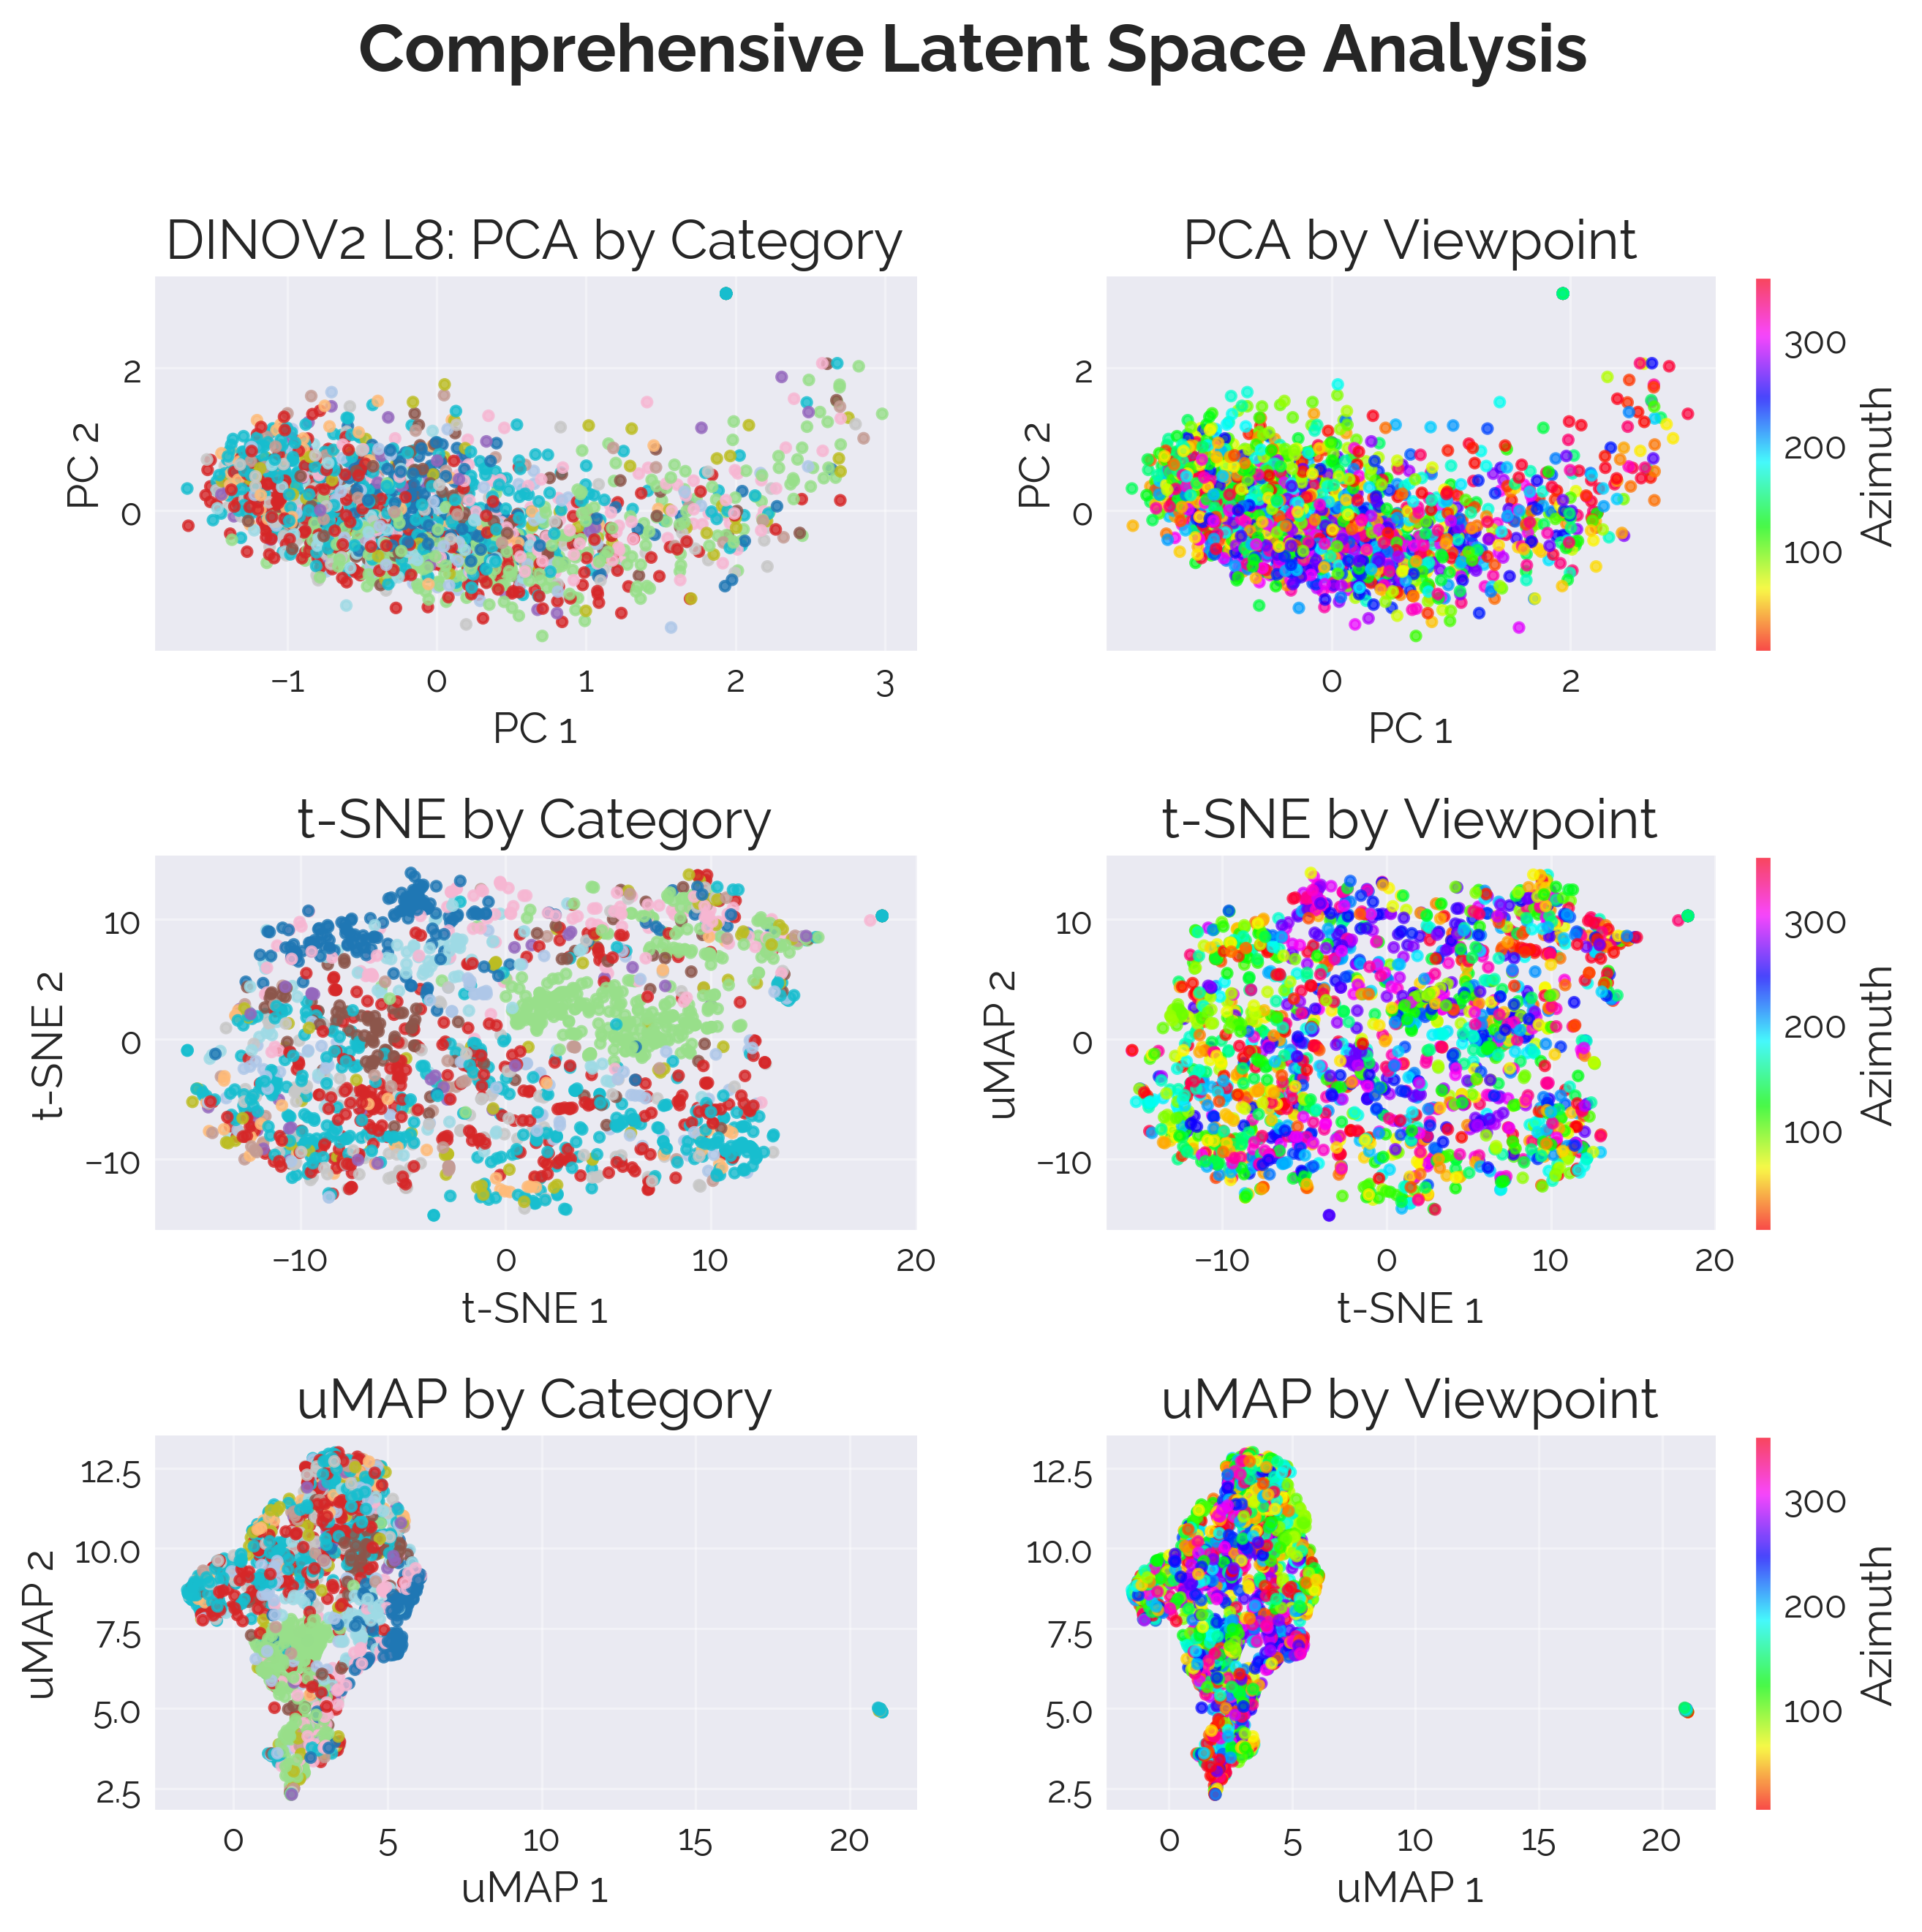

In [ ]:

model_features = {}
def create_latent_space_analysis(experiments: List[ExperimentResult], loader: ExperimentLoader, output_manager: OutputManager):
    """
    Creates a side-by-side comparison of latent spaces via PCA / t-SNE plots for each model
    """
    for exp in experiments:
        best_layer, _ = exp.get_best_layer()
        if best_layer is None: continue
        
        feature_files = loader.get_feature_files(exp)
        if best_layer in feature_files and 'test' in feature_files[best_layer]:
            with open(feature_files[best_layer]['test'], 'rb') as f: data = pickle.load(f)
            if 'voxel' in exp.task and 'view_data' in data:
                feature_source = data['view_data']
            elif 'features' in data:
                feature_source = data['features']
            else:
                continue
            
            if hasattr(feature_source, 'ndim') and feature_source.ndim == 3:
                n_samples, n_patches, n_dims = feature_source.shape
                feature_source = feature_source.reshape(n_samples, n_patches * n_dims)

            if not isinstance(feature_source, torch.Tensor):
                feature_source = torch.from_numpy(feature_source)
                
            n_samples = min(2000, len(feature_source))
            indices = np.random.choice(len(feature_source), n_samples, replace=False)
            
            model_features[exp.model] = {
                'features': feature_source[indices],
                'targets': data['targets'][indices] if 'targets' in data else None,
                'metadata': {k: [v[i] for i in indices] for k, v in data.get('metadata', {}).items()},
                'layer': best_layer
            }

    if not model_features:
        print("No valid features found for latent space analysis.")
        return

    n_models = len(model_features)
    fig, axes = plt.subplots(3, 2 * n_models, figsize=(9 * n_models, 9), squeeze=False)
    
    for idx, (model_name, data) in enumerate(model_features.items()):
        print(f"--- Analyzing latent space for: {model_name.upper()} ---")
        features, targets, metadata = data['features'], data['targets'], data['metadata']
        
        print("  > Running PCA...")
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features)
        
        print("  > Running t-SNE...")
        tsne = TSNE(n_components=2, perplexity=30, n_iter=350, random_state=42, init='pca', learning_rate='auto')
        features_tsne = tsne.fit_transform(features)
        
        print("  > Running UMAP...")
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        features_umap = reducer.fit_transform(features)

        col_start = idx * 2
        ax_pca_cat = axes[0, col_start]
        ax_pca_azi = axes[0, col_start + 1]
        ax_tsne_cat = axes[1, col_start]
        ax_tsne_azi = axes[1, col_start + 1]
        ax_umap_cat = axes[2, col_start]
        ax_umap_azi= axes[2, col_start + 1]

        
        azimuth = (targets[:, 0] + 1) * 180 if targets is not None else None
        categories = metadata.get('categories')
        cat_indices = None
        if categories:
            unique_cats = sorted(list(set(categories)))
            cat_to_idx = {cat: i for i, cat in enumerate(unique_cats)}
            cat_indices = [cat_to_idx[cat] for cat in categories]

        # PCA plots
        if cat_indices:
            ax_pca_cat.scatter(features_pca[:, 0], features_pca[:, 1], c=cat_indices, cmap='tab20', alpha=0.8, s=10)
        ax_pca_cat.set_title(f'{model_name.upper()} L{data["layer"]}: PCA by Category')
        ax_pca_cat.set_xlabel('PC 1'); ax_pca_cat.set_ylabel('PC 2')
        
        if azimuth is not None:
            scatter_pca = ax_pca_azi.scatter(features_pca[:, 0], features_pca[:, 1], c=azimuth, cmap='hsv', alpha=0.7, s=10)
            fig.colorbar(scatter_pca, ax=ax_pca_azi, label='Azimuth')
        ax_pca_azi.set_title(f'PCA by Viewpoint')
        ax_pca_azi.set_xlabel('PC 1'); ax_pca_azi.set_ylabel('PC 2')

        # t-SNE plots
        if cat_indices:
            ax_tsne_cat.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cat_indices, cmap='tab20', alpha=0.8, s=10)
        ax_tsne_cat.set_title(f't-SNE by Category')
        ax_tsne_cat.set_xlabel('t-SNE 1'); ax_tsne_cat.set_ylabel('t-SNE 2')

        if azimuth is not None:
            scatter_tsne = ax_tsne_azi.scatter(features_tsne[:, 0], features_tsne[:, 1], c=azimuth, cmap='hsv', alpha=0.7, s=10)
            fig.colorbar(scatter_tsne, ax=ax_tsne_azi, label='Azimuth')
        ax_tsne_azi.set_title(f't-SNE by Viewpoint')
        ax_tsne_azi.set_xlabel('t-SNE 1'); ax_tsne_azi.set_ylabel('t-SNE 2')
        
        # u-map plot
        if cat_indices:
            ax_umap_cat.scatter(features_umap[:, 0], features_umap[:, 1], c=cat_indices, cmap='tab20', alpha=0.8, s=10)
        ax_umap_cat.set_title(f'uMAP by Category')
        ax_umap_cat.set_xlabel('uMAP 1'); ax_umap_cat.set_ylabel('uMAP 2')            
        
        if azimuth is not None:
            scatter_umap = ax_umap_azi.scatter(features_umap[:, 0], features_umap[:, 1], c=azimuth, cmap='hsv', alpha=0.7, s=10)
            fig.colorbar(scatter_umap, ax=ax_umap_azi, label='Azimuth')
        ax_umap_azi.set_title(f'uMAP by Viewpoint')
        ax_umap_azi.set_xlabel('uMAP 1'); ax_tsne_azi.set_ylabel('uMAP 2')
        
        for ax in [ax_pca_cat, ax_pca_azi, ax_tsne_cat, ax_tsne_azi, ax_umap_cat, ax_umap_azi]:
             ax.grid(True, alpha=0.4)

    fig.suptitle('Comprehensive Latent Space Analysis', fontsize=VisualConfig.TITLE_SIZE + 4, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    output_manager.save_figure(fig, 'latent_space_comprehensive_comparison')
    plt.show()

all_experiments_no_ijepa = {key: value for key, value in all_experiments.items() if key != "ijepa"}
create_latent_space_analysis(list(all_experiments_no_ijepa.values()), loader, output_manager)

#### 6.1.1 Silhouette Scores

  > dinov2: -0.0276
Saved figure: final_analysis/figures/category_cluster_separation_(silhouette_score)_20250607_232056.png


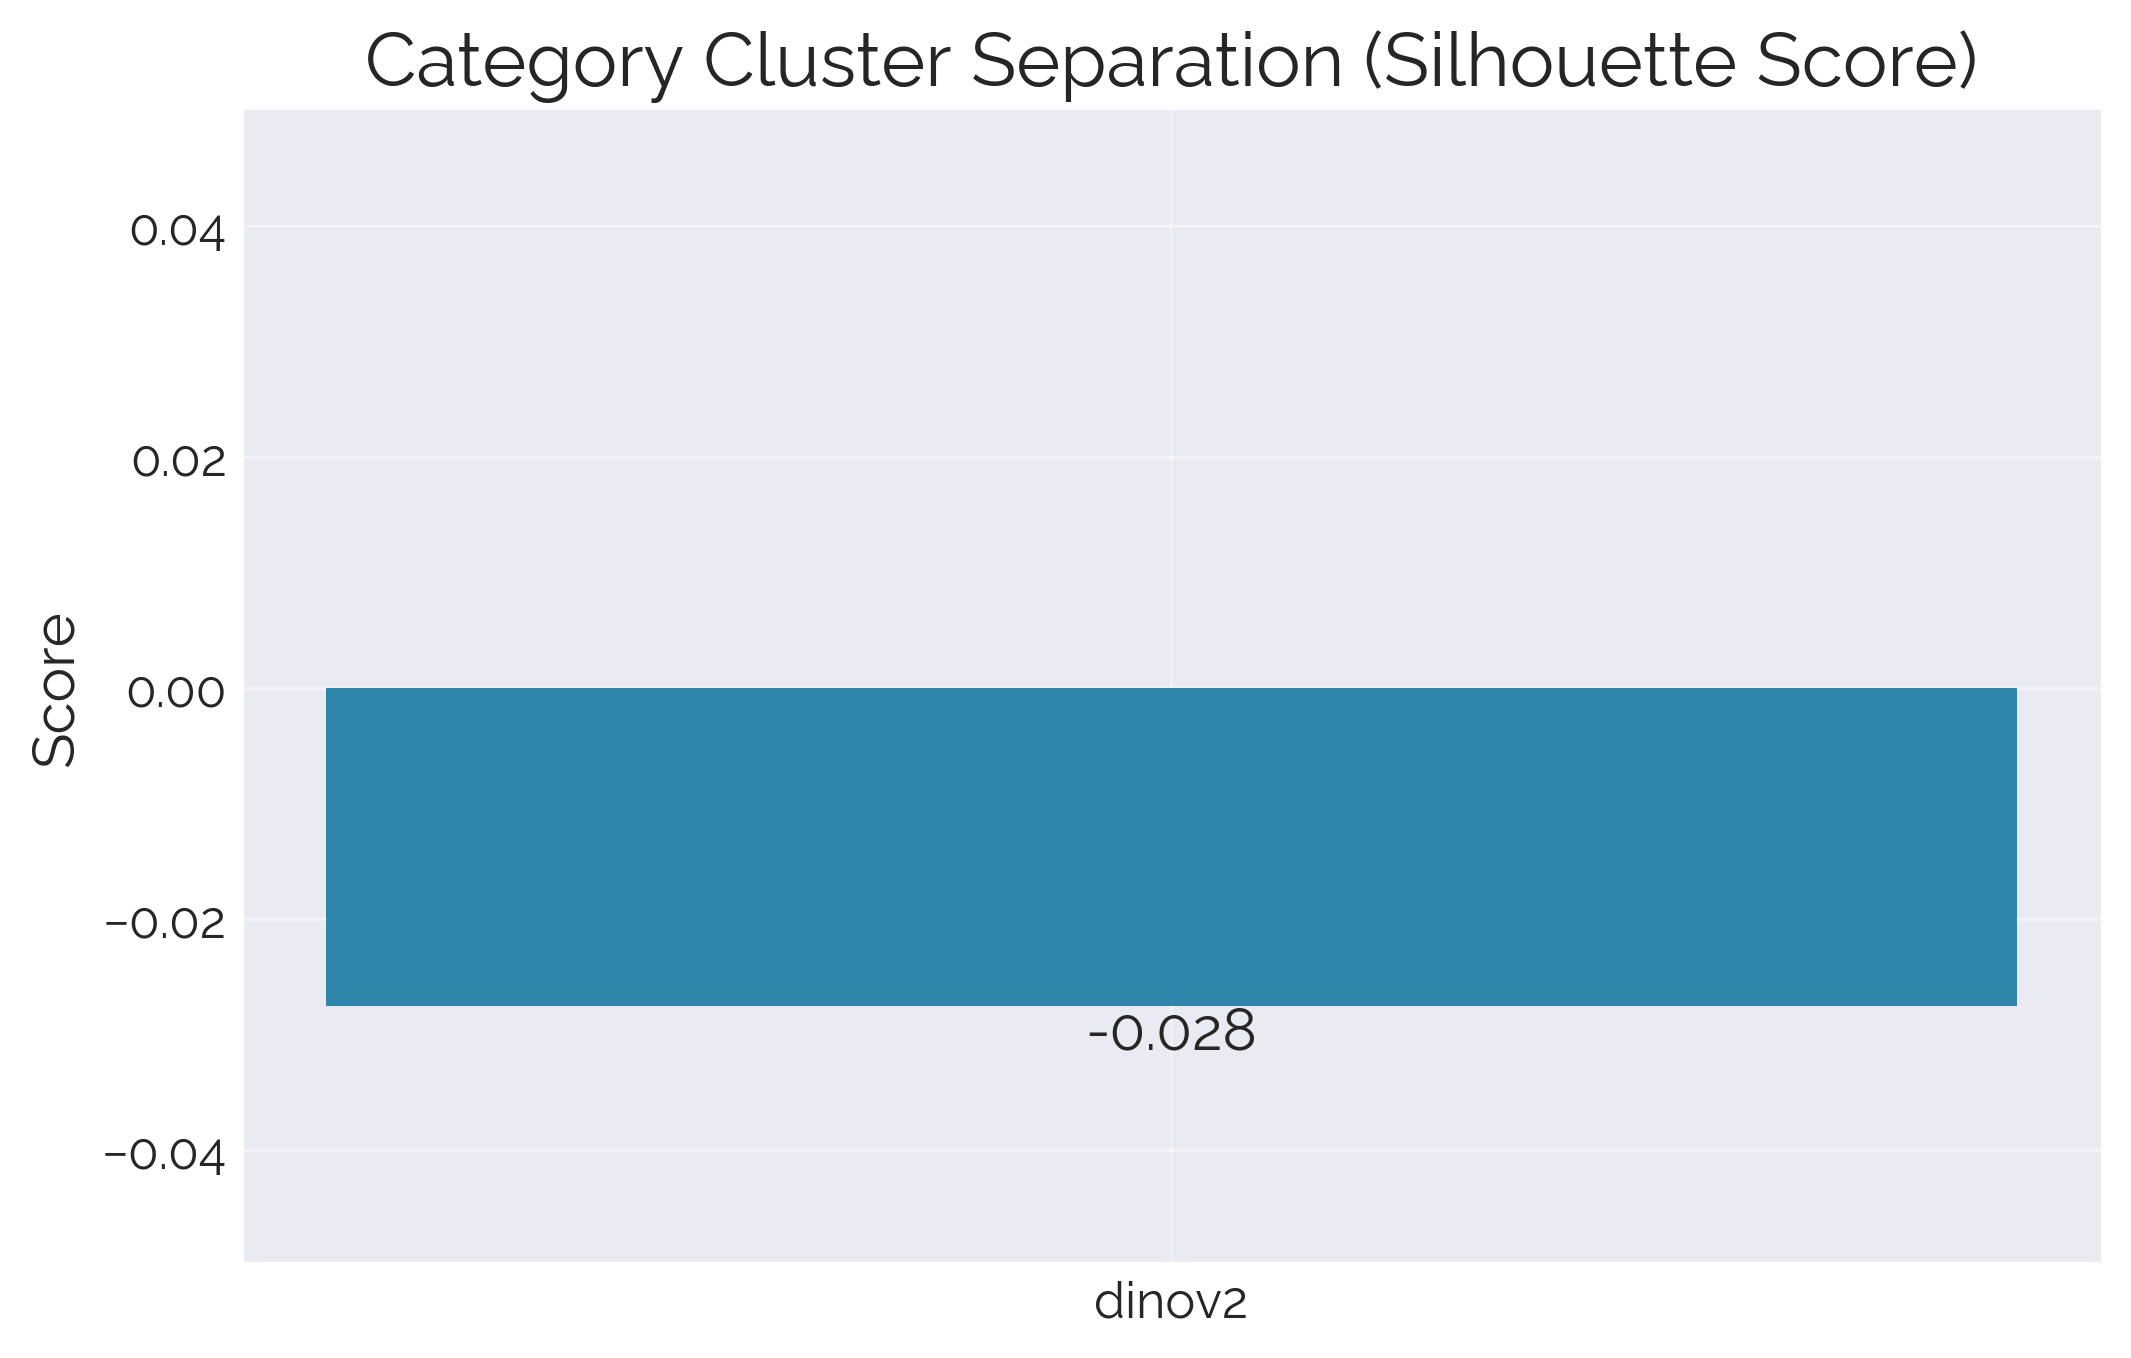

In [32]:

def calculate_silhouette_scores(model_features: Dict) -> Dict:
    """Calculates the Silhouette Score for object categories in each model's latent space"""
    scores = {}
    for model_name, data in model_features.items():
        features = data['features']
        metadata = data['metadata']
        
        if 'categories' in metadata and len(set(metadata['categories'])) > 1:
            unique_cats = sorted(list(set(metadata['categories'])))
            cat_to_idx = {cat: i for i, cat in enumerate(unique_cats)}
            labels = [cat_to_idx[cat] for cat in metadata['categories']]
            
            score = silhouette_score(features, labels)
            scores[model_name] = score
            print(f"  > {model_name}: {score:.4f}")
        else:
            print(f"  > Skipping {model_name}: Not enough data")
    
    return scores

def plot_scores(scores: Dict, title: str, output_manager: OutputManager):
    """Creates a bar plot for the scores."""
    if not scores: return
    
    models = list(scores.keys())
    values = list(scores.values())
    
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = [VisualConfig.MODEL_COLORS.get(m, '#333') for m in models]
    
    bars = ax.bar(models, values, color=colors)
    ax.bar_label(bars, fmt='%.3f')
    
    ax.set_ylabel('Score')
    ax.set_title(title, fontsize=VisualConfig.TITLE_SIZE)
    ax.set_ylim(bottom=0)
    ax.grid(True, axis='y', alpha=0.5)
    
    output_manager.save_figure(fig, title.lower().replace(' ', '_'))
    plt.show()

silhouette_results = calculate_silhouette_scores(model_features)
plot_scores(silhouette_results, "Category Cluster Separation (Silhouette Score)", output_manager)

#### 6.1.2: CKA Analysis


No feature files found for phase2_dinov2_voxel_reconstruction to run CKA analysis.
No feature files found for ijepa_phase1_ijepa_viewpoint_probing to run CKA analysis.
Loading features for dinov2 (viewpoint_estimation)...
Computing Inter-Layer CKA Matrix... (this may take a moment)
Saved figure: final_analysis/figures/cka_inter_layer_dinov2_viewpoint_estimation_20250607_232056.png
Saved data: final_analysis/data/cka_inter_layer_dinov2_viewpoint_estimation_data_20250607_232056.json


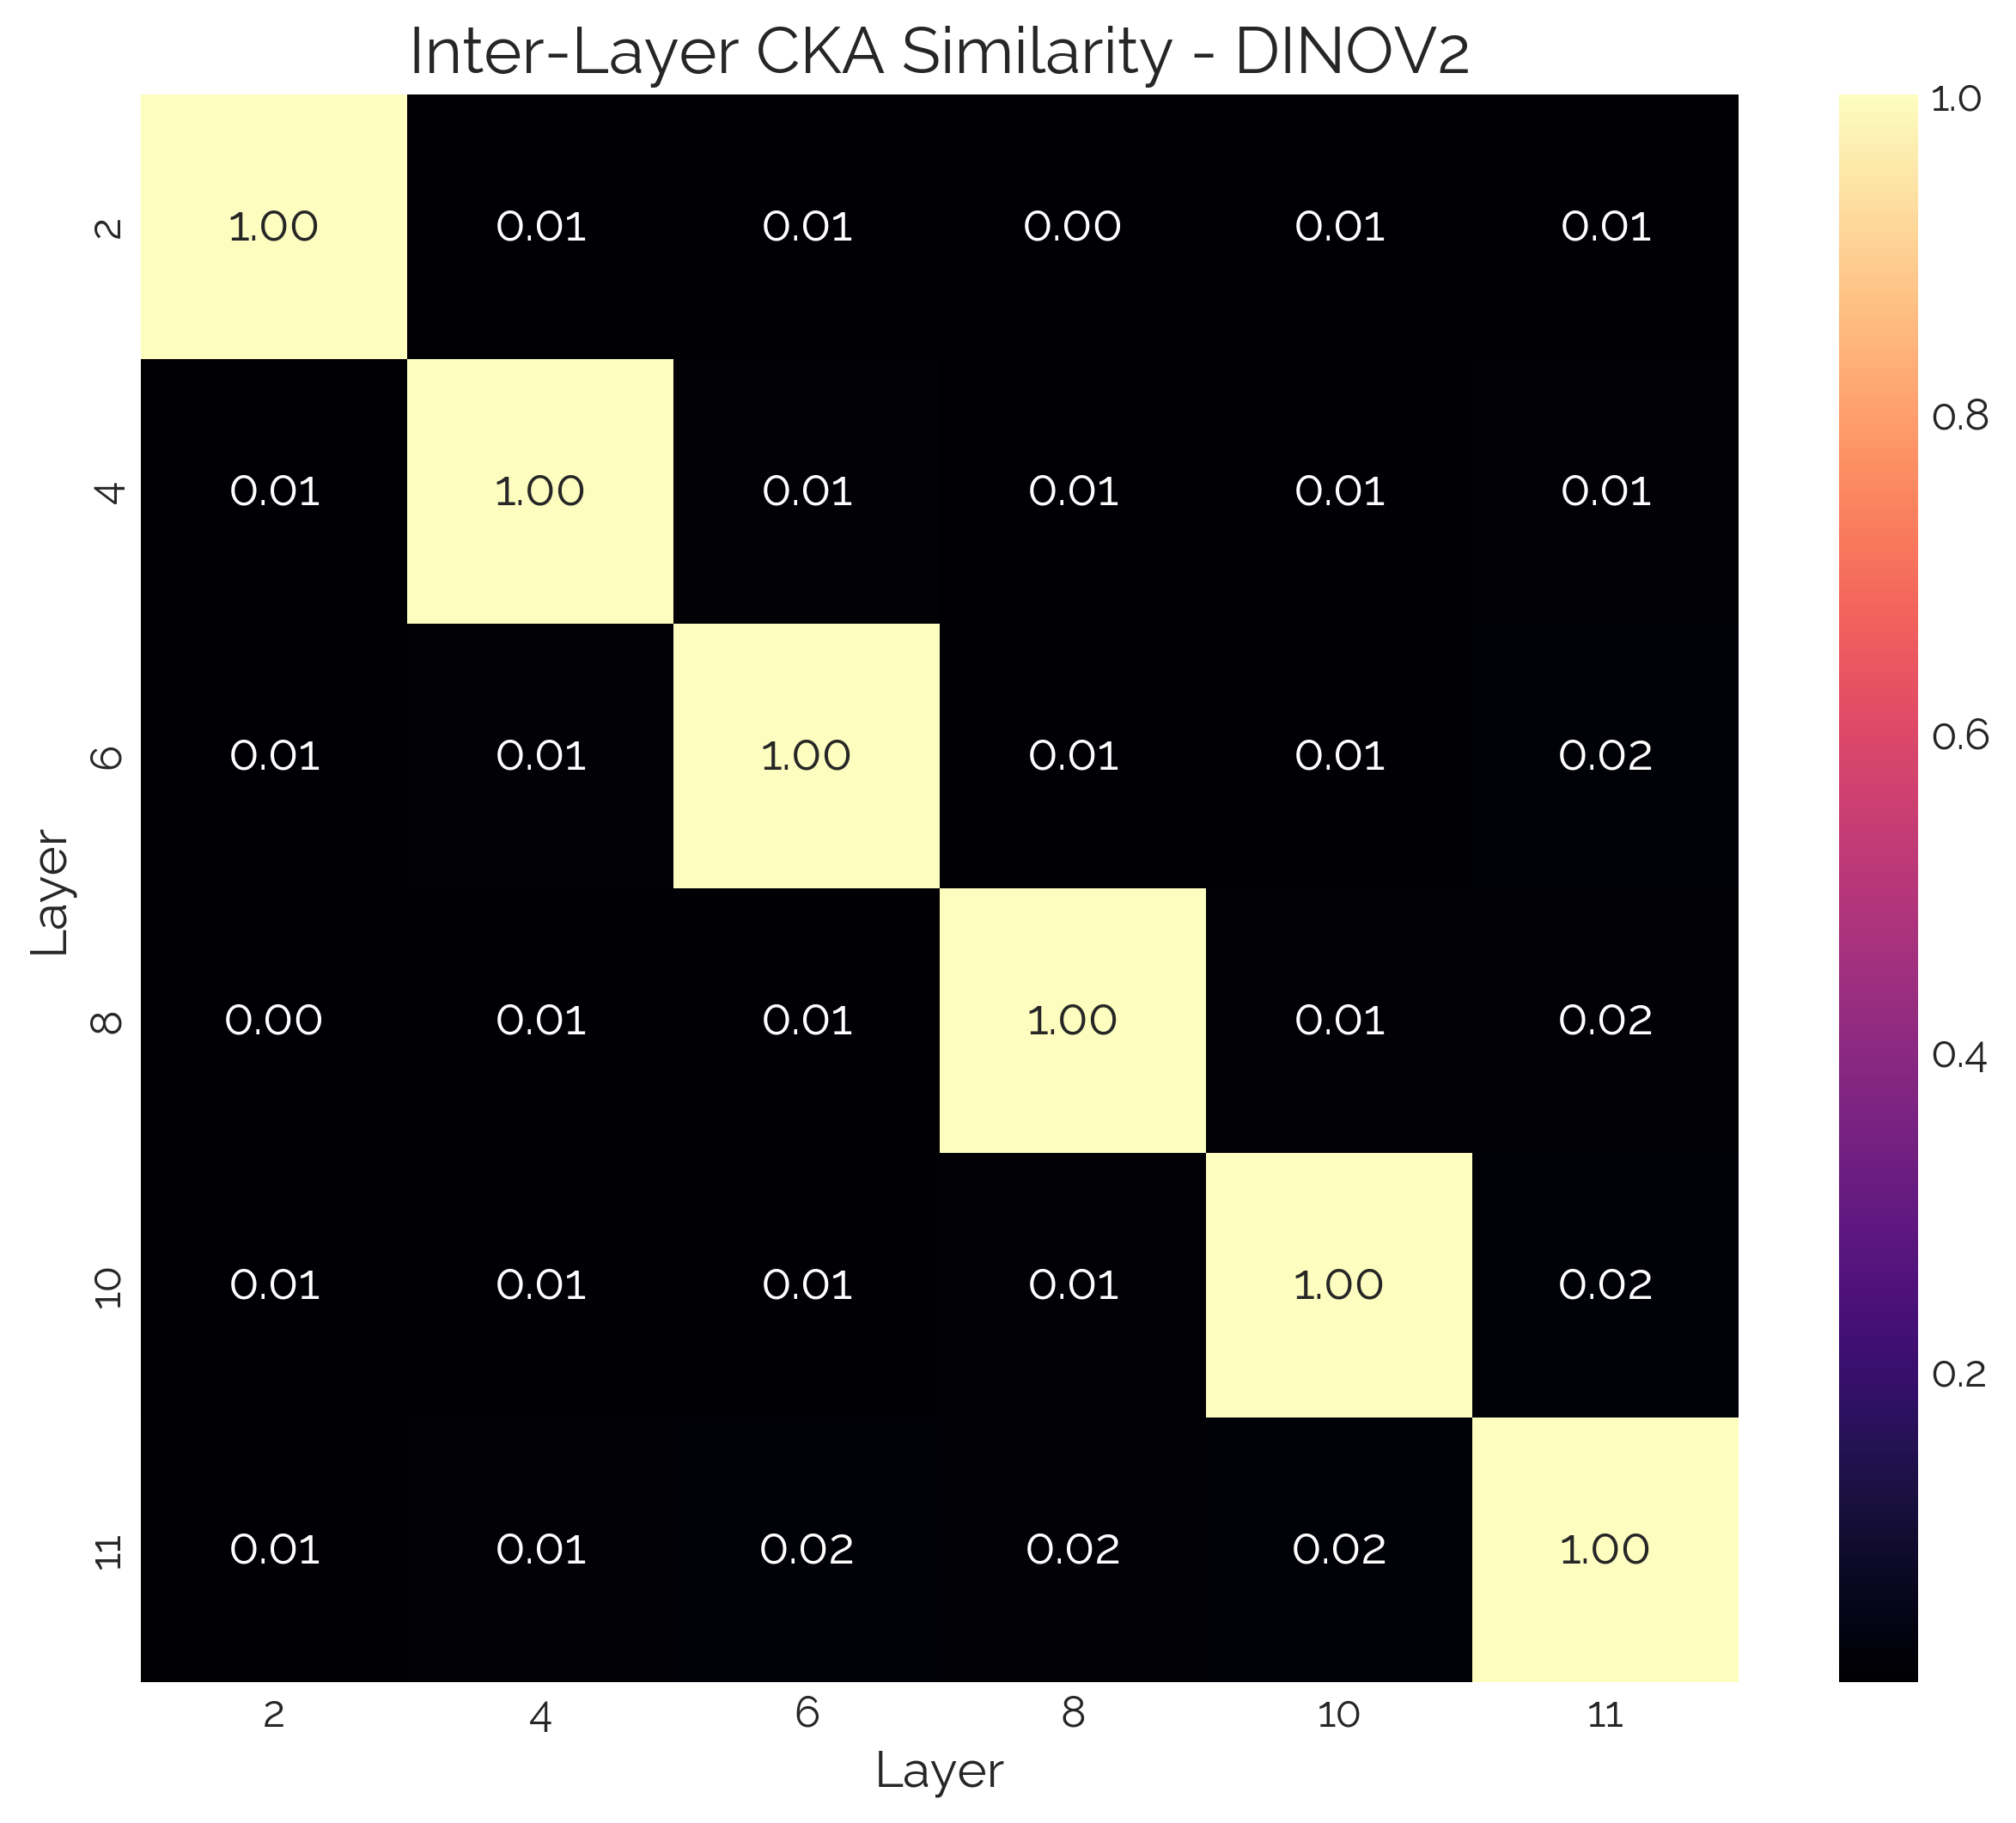

In [ ]:
def center_gram_torch(K: torch.Tensor) -> torch.Tensor:
    """Center a Gram matrix (kernel)."""
    row_mean = K.mean(dim=1, keepdim=True)
    col_mean = K.mean(dim=0, keepdim=True)
    total_mean = K.mean()
    return K - row_mean - col_mean + total_mean

def get_inter_layer_cka_matrix(layer_features: List[torch.Tensor], device: torch.device) -> np.ndarray:
    """
    Computes the CKA matrix between a list of layer feature tensors.
    """
    n_layers = len(layer_features)
    cka_matrix = np.zeros((n_layers, n_layers))
    
    print("Computing Inter-Layer CKA Matrix... (this may take a moment)")
    
    centered_kernels = []
    for features_tensor in layer_features:
        kernel = torch.from_numpy(rbf_kernel(features_tensor.cpu().numpy())).to(device)
        centered_kernels.append(center_gram_torch(kernel))

    for i in range(n_layers):
        for j in range(i, n_layers):
            if i == j:
                cka_matrix[i, j] = 1.0
                continue
            
            K_i_centered = centered_kernels[i]
            K_j_centered = centered_kernels[j]
            
            numerator = torch.sum(K_i_centered * K_j_centered)
            denominator = torch.sqrt(torch.sum(K_i_centered**2) * torch.sum(K_j_centered**2))
            cka = (numerator / denominator).cpu().item()
            
            cka_matrix[i, j] = cka
            cka_matrix[j, i] = cka
            
    return cka_matrix

def create_inter_layer_cka_similarity(experiment: ExperimentResult, loader: ExperimentLoader, output_manager: OutputManager):
    """
    Loads all layer features for a model and visualizes their CKA similarity matrix.
    """
    feature_files = loader.get_feature_files(experiment)
    if not feature_files:
        print(f"No feature files found for {experiment.name} to run CKA analysis.")
        return

    layer_indices = sorted(feature_files.keys())
    all_layer_features = []
    
    print(f"Loading features for {experiment.model} ({experiment.task})...")
    for layer in layer_indices:
        if 'test' in feature_files[layer]:
            with open(feature_files[layer]['test'], 'rb') as f:
                data = pickle.load(f)
            
            if 'voxel' in experiment.task and 'view_data' in data:
                feature_source = data['view_data']
            elif 'features' in data:
                feature_source = data['features']
            else:
                print(f"Warning: Could not find a valid feature key in layer {layer} for {experiment.name}. Skipping layer.")
                continue
            
            if hasattr(feature_source, 'ndim') and feature_source.ndim == 3:
                print(f"  > Reshaping 3D features in layer {layer} from {feature_source.shape} to 2D.")
                n_samples, n_patches, n_dims = feature_source.shape
                feature_source = feature_source.reshape(n_samples, n_patches * n_dims)

            if not isinstance(feature_source, torch.Tensor):
                feature_source = torch.from_numpy(feature_source)

            n_samples_to_use = min(1000, len(feature_source))
            indices = np.random.choice(len(feature_source), n_samples_to_use, replace=False)
            all_layer_features.append(feature_source[indices])

    if len(all_layer_features) < 2:
        print(f"Not enough layer features to compare for {experiment.name}.")
        return

    cka_matrix = get_inter_layer_cka_matrix(all_layer_features, device)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cka_matrix, annot=True, fmt=".2f", cmap="magma", ax=ax,
                xticklabels=layer_indices, yticklabels=layer_indices)
    
    ax.set_title(f'Inter-Layer CKA Similarity - {experiment.model.upper()}', fontsize=VisualConfig.TITLE_SIZE)
    ax.set_xlabel('Layer'); ax.set_ylabel('Layer')
    
    output_manager.save_figure(fig, f'cka_inter_layer_{experiment.model}_{experiment.task}')
    output_manager.save_data({'model': experiment.model, 'task': experiment.task, 'layers': layer_indices, 'cka_matrix': cka_matrix.tolist()}, f'cka_inter_layer_{experiment.model}_{experiment.task}_data')
    plt.show()

for exp in all_experiments.values():
    create_inter_layer_cka_similarity(exp, loader, output_manager)

### 6.2 Attention Comparisons

Loading data.... be patient!
Processing: IJEPA (Layer: 11, Method: aggregate)
Processing: DINOV2 (Layer: 8, Method: cls)
Saved figure: final_analysis/figures/comparative_attention_analysis_final_20250607_232056.png


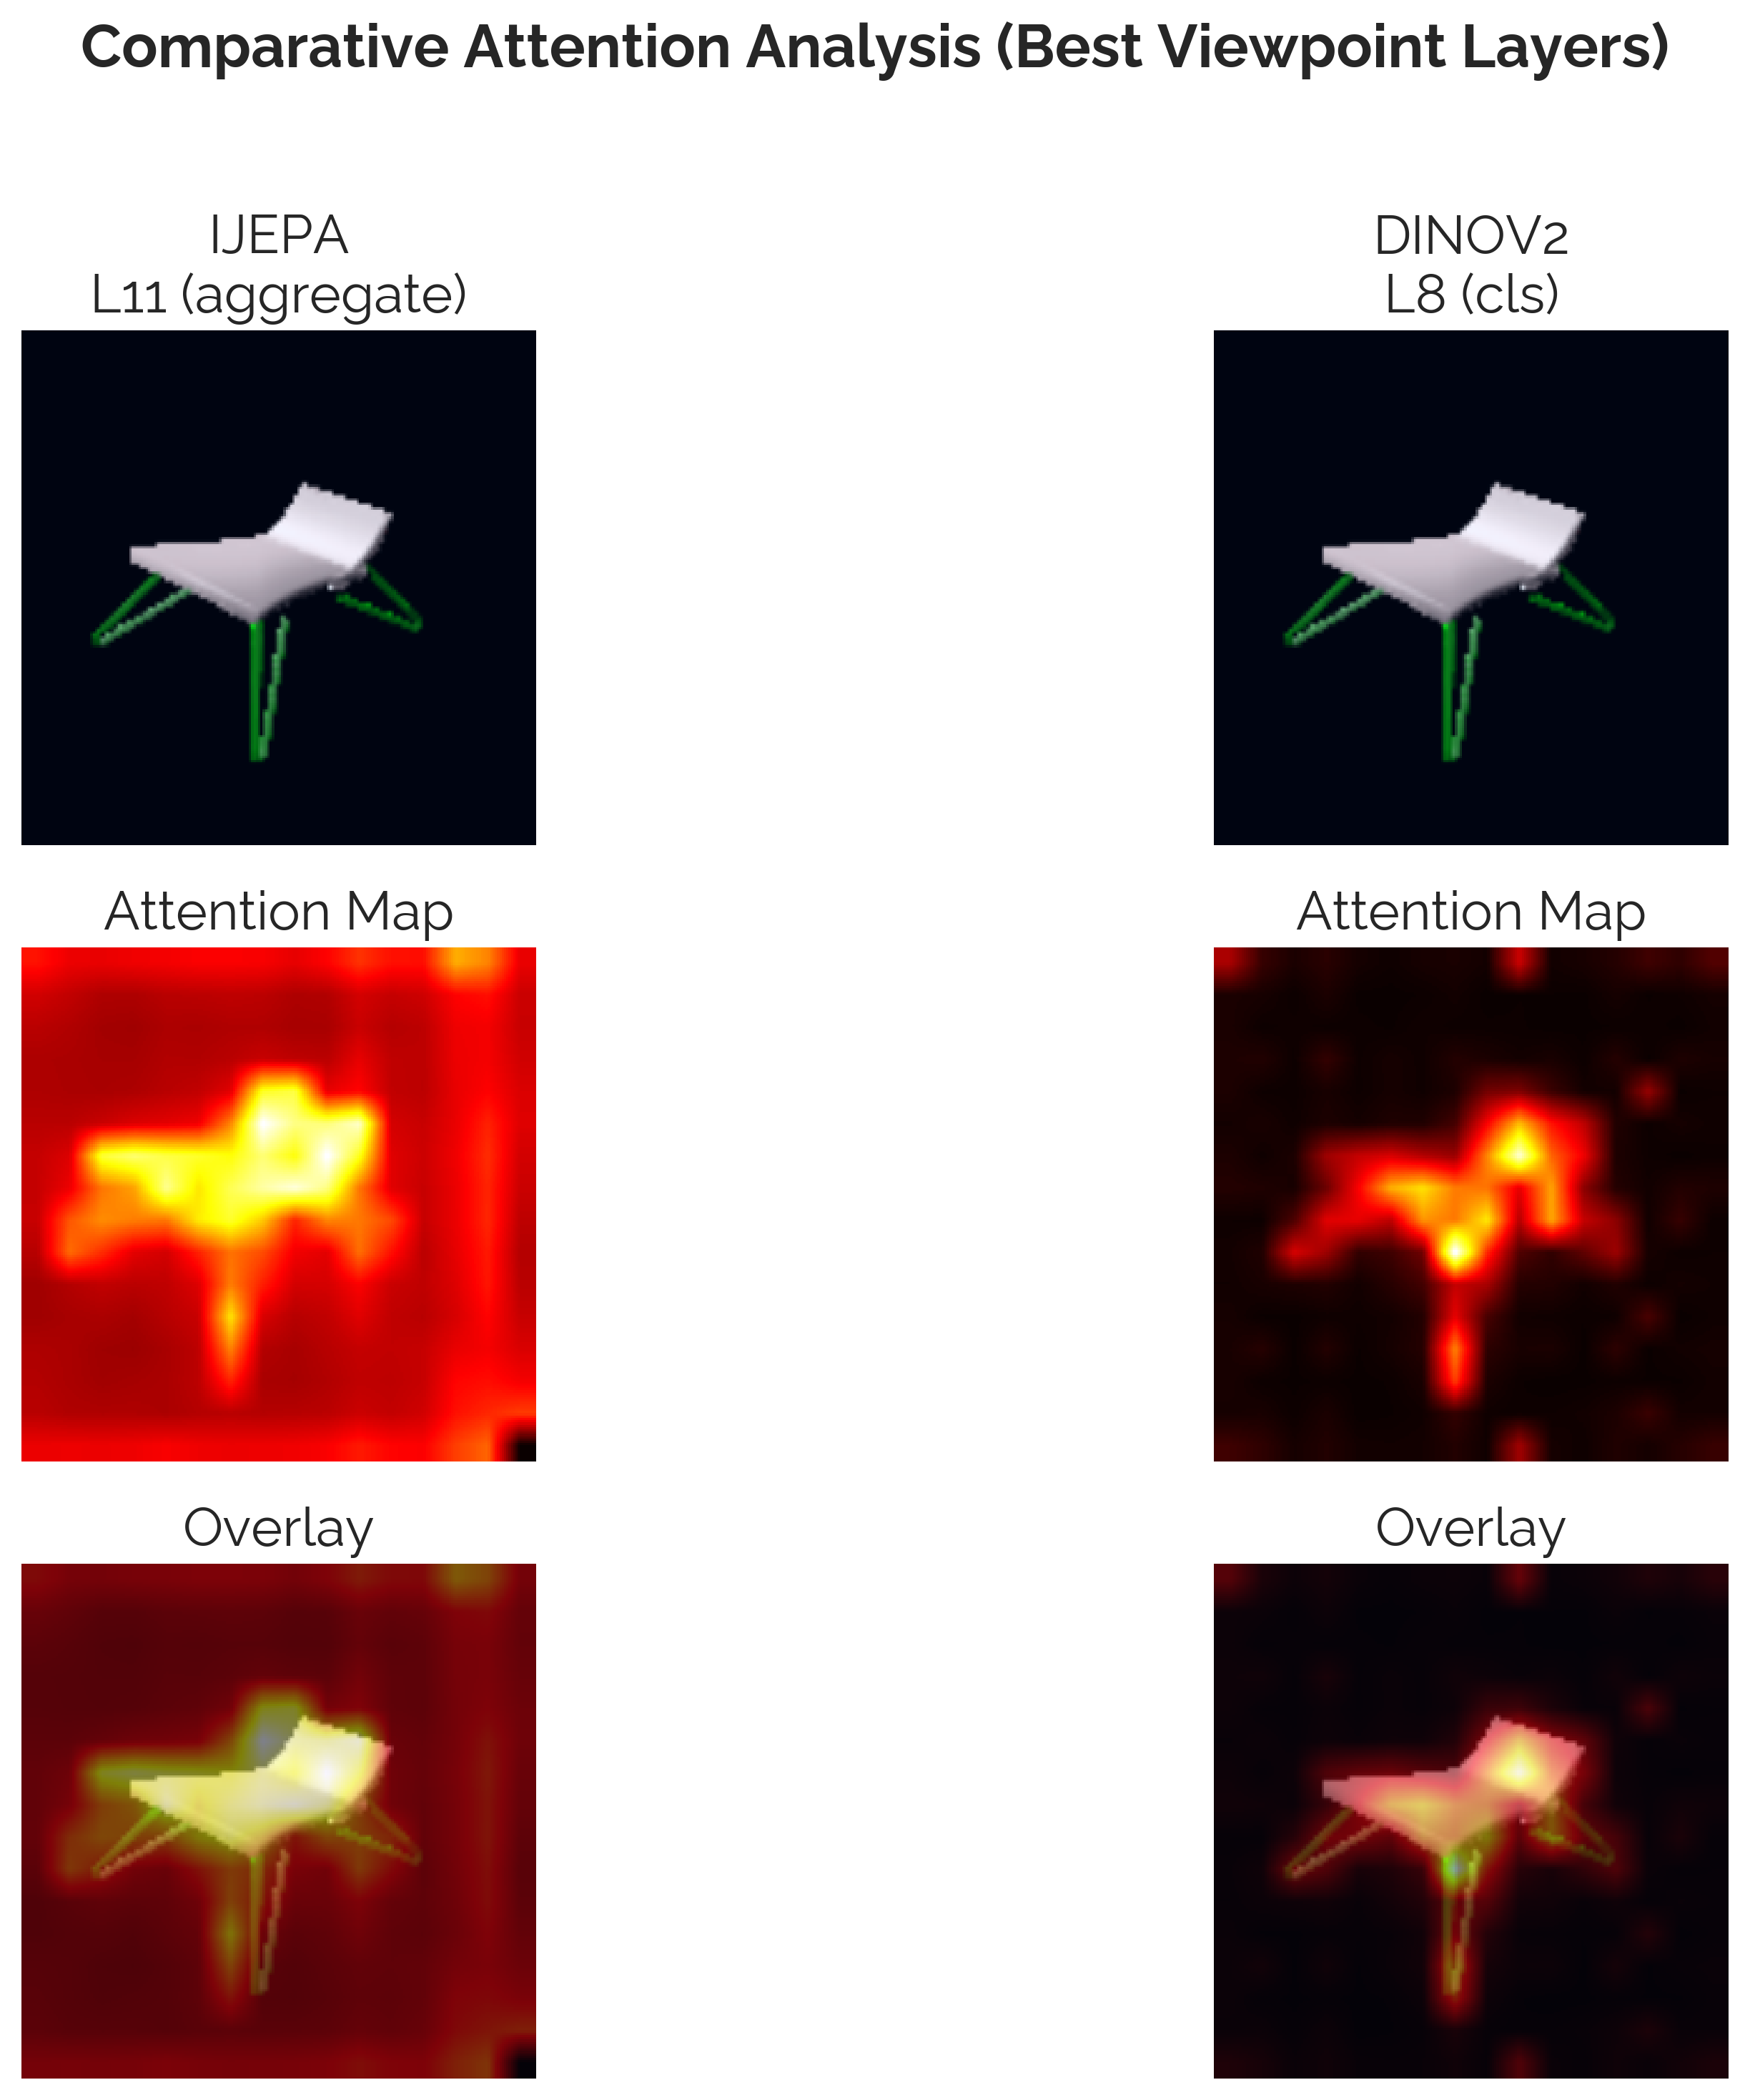

In [34]:
import torch.nn.functional as F
import traceback
from omegaconf import OmegaConf

def visualize_attention_for_model(
    image_tensor: torch.Tensor,
    model_name: str,
    layer: int,
    method: str,
    device: torch.device,
    axes: np.ndarray
):
    """
    Visualize the attntion scores using some fanccyyyyy stuff!
    """
    try:
        model, _ = load_model_and_preprocessor(model_name, ckpt_path=None, device=device, cache_dir=None)
        model.to(device).eval()
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        inputs_on_device = image_tensor.to(device)

        all_attentions = []
        with torch.no_grad():
            if 'timm' not in model_name and model_name != 'ijepa':
                outputs = model(inputs_on_device, output_attentions=True)
                all_attentions = outputs.attentions
            else:
                attention_maps_by_layer = {}
                hook_handles = []
                original_fused_attn_states = {}
                def get_hook(layer_idx):
                    def hook_fn(module, input_args, output_tensor):
                        attention_maps_by_layer[layer_idx] = input_args[0].detach()
                    return hook_fn

                if not hasattr(model, 'blocks') or not model.blocks: return
                for i, block in enumerate(model.blocks):
                    attn_module = block.attn
                    if hasattr(attn_module, 'fused_attn'):
                        original_fused_attn_states[i] = attn_module.fused_attn
                        attn_module.fused_attn = False
                    handle = attn_module.attn_drop.register_forward_hook(get_hook(i))
                    hook_handles.append(handle)
                
                _ = model(inputs_on_device)
                for handle in hook_handles: handle.remove()
                for i, state in original_fused_attn_states.items(): model.blocks[i].attn.fused_attn = state
                
                num_heads = model.blocks[0].attn.num_heads
                batch_size = inputs_on_device.shape[0]
                for i in sorted(attention_maps_by_layer.keys()):
                    attn_probs = attention_maps_by_layer[i]
                    if attn_probs.ndim == 3:
                        num_tokens = attn_probs.shape[-1]
                        attn_probs = attn_probs.view(batch_size, num_heads, num_tokens, num_tokens)
                    all_attentions.append(attn_probs)

        if not all_attentions: return

        attn_from_layer = all_attentions[layer]
        attn_to_vis = attn_from_layer.mean(dim=1)
        
        if method == 'cls':
            attention_vector = attn_to_vis[0, 0, 1:]
        elif method == 'aggregate':
            patch_attn = attn_to_vis[0, 1:, 1:]
            attention_vector = patch_attn.sum(dim=0)
        
        num_patch_tokens = attention_vector.shape[-1]
        patch_grid_size = int(np.sqrt(num_patch_tokens))
        
        if patch_grid_size * patch_grid_size == num_patch_tokens:
            attention_map_reshaped = attention_vector.reshape(patch_grid_size, patch_grid_size)
        elif hasattr(model, 'patch_embed') and hasattr(model.patch_embed, 'grid_size'):
            grid_h, grid_w = model.patch_embed.grid_size
            expected_tokens = grid_h * grid_w
            if num_patch_tokens != expected_tokens:
                padding_needed = expected_tokens - num_patch_tokens
                if padding_needed > 0:
                    padded_attention = F.pad(attention_vector, (0, padding_needed), value=0)
                    attention_map_reshaped = padded_attention.reshape(grid_h, grid_w)
                else:
                    attention_map_reshaped = attention_vector[:expected_tokens].reshape(grid_h, grid_w)
            else:
                attention_map_reshaped = attention_vector.reshape(grid_h, grid_w)
        else:
            raise RuntimeError(f"Cannot determine grid size for {model_name} with {num_patch_tokens} tokens.")

        attention_map_reshaped = attention_map_reshaped.cpu().numpy()
        attention_map_reshaped = (attention_map_reshaped - attention_map_reshaped.min()) / (attention_map_reshaped.max() - attention_map_reshaped.min() + 1e-6)
        
        attn_resized = F.interpolate(
            torch.tensor(attention_map_reshaped).unsqueeze(0).unsqueeze(0),
            size=(image_tensor.shape[-2], image_tensor.shape[-1]),
            mode='bilinear',
            align_corners=False
        ).squeeze().cpu().numpy()

        img_for_show = image_tensor[0].permute(1, 2, 0).cpu().numpy()
        min_val, max_val = img_for_show.min(), img_for_show.max()
        img_for_show = (img_for_show - min_val) / (max_val - min_val + 1e-6)
        
        ax1, ax2, ax3 = axes
        title = f"{model_name.upper()}\nL{layer} ({method})"
        
        ax1.imshow(img_for_show); ax1.set_title(title); ax1.axis('off')
        im = ax2.imshow(attn_resized, cmap='hot'); ax2.set_title('Attention Map'); ax2.axis('off')
        ax3.imshow(img_for_show); ax3.imshow(attn_resized, cmap='hot', alpha=0.5); ax3.set_title('Overlay'); ax3.axis('off')

    except Exception as e:
        print(f"An error occurred while visualizing attention for {model_name}: {e}")

def run_comparative_attention_analysis(experiments: List[ExperimentResult], output_manager: OutputManager):
    """Manages the process of creating a side-by-side attention visualization."""
    image = None
    try:
        dataset_config = OmegaConf.load('../configs/datasets/shapenet_3dr2n2.yaml')
        dataset_config.categories = ['chair']
        print("Loading data.... be patient!")
        _, _, test_loader = create_3dr2n2_dataloaders(dataset_config, batch_size=1, num_workers=0)
        image = next(iter(test_loader))['image'][0]
    except Exception as e:
        print(f"Fatal: Could not load sample image. Aborting. Error: {e}")
        return

    model_configs = {}
    for exp in experiments:
        if exp.task == 'viewpoint_estimation':
            best_layer, _ = exp.get_best_layer()
            if best_layer is not None:
                method = 'aggregate' if 'ijepa' in exp.model.lower() else 'cls'
                model_configs[exp.model] = {'layer': best_layer, 'method': method}
    
    n_models = len(model_configs)
    if n_models == 0: return
        
    fig, axes = plt.subplots(3, n_models, figsize=(7 * n_models, 10), squeeze=False)
    
    for idx, (model_name, config) in enumerate(model_configs.items()):
        print(f"Processing: {model_name.upper()} (Layer: {config['layer']}, Method: {config['method']})")
        visualize_attention_for_model(
            image_tensor=image, model_name=model_name,
            layer=config['layer'], method=config['method'],
            device=device, axes=axes[:, idx]
        )

    fig.suptitle('Comparative Attention Analysis (Best Viewpoint Layers)', fontsize=VisualConfig.TITLE_SIZE + 2, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    output_manager.save_figure(fig, 'comparative_attention_analysis_final')
    plt.show()

viewpoint_exps = categorized_experiments.get('viewpoint_estimation', [])
if viewpoint_exps:
    run_comparative_attention_analysis(viewpoint_exps, output_manager)
